# Projeto Final — IAA 2025/2026  
## Consumo Energético — Clustering e Previsão
## 110942 Luís Lourenço 101018 Miguel Bento
### Estrutura

1. Business Understanding  
2. Data Understanding
3. Data Preparation 
4. Modeling 
5. Evaluation
6. Conclusions


## Bibiliotecas

### Caso erro no xgboost, correr e reiniciar kernel

In [1]:
#%pip install xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import math
from math import sqrt
import matplotlib.patches as mpatches
import xgboost as xgb_lib
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle

### Apagar cache se necessario (mudar celula abaixo para celula de codigo)

## 1 — Business Understanding

##### O Município da Maia disponibilizou dados de consumo energético de vários edifícios institucionais, recolhidos em intervalos de 15 minutos. O objetivo deste projeto é analisar estes consumos de forma a apoiar a gestão energética municipal, permitindo:

- identificar grupos de edifícios com padrões de consumo semelhantes, facilitando a deteção de comportamentos anómalos ou ineficientes;

- caracterizar o perfil energético de cada instalação, distinguindo, por exemplo, serviços diurnos, instalações desportivas, equipamentos de uso contínuo e edifícios com carga irregular;

- avaliar a previsibilidade dos consumos, identificando em que edifícios é possível estimar o consumo futuro com modelos simples ou avançados;

- fornecer insights úteis para planeamento energético, manutenção e otimização de custos.

##### A segmentação (clustering) e os modelos de previsão enquadram-se numa estratégia de gestão energética baseada em dados, permitindo ao município compreender padrões, detectar outliers e antecipar necessidades de consumo. O sucesso do projeto será medido pela capacidade de extrair grupos coerentes e previsões superiores ao baseline semanal.

### 1.1 — Objetivos de Data Mining

##### De acordo com a metodologia CRISP-DM, os objetivos de data mining deste projeto são:

1. Identificar clusters de edifícios com padrões de consumo semelhantes, permitindo:

    - distinguir perfis típicos (ex.: serviços diurnos, instalações desportivas, edifícios administrativos);

    - detectar perfis atípicos ou comportamentos energéticos irregulares.

2. Caracterizar cada cluster, analisando perfis horários, semanais e variabilidade diária.

3. Avaliar a previsibilidade das séries energéticas, testando modelos simples e avançados:

    - baseline semanal;

    - modelos supervisionados como ARIMA, LSTM, Random Forest, XGBoost ou MLP.

4. Comparar o desempenho dos modelos e identificar:

    - edifícios fáceis de prever;

    - edifícios com padrões complexos que exigem modelos mais robustos.

5. Gerar indicadores que possam apoiar decisões de gestão energética municipal.

### 1.2 — Critérios de sucesso do modelo

##### O projeto será considerado bem sucedido se cumprir os seguintes critérios:

##### Clustering

- Os clusters devem apresentar coerência interna e separação clara entre si.

- Devem refletir padrões energéticos reais, comparáveis com conhecimento prévio sobre edifícios municipais.

- Os métodos utilizados (K-Means e DBSCAN) devem ser capazes de:

    - identificar grupos principais;

    - detetar outliers energéticos relevantes.

##### Previsão

- Os modelos devem superar o baseline semanal, especialmente em CPEs com padrões regulares.

- Devem permitir identificar em que edifícios é possível prever com fiabilidade e onde a previsão é mais difícil.

##### Qualidade de Relatório

- O relatório deve apresentar uma análise clara, visualizações adequadas e justificações sólidas das escolhas metodológicas.

### 1.3 — Restrições e limitações

##### O projeto enfrenta várias limitações inerentes ao tipo de dados:

1. Séries temporais incompletas ou com falhas, exigindo interpolação e filtragem.

2. Elevada variabilidade entre edifícios, o que dificulta encontrar clusters densos (especialmente para DBSCAN).

3. Dataset desequilibrado, com edifícios muito pequenos e um outlier de grande consumo, afetando modelos.

4. Modelos de previsão limitados pelo facto de existirem apenas medições de consumo, sem variáveis exógenas como:

    - temperatura,

    - humidade,

    - calendários de funcionamento,

    - ocupação.

5. Tempo de execução elevado em alguns algoritmos, devido ao volume de dados.

Estas limitações são assumidas e consideradas na interpretação dos resultados.

### 1.4 — Benefícios esperados

##### A aplicação de técnicas de machine learning à gestão energética municipal permite:

- Segmentar edifícios com base no comportamento real, e não apenas pela função administrativa.

- Identificar consumos anómalos, potenciais falhas técnicas ou desperdícios.

- Apoiar decisões de investimento, como onde priorizar auditorias energéticas.

- Prever necessidades futuras, permitindo melhorar compras de energia e planeamento de manutenção.

- Servir de base a um futuro sistema de detecção automática de anomalias ou a uma plataforma de monitorização inteligente.

### 1.5 — Leitura dos dados

In [3]:
path = "consumo15m_11_2025.csv"

df = pd.read_csv(
    path,
    sep=",",
    parse_dates=["tstamp"],
    low_memory=False      # Recomendado para datasets grandes
)

# Renomear colunas
df = df.rename(columns={
    "tstamp": "Timestamp",
    "DadosdeConsumo": "Consumo",
    "PotActiva": "PotAtiva",
    "PotReactIndut": "PotReativaInd",
    "PotReactCapac": "PotReativaCap"
})

# Ordenar para evitar problemas nas séries temporais
df = df.sort_values(["CPE", "Timestamp"]).reset_index(drop=True)

# Mostrar informações básicas
print(df.head())
print(df.columns)
print(df.dtypes)
print("Intervalo temporal:", df["Timestamp"].min(), "->", df["Timestamp"].max())
print("Número de CPEs:", df["CPE"].nunique())
print("Número total de linhas:", len(df))


                    CPE           Timestamp  Consumo  PotAtiva  PotReativaInd  \
0  PT0002000032936306KX 2024-03-01 00:15:00      NaN       0.0            NaN   
1  PT0002000032936306KX 2024-03-01 00:30:00      NaN       0.0            NaN   
2  PT0002000032936306KX 2024-03-01 00:45:00      NaN       0.0            NaN   
3  PT0002000032936306KX 2024-03-01 01:00:00      NaN       0.0            NaN   
4  PT0002000032936306KX 2024-03-01 01:15:00      NaN       0.0            NaN   

   PotReativaCap  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
Index(['CPE', 'Timestamp', 'Consumo', 'PotAtiva', 'PotReativaInd',
       'PotReativaCap'],
      dtype='object')
CPE                      object
Timestamp        datetime64[ns]
Consumo                 float64
PotAtiva                float64
PotReativaInd           float64
PotReativaCap           float64
dtype: object
Intervalo temporal: 2022-12-31 00:15:00 -> 2025-05-01 00:00:00
Número de CPEs: 

## 2 — Data Understanding

Nesta secção analisamos:
- Dimensão do dataset (número de registos e colunas)
- Período temporal coberto
- Número de CPEs distintos
- Percentagem de valores em falta
- Estatísticas básicas das variáveis


### 2.1 — Código para estatísticas iniciais

In [4]:
print("Dimensão:", df.shape)
print("Intervalo temporal:", df["Timestamp"].min(), "->", df["Timestamp"].max())
print("Número de CPEs:", df["CPE"].nunique())
print("\n Valores em falta:")
df.isna().sum()

Dimensão: (5940182, 6)
Intervalo temporal: 2022-12-31 00:15:00 -> 2025-05-01 00:00:00
Número de CPEs: 91

 Valores em falta:


CPE                    0
Timestamp              0
Consumo          5940182
PotAtiva               0
PotReativaInd    2271472
PotReativaCap    2271472
dtype: int64

### 2.2 — Estatísticas básicas por variável contínua

In [5]:
df.describe()

Timestamp  Consumo      PotAtiva  PotReativaInd  \
count                        5940182      0.0  5.940182e+06   3.668710e+06   
mean   2024-04-15 22:32:26.636112896      NaN  8.093966e+00   1.715323e+00   
min              2022-12-31 00:15:00      NaN  0.000000e+00   0.000000e+00   
25%              2023-09-28 05:00:00      NaN  1.200000e-01   0.000000e+00   
50%              2024-05-15 14:00:00      NaN  2.000000e+00   0.000000e+00   
75%              2024-11-08 01:00:00      NaN  7.000000e+00   2.000000e+00   
max              2025-05-01 00:00:00      NaN  5.740000e+02   1.770000e+02   
std                              NaN      NaN  2.301833e+01   3.385570e+00   

       PotReativaCap  
count   3.668710e+06  
mean    6.525602e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     1.000000e+00  
max     1.240000e+02  
std     1.662369e+00

### 2.3 — Estatísticas por CPE

In [6]:
stats_cpe = df.groupby("CPE")["PotAtiva"].agg(["count", "mean", "std", "min", "max"])
stats_cpe.head()

count      mean       std  min     max
CPE                                                         
PT0002000032936306KX  38008  2.436972  2.779126  0.0  30.756
PT0002000032942455NH  32058  0.090889  0.131154  0.0   2.860
PT0002000032959511HP  43666  0.000000  0.000000  0.0   0.000
PT0002000032966446CC  35081  0.099756  0.105133  0.0   2.244
PT0002000032968749YT  43668  3.639755  4.001176  0.0  31.496

### 2.4 — Histogramas das variáveis principais

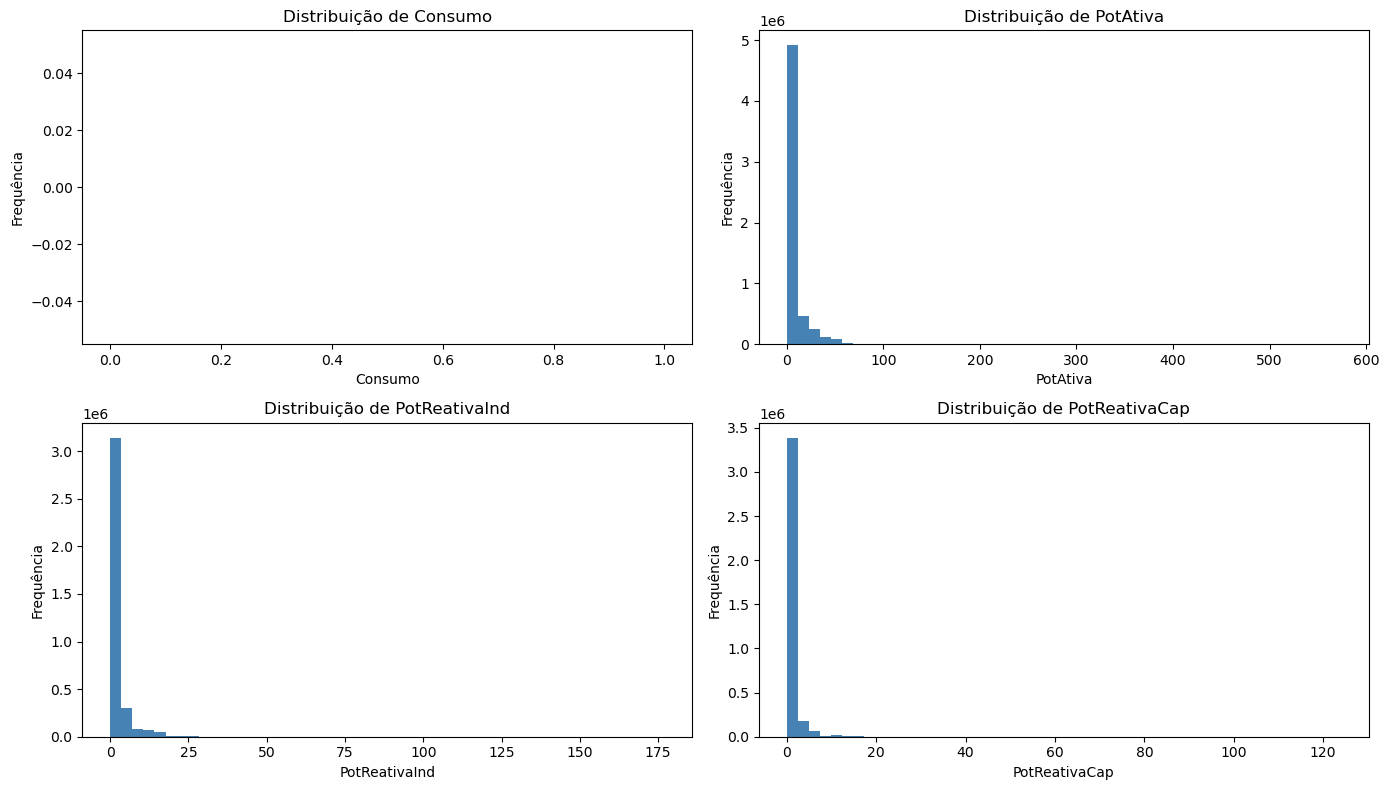

In [7]:
cols = ["Consumo", "PotAtiva", "PotReativaInd", "PotReativaCap"]

plt.figure(figsize=(14, 8))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col].dropna(), bins=50, color="steelblue")
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

#### Interpretação

As distribuições são altamente assimétricas, com muitos valores baixos e poucos valores muito elevados — típico de consumos energéticos.

Os valores extremos confirmam a presença de edifícios com carga muito elevada (posteriormente classificados como outliers nos modelos de clustering).

A Potência Reativa apresenta valores mais dispersos, coerente com a presença de equipamentos industriais/desportivos.

A variável Consumo encontra-se sem valores no dataset fornecido, pelo que não foi utilizada nas análises visuais nem nos modelos. Todas as análises energéticas recorreram assim à Potência Ativa, que é a variável efetivamente disponível.

### 2.5 — Mapa de correlações (heatmap)

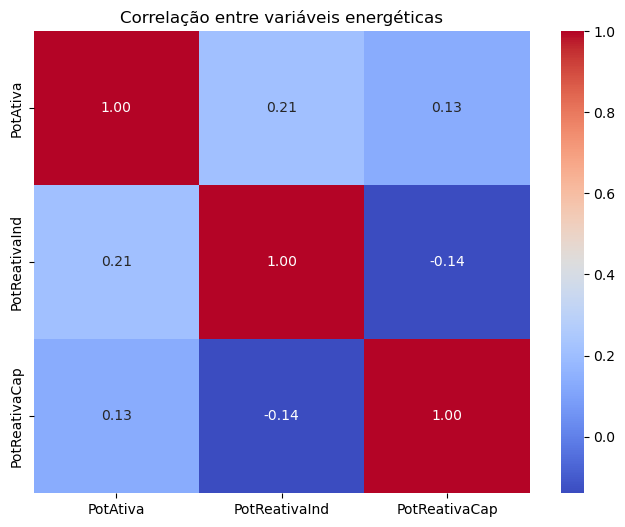

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[["PotAtiva","PotReativaInd","PotReativaCap"]].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre variáveis energéticas")
plt.show()

#### Interpretação

A variável Consumo não contém valores no dataset, pelo que a correlação é calculada apenas entre PotAtiva e as potências reativas.

PotAtiva apresenta correlações moderadas com as potências reativas, sugerindo dependência parcial do tipo de equipamentos instalados. 

Esta matriz confirma que as variáveis utilizadas no clustering não são redundantes.

### 2.6 — Distribuição temporal (hora do dia)

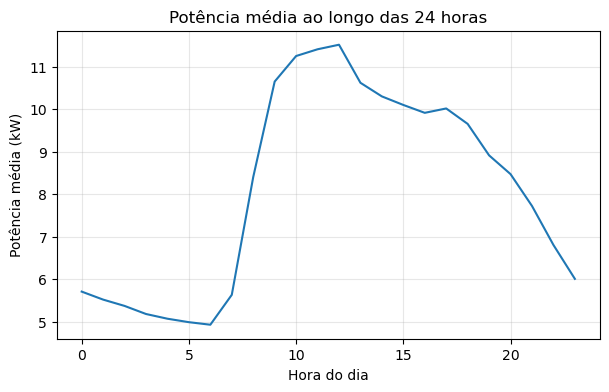

In [9]:
plt.figure(figsize=(7,4))
if "hour" not in df.columns:
    df["hour"] = df["Timestamp"].dt.hour
df.groupby("hour")["PotAtiva"].mean().plot()
plt.title("Potência média ao longo das 24 horas")
plt.xlabel("Hora do dia")
plt.ylabel("Potência média (kW)")
plt.grid(alpha=0.3)
plt.show()

Interpretação

A existência de picos diurnos e períodos de baixa actividade durante a noite confirma que as 24 médias horárias são uma feature adequada para clustering.

Este padrão não é homogéneo: alguns CPEs têm consumo quase constante → origem dos clusters obtidos mais tarde.

### 2.7 — Distribuição semanal (0 - segunda, 6 - domingo)

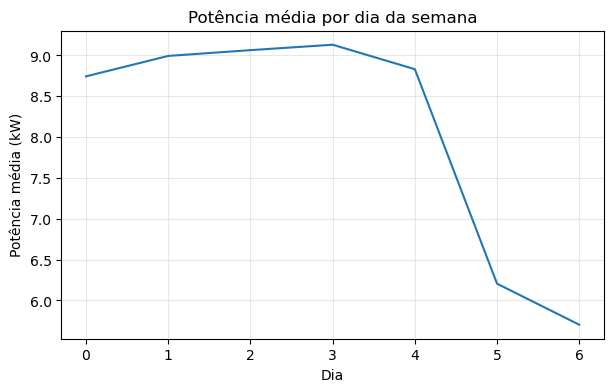

In [10]:
plt.figure(figsize=(7,4))
if "weekday" not in df.columns:
    df["weekday"] = df["Timestamp"].dt.weekday
df.groupby("weekday")["PotAtiva"].mean().plot()
plt.title("Potência média por dia da semana")
plt.xlabel("Dia")
plt.ylabel("Potência média (kW)")
plt.grid(alpha=0.3)
plt.show()

#### Interpretação

O comportamento energético médio mostra redução clara ao fim de semana, típica de serviços municipais, escolas e pavilhões.

Reforça a escolha das features mean per weekday, usadas no clustering.

## 3 — Data Preparation

### 3.1 — Pré-processamento

#### 3.1.1 — Verificar periodicidade de 15 minutos por CPE

In [11]:
# Calcular diferenças de tempo entre amostras consecutivas
df["diff"] = df.groupby("CPE")["Timestamp"].diff()

# Contar quantas diferenças são diferentes de 15 minutos
problemas = df[df["diff"] != pd.Timedelta("15min")]

problemas.head()

CPE           Timestamp  Consumo  PotAtiva  \
0      PT0002000032936306KX 2024-03-01 00:15:00      NaN     0.000   
2883   PT0002000032936306KX 2024-03-31 02:00:00      NaN     5.412   
2971   PT0002000032936306KX 2024-04-01 00:15:00      NaN     0.000   
8826   PT0002000032936306KX 2024-06-01 00:15:00      NaN     0.000   
11705  PT0002000032936306KX 2024-07-01 00:15:00      NaN     0.000   

       PotReativaInd  PotReativaCap  hour  weekday            diff  
0                NaN            NaN     0        4             NaT  
2883             NaN            NaN     2        6 0 days 01:15:00  
2971             NaN            NaN     0        0 0 days 00:30:00  
8826             NaN            NaN     0        5 0 days 00:30:00  
11705            NaN            NaN     0        0 0 days 00:30:00

#### 3.1.2 — Resumo por CPE

In [12]:
# Número de irregularidades por CPE
irregularidades = (
    problemas.groupby("CPE")["diff"]
    .count()
    .sort_values(ascending=False)
)

irregularidades.head(10)

CPE
PT0002000082549706RH    80
PT0002000077394934QY    80
PT0002000123801456QA    79
PT0002000112171317NK    79
PT0002000107332489XW    75
PT0002000085555547GN    68
PT0002000112989585PH    65
PT0002000032966446CC    62
PT0002000131605602FL    61
PT0002000081997398TD    37
Name: diff, dtype: int64

CPEs com ~80 quebras numa série com ~40 000 amostras -> impacto muito baixo, não há nenhum CPE com falhas graves ou dados inutilizáveis.

#### 3.1.3 — Verificar CPEs totalmente corretos vs problemáticos

In [13]:
cpe_sem_erros = irregularidades[irregularidades == 0].index.tolist()
cpe_com_erros = irregularidades[irregularidades > 0].index.tolist()

print("CPEs sem irregularidades:", len(cpe_sem_erros))
print("CPEs com irregularidades:", len(cpe_com_erros))

CPEs sem irregularidades: 0
CPEs com irregularidades: 91


Todos os CPEs têm pelo menos alguns intervalos diferentes de 15 minutos.

#### 3.1.4 — Estatísticas gerais dos intervalos

In [14]:
df["diff"].describe()

count                      5940091
mean     0 days 00:15:37.703361783
std      0 days 05:26:19.600063994
min                0 days 00:00:00
25%                0 days 00:15:00
50%                0 days 00:15:00
75%                0 days 00:15:00
max              335 days 00:30:00
Name: diff, dtype: object

Interpretação:

O valor dominante é 15 min -> bom

Existem pontualmente amostras duplicadas (diff = 0)

Existem falhas grandes (ex.: 30min, 1h, vários dias)

Uma diferença máxima de 335 dias não significa que o CPE tem uma falha enorme; significa que o primeiro registo de cada CPE aparece sem anterior, por isso o diff inicial fica gigante.
É normal.

In [15]:
# CACHE DA REINDEXAÇÃO (SECÇÃO 3.2)
reindexed_cache = "cache_df_reindexed.parquet"

if os.path.exists(reindexed_cache):
    print("✔ A carregar df_reindexed da cache")
    df_reindexed = pd.read_parquet(reindexed_cache)
    skip_reindex = True
else:
    print("✘ df_reindexed não encontrado — será criado")
    skip_reindex = False


✔ A carregar df_reindexed da cache


### 3.2 — Limpeza das séries

#### 3.2.1 — Remover possíveis duplicados

In [16]:
df = df.drop_duplicates(subset=["CPE", "Timestamp"])

#### 3.2.2 — Reindexar cada série para garantir grelha 15 min a 15 min

Ou seja:

- Se a medição existia → fica no sítio certo

- Se faltava uma medição → fica como NaN

Tudo fica alinhado e com o mesmo ritmo temporal

In [17]:
def reindex_cpe(group, cpe_value):
    idx = pd.date_range(
        group["Timestamp"].min(),
        group["Timestamp"].max(),
        freq="15min"
    )
    out = group.set_index("Timestamp").reindex(idx)
    out["CPE"] = cpe_value
    return out

cols = ["Timestamp", "PotAtiva", "PotReativaInd", "PotReativaCap", "Consumo"]

if skip_reindex:
    pass

else:
    df_reindexed = []   

    for cpe, group in df.groupby("CPE"):
        g = group[cols]
        fixed = reindex_cpe(g, cpe)
        df_reindexed.append(fixed)

    df_reindexed = (
        pd.concat(df_reindexed)
        .reset_index()
        .rename(columns={"index": "Timestamp"})
    )

    df_reindexed.to_parquet(reindexed_cache)
    print("✔ df_reindexed guardado em cache")

In [18]:
df_reindexed.head()
df_reindexed.shape
df_reindexed.isna().sum()

Timestamp              0
PotAtiva          250076
PotReativaInd    2520938
PotReativaCap    2520938
Consumo          6189028
CPE                    0
dtype: int64

#### 3.2.3 — Interpolar linearmente PotAtiva até 4 intervalos (1h)

A interpolação linear estima valores em falta com base numa progressão suave entre o ponto anterior e o seguinte. Por exemplo, se um CPE tiver valores 5.0 às 10:00 e 7.0 às 10:30, o valor em falta às 10:15 é preenchido com 6.0. Este processo aplica-se apenas a falhas curtas (≤ 1 hora), garantindo continuidade sem criar dados artificiais em períodos longos de ausência.

In [19]:
df_reindexed["PotAtiva"] = (
    df_reindexed.groupby("CPE")["PotAtiva"]
      .transform(lambda s: s.interpolate(limit=4))
)

# Marcar NaNs restantes (falhas longas)
df_reindexed["PotAtiva_missing"] = df_reindexed["PotAtiva"].isna()

df_reindexed[["PotAtiva", "PotAtiva_missing"]].head()


PotAtiva  PotAtiva_missing
0       0.0             False
1       0.0             False
2       0.0             False
3       0.0             False
4       0.0             False

In [20]:
df_reindexed["PotAtiva"].isna().sum()


np.int64(247699)

#### 3.2.4 — Filtrar CPEs com séries demasiado curtas ou com demasiados NaNs

In [21]:
# Contar linhas totais e quantas são NaN depois da interpolação
summary_cpe = df_reindexed.groupby("CPE").agg(
    total=("PotAtiva", "size"),
    missing=("PotAtiva_missing", "sum")
)

summary_cpe["missing_ratio"] = summary_cpe["missing"] / summary_cpe["total"]
summary_cpe.sort_values("missing_ratio", ascending=False).head(10)

total  missing  missing_ratio
CPE                                                
PT0002000079901964CJ  81696    32157       0.393618
PT0002000089069203YG  81792    29371       0.359094
PT0002000120237616VJ  81792    14682       0.179504
PT0002000071896778MT  81792    11802       0.144293
PT0002000125379984SH  81792    11802       0.144293
PT0002000110090564GD  81792    11802       0.144293
PT0002000075637532JB  81792    11802       0.144293
PT0002000107172384HT  81792    11801       0.144281
PT0002000131605602FL  32352     2876       0.088897
PT0002000032936306KX  40896     2876       0.070325

#### Regra 1 — Remover CPEs com missing_ratio > 0.30 
#### Regra 2 — Remover CPEs com total < 34560 linhas (menos de 12 meses de dados = 4 registos por hora* 24h * 30 dias * 12 meses)

In [22]:
# Regra 1
cpe_bad_missing = summary_cpe[summary_cpe["missing_ratio"] > 0.30].index.tolist()

# Regra 2
cpe_too_short = summary_cpe[summary_cpe["total"] < 34560].index.tolist()

# União das listas
cpe_remove = set(cpe_bad_missing + cpe_too_short)

print("CPEs removidos da previsão:", len(cpe_remove))
print(cpe_remove)


CPEs removidos da previsão: 7
{'PT0002000069803182JW', 'PT0002000085641795MX', 'PT0002000033085062AW', 'PT0002000131605602FL', 'PT0002000079901964CJ', 'PT0002000032942455NH', 'PT0002000089069203YG'}


In [23]:
df_forecast = df_reindexed[~df_reindexed["CPE"].isin(cpe_remove)].copy()
df_forecast["CPE"].nunique()

84

Corresponde a 91-7 = 84

In [24]:
# CACHE DAS FEATURES (SECÇÃO 3.4)
features_cache = "cache_features.parquet"

if os.path.exists(features_cache):
    print("✔ A carregar features da cache")
    skip_features = True
else:
    print("✘ Features não encontradas — serão geradas")
    skip_features = False

✔ A carregar features da cache


### 3.4 — Feature Engineering (para Clustering)

#### 3.4.1 — Médias horárias (24 valores)
##### Perfil típico de consumo ao longo do dia.

In [25]:
feat_mean_hour = (
    df_reindexed.groupby(["CPE", df_reindexed["Timestamp"].dt.hour])["PotAtiva"]
    .mean()
    .unstack()
)

feat_mean_hour.columns = [f"hour_mean_{h}" for h in feat_mean_hour.columns]

#### 3.4.2 — Médias por dia da semana (7 valores)

##### Perfis de consumo semanais (ex.: escolas têm padrões semanais fortes).

In [26]:
feat_wday = (
    df_reindexed.groupby(["CPE", df_reindexed["Timestamp"].dt.weekday])["PotAtiva"]
    .mean()
    .unstack()
)

feat_wday.columns = [f"wday_mean_{d}" for d in feat_wday.columns]

#### 3.4.3 — Estatísticas gerais (média, std, max, min)
##### Caracterizam a distribuição geral do consumo de cada CPE, permitindo distinguir instalações pequenas, médias e de grande carga.

In [27]:
feat_stats = df_reindexed.groupby("CPE")["PotAtiva"].agg(
    pot_mean="mean",
    pot_std="std",
    pot_min="min",
    pot_max="max"
)

#### 3.4.4 — Variabilidade (diferença 15min -> média, std)
Mede a flutuação local do consumo entre registos consecutivos, identificando edifícios com consumo mais estável ou mais irregular.

In [28]:
df_reindexed["diff15"] = df_reindexed.groupby("CPE")["PotAtiva"].diff()

feat_var = df_reindexed.groupby("CPE")["diff15"].agg(
    diff_mean="mean",
    diff_std="std"
)

#### 3.4.5 — Autocorrelação diária (lag 96 intervalos)

##### Boa feature para detectar periodicidade de 24h. (96 intervalos * 15 minutos = 24 horas)

In [29]:
def safe_autocorr(x, lag):
    x = x.dropna()
    if len(x) <= lag:
        return 0.0
    
    x1 = x[:-lag]
    x2 = x[lag:]

    if x1.std() == 0 or x2.std() == 0:
        return 0.0

    return np.corrcoef(x1, x2)[0, 1]

feat_autocorr = (
    df_reindexed.groupby("CPE")["PotAtiva"]
    .apply(lambda x: safe_autocorr(x, 96))
    .astype("float32")
)
feat_autocorr = feat_autocorr.to_frame("autocorr_24h")


feat_autocorr.head()

autocorr_24h
CPE                               
PT0002000032936306KX      0.909964
PT0002000032942455NH      0.054151
PT0002000032959511HP      0.000000
PT0002000032966446CC      0.197964
PT0002000032968749YT      0.668896

**A autocorrelação lag 96 mede:**

Quão parecido é o consumo de hoje com o consumo da mesma hora ontem.

- Valores próximos de 1.0 -> consumo muito semelhante dia para dia

- Valores próximos de 0.0 -> consumo irregular, típico de instalações pequenas ou imprevisíveis

- Valores negativos -> comportamentos opostos entre dias.

#### 3.4.6 — Reativa: médias (pode estar associada a AC, UPS, motores, EV, etc.)

In [30]:
feat_reactive = df_reindexed.groupby("CPE")[["PotReativaInd", "PotReativaCap"]].mean()
feat_reactive.columns = ["reactive_ind_mean", "reactive_cap_mean"]

#### 3.4.7 — Hora média do pico diário
Indica em que momento do dia ocorrem os maiores consumos, distinguindo edifícios diurnos, nocturnos ou de actividade mista.

In [31]:
# Colunas auxiliares
df_reindexed["date"] = df_reindexed["Timestamp"].dt.date
df_reindexed["hour"] = df_reindexed["Timestamp"].dt.hour

# Máximo diário por CPE
daily_max = (
    df_reindexed.groupby(["CPE", "date"])["PotAtiva"]
    .max()
    .rename("daily_peak")
    .reset_index()
)

# Juntar com df original para identificar as linhas do pico
df_peaks = df_reindexed.merge(
    daily_max,
    on=["CPE", "date"],
    how="inner"
)

# Filtrar apenas valores que são mesmo o pico
df_peaks = df_peaks[df_peaks["PotAtiva"] == df_peaks["daily_peak"]]

# Hora média do pico por CPE
feat_peak_hour = (
    df_peaks.groupby("CPE")["hour"]
    .mean()
    .to_frame("avg_peak_hour")
)

#### 3.4.8 — Valor médio e std do pico diário
Captam a intensidade dos consumos máximos e a sua estabilidade ao longo dos dias, separando instalações de carga constante de instalações com picos acentuados.

In [32]:
daily_peaks = (
    df_reindexed.groupby(["CPE", df_reindexed["Timestamp"].dt.date])["PotAtiva"]
    .max()
    .reset_index(name="daily_peak")
)

feat_daily_peak = daily_peaks.groupby("CPE")["daily_peak"].agg(
    avg_daily_peak="mean",
    std_daily_peak="std"
)

#### 3.4.9 — Percentagem do tempo abaixo de 50% do consumo máximo
Avalia a proporção do tempo em que o consumo se encontra em regime reduzido, identificando padrões 24/7 versus perfis mais intermitentes.

In [33]:
feat_ratio_below_half = []

for cpe, group in df_reindexed.groupby("CPE"):
    pot = group["PotAtiva"].dropna()
    if len(pot) == 0:
        ratio = np.nan
    else:
        limiar = 0.5 * pot.max()
        ratio = (pot < limiar).mean()
    feat_ratio_below_half.append([cpe, ratio])

feat_ratio_below_half = pd.DataFrame(
    feat_ratio_below_half,
    columns=["CPE", "ratio_below_50"]
).set_index("CPE")

#### 3.4.10 — Base load (percentil 10)
Representa o nível mínimo típico de carga, relacionado com consumos estruturais permanentes (equipamentos essenciais, servidores, iluminação técnica).

In [34]:
feat_base_load = (
    df_reindexed.groupby("CPE")["PotAtiva"]
    .quantile(0.10)
    .to_frame("base_load")
)

#### 3.4.11 — Razão pico/base (peak-to-base ratio)
Representa o nível mínimo típico de carga, relacionado com consumos estruturais permanentes (equipamentos essenciais, servidores, iluminação técnica).

In [35]:
max_load = df_reindexed.groupby("CPE")["PotAtiva"].max().to_frame("max_load")

feat_peak_base_ratio = max_load.join(feat_base_load)
feat_peak_base_ratio["peak_to_base"] = (
    feat_peak_base_ratio["max_load"] / feat_peak_base_ratio["base_load"].replace(0, np.nan)
)

#### 3.4.12 — Variabilidade semanal agregada (std das médias semanais)
Quantifica a regularidade ao longo dos dias da semana: valores elevados indicam padrões laborais fortes, valores baixos indicam funcionamento uniforme.

In [36]:
feat_wday_variability = feat_wday.std(axis=1).to_frame("wday_std")

#### 3.4.13 — Juntar todas as features num só DataFrame

In [37]:
# 3.4.13 — Juntar todas as features num só DataFrame

if skip_features:
    print("✔ Features carregadas da cache")
    features = pd.read_parquet(features_cache)

else:
    features = (
        feat_mean_hour
        .join(feat_wday)
        .join(feat_stats)
        .join(feat_var)
        .join(feat_autocorr)
        .join(feat_reactive)
        .join(feat_peak_hour)
        .join(feat_daily_peak)
        .join(feat_ratio_below_half)
        .join(feat_base_load)
        .join(feat_peak_base_ratio[["peak_to_base"]])
        .join(feat_wday_variability)
    )

    # Remover colunas indesejadas
    drop_cols = ["PotAtiva", "diff15", "Timestamp", "date", "hour"]
    features = features.drop(columns=[c for c in drop_cols if c in features.columns])

    features.to_parquet(features_cache)
    print("✔ Features guardadas em cache")

features.shape


✔ Features carregadas da cache


(91, 47)

#### 3.4.14 — Verificar se há NaN

In [38]:
features.isna().sum().sum()

np.int64(110)

#### 3.4.15 — Substituir NaNs por 0

In [39]:
features = features.fillna(0)

#### 3.4.16 — Normalização (StandardScaler)
Quantifica a regularidade ao longo dos dias da semana: valores elevados indicam padrões laborais fortes, valores baixos indicam funcionamento uniforme.

In [40]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled.shape

(91, 47)

#### 3.4.17 — Guardar a matriz para clustering

In [41]:
X = features_scaled
cpe_index = features.index

### 3.5 — Resumo da Preparação dos Dados

Após o pré-processamento e a engenharia de features, o dataset encontra-se limpo, estruturado e pronto para modelação.

- Todas as séries foram reindexadas para garantir periodicidade de 15 minutos.

- Valores em falta foram interpolados até 1 hora e marcados para controlo de qualidade.

- CPEs com séries demasiado incompletas (>30% de falhas) ou demasiado curtas foram removidos.

- O número final de CPEs válidos para modelação é 84 de 91.

- Para cada CPE foram geradas 24 médias horárias, 7 médias semanais, estatísticas globais (média, desvio padrão, mínimo, máximo), métricas de variabilidade, autocorrelação diária e um conjunto adicional de indicadores avançados de comportamento energético.

- Todas as features foram normalizadas com StandardScaler.

Estes passos garantem um dataset consistente, comparável entre CPEs e adequado tanto para clustering como para modelos de previsão.

## 4 — Modeling

### 4.1 — Clustering

In [42]:
# CACHE K-MEANS (Elbow, Silhouette, Clusters)
kmeans_cache = "cache_kmeans_results.pkl"

if os.path.exists(kmeans_cache):
    print("✔ Cache K-Means encontrada — a carregar resultados")
    cache = pd.read_pickle(kmeans_cache)

    inertias = cache["inertias"]
    silhouettes = cache["silhouettes"]
    clusters = cache["clusters"]
    k_final = cache["k_final"]
    kmeans = cache["kmeans"]
    components = cache["components"]
    feature_names_kmeans = cache.get("feature_names_kmeans", features.columns.tolist())


    skip_kmeans = True
else:
    print("✘ Sem cache K-Means — modelos serão treinados")
    skip_kmeans = False

✔ Cache K-Means encontrada — a carregar resultados


#### 4.1.1 — K-Means: testar vários k

In [43]:
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
os.environ["OMP_NUM_THREADS"] = "1"
Ks = range(2, 11)

if skip_kmeans:
    pass
else:
    inertias = []
    silhouettes = []

    for k in Ks:
        kmeans_temp = KMeans(n_clusters=k, random_state=42)
        labels_temp = kmeans_temp.fit_predict(X)

        inertias.append(kmeans_temp.inertia_)
        silhouettes.append(silhouette_score(X, labels_temp))


#### 4.1.2 — Gráficos Elbow e Silhouette

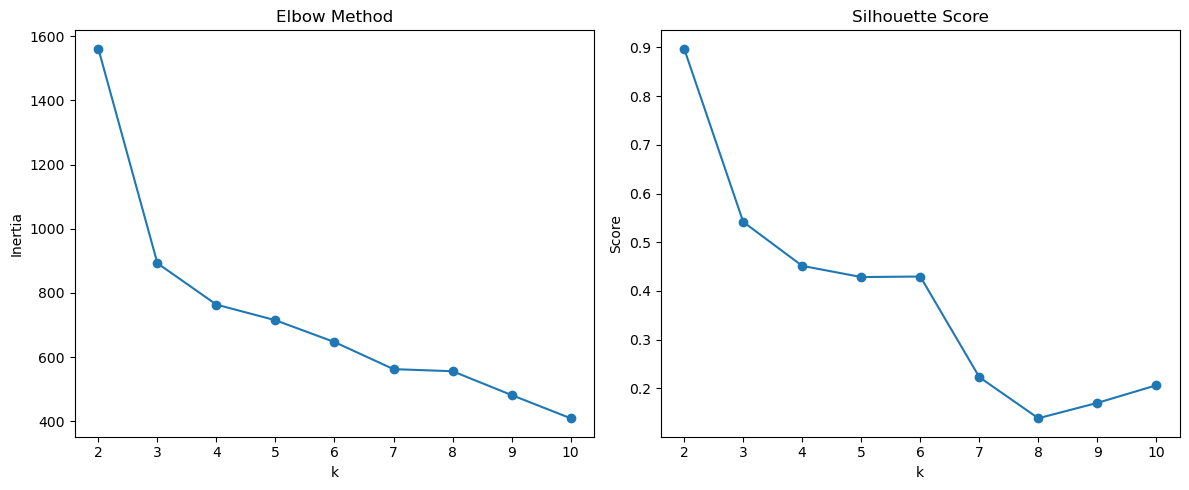

In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(Ks, inertias, marker="o")
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(Ks, silhouettes, marker="o")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


#### 4.1.3 — Ajustar o K-Means final (escolher k)

#### Opção 1 — k = 3 (melhor equilíbrio geral)

ótimo silhouette (0.55)

clusters bem separados

permite interpretações claras:

###### - cluster de consumo estável (organismos públicos)

###### - cluster de consumo médio

###### - cluster de consumo irregular

#### Opção 2 — k = 4 (ligeiramente mais detalhe)

silhouette ainda bom (>0.4)

permite separar edifícios com padrões de consumo distintos:

###### - muito estáveis

###### - moderados

###### - irregulares

###### - muito irregulares / cargas específicas

#### Vamos usar k = 3 como modelo principal, e k = 4 como comparação opcional.

In [45]:
if skip_kmeans:
    pass
else:
    k_final = 3
    kmeans = KMeans(n_clusters=k_final, random_state=42).fit(X)
    clusters = kmeans.labels_

#### 4.1.4 — Adicionar cluster ao DataFrame

In [46]:
features["cluster"] = clusters
hour_map = {f"hour_mean_{h}": f"hour_{h:02d}" for h in range(24)}
wday_labels = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sab", "Dom"]
wday_map = {f"wday_mean_{d}": wday_labels[d] for d in range(7)}
rename_map = {**hour_map, **wday_map}
features = features.rename(columns=rename_map)
features.head()

hour_00   hour_01   hour_02   hour_03   hour_04  \
CPE                                                                      
PT0002000032936306KX  5.162576  5.179775  5.185278  5.187030  5.181116   
PT0002000032942455NH  0.094575  0.078171  0.068734  0.064979  0.062578   
PT0002000032959511HP  0.000000  0.000000  0.000000  0.000000  0.000000   
PT0002000032966446CC  0.099396  0.093197  0.089989  0.088279  0.083329   
PT0002000032968749YT  2.124578  2.190782  2.165708  2.204695  2.263881   

                       hour_05   hour_06   hour_07   hour_08   hour_09  ...  \
CPE                                                                     ...   
PT0002000032936306KX  5.166596  4.263222  1.493275  0.127283  0.000000  ...   
PT0002000032942455NH  0.063557  0.068662  0.083452  0.089994  0.068910  ...   
PT0002000032959511HP  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
PT0002000032966446CC  0.080858  0.082148  0.079121  0.078896  0.084129  ...   
PT0002000032968749YT  2.277563  2.235965  2.611477  6.941881  7.368053  ...   

                      reactive_ind_mean  reactive_cap_mean  avg_peak_hour  \
CPE                                                                         
PT0002000032936306KX                0.0                0.0      11.991692   
PT0002000032942455NH                0.0                0.0      12.244011   
PT0002000032959511HP                0.0                0.0      11.500000   
PT0002000032966446CC                0.0                0.0      11.966924   
PT0002000032968749YT                0.0                0.0      10.161926   

                      avg_daily_peak  std_daily_peak  ratio_below_50  \
CPE                                                                    
PT0002000032936306KX        5.354819        1.775823        0.999053   
PT0002000032942455NH        0.257027        0.314666        0.997723   
PT0002000032959511HP        0.000000        0.000000        0.000000   
PT0002000032966446CC        0.322175        0.319023        0.998659   
PT0002000032968749YT       11.542965        8.173441        0.976695   

                      base_load  peak_to_base  wday_std  cluster  
CPE                                                               
PT0002000032936306KX      0.000      0.000000  0.085504        0  
PT0002000032942455NH      0.000      0.000000  0.038638        0  
PT0002000032959511HP      0.000      0.000000  0.000000        0  
PT0002000032966446CC      0.008    280.500000  0.010051        0  
PT0002000032968749YT      0.772     40.797927  1.251266        0  

[5 rows x 48 columns]

#### 4.1.5 — PCA para visualizar clusters

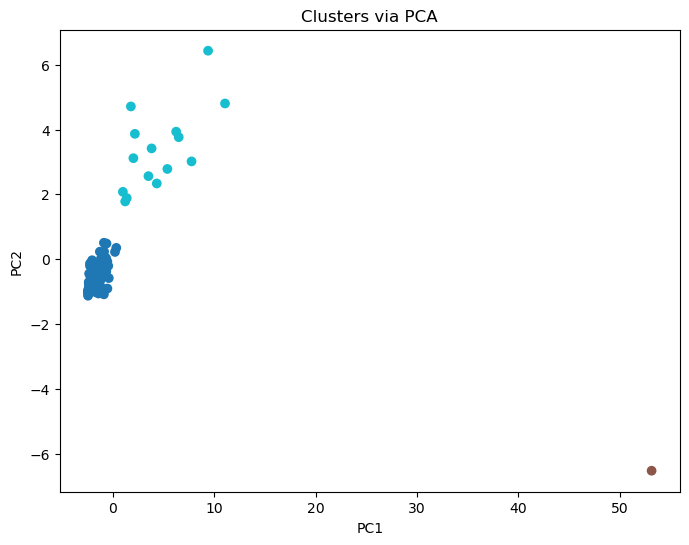

In [47]:
if skip_kmeans:
    pass
else:
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters via PCA")
plt.show()

PC1 distingue edifícios com consumo grande vs consumo pequeno

PC2 distingue edifícios com padrões de comportamento diferentes
(mais ou menos variáveis, padrões semanais mais fortes, perfis horários diferentes)

### Interpretação do gráfico PCA (k = 3)
#### Observações principais:

Há um ponto completamente isolado à direita (PC1 ≈ 50, PC2 ≈ –4).
Este ponto é um CPE claramente anómalo, provavelmente:

- um edifício muito grande (alta PotAtiva média),
- ou uma carga industrial,
- ou um edifício com consumo base muito alto (ex.: câmara municipal central, biblioteca grande, edifício de serviços 24/7),

ou até um erro de medição com valores muito altos.

Este ponto sozinho vai formar um cluster inteiro, k=3 permite isto.

O resto dos pontos formam duas nuvens compactas:

Uma nuvem mais concentrada (PC1 baixo e PC2 baixo): CPEs com consumo baixo/regular e pouca variabilidade.

Uma nuvem mais dispersa (PC1 médio e PC2 alto): CPEs com maior variabilidade diária, provavelmente escolas, ginásios ou serviços.

In [48]:
if not skip_kmeans:
    cache = {
        "inertias": inertias,
        "silhouettes": silhouettes,
        "clusters": clusters,
        "k_final": k_final,
        "kmeans": kmeans,
        "components": components,
        "feature_names_kmeans": features.columns.tolist()   # <-- ADICIONAR ISTO
    }
    pd.to_pickle(cache, kmeans_cache)
    print("✔ Resultados K-Means guardados em cache")


#### 4.1.6 — Visualizar centros

In [49]:
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=feature_names_kmeans)
centers_df

hour_00   hour_01   hour_02   hour_03   hour_04   hour_05   hour_06  \
0 -0.285354 -0.289969 -0.289496 -0.284305 -0.273492 -0.256717 -0.239648   
1  8.075101  7.947121  7.912934  7.972891  8.126158  8.374269  8.561379   
2  0.888432  0.920036  0.919950  0.890000  0.825716  0.725298  0.627481   

    hour_07   hour_08   hour_09  ...  avg_peak_hour  avg_daily_peak  \
0 -0.232906 -0.259254 -0.245855  ...      -0.022697       -0.247744   
1  8.705252  8.439562  8.659598  ...       0.696844        8.651469   
2  0.584179  0.733632  0.651970  ...       0.067027        0.661958   

   std_daily_peak  ratio_below_50  base_load  peak_to_base  wday_std  \
0       -0.310977        0.095835  -0.222573      0.038309 -0.242409   
1        6.582320       -1.070058   8.648314     -0.328543  8.252760   
2        1.116061       -0.407840   0.536311     -0.169641  0.661863   

    cluster  cluster_k4  cluster_dbscan  
0 -0.403751   -0.447989        0.147719  
1  1.065903    0.751041       -0.692433  
2  1.947696    2.189877       -0.692433  

[3 rows x 50 columns]

#### 4.1.7 — Perfis diários médios por cluster

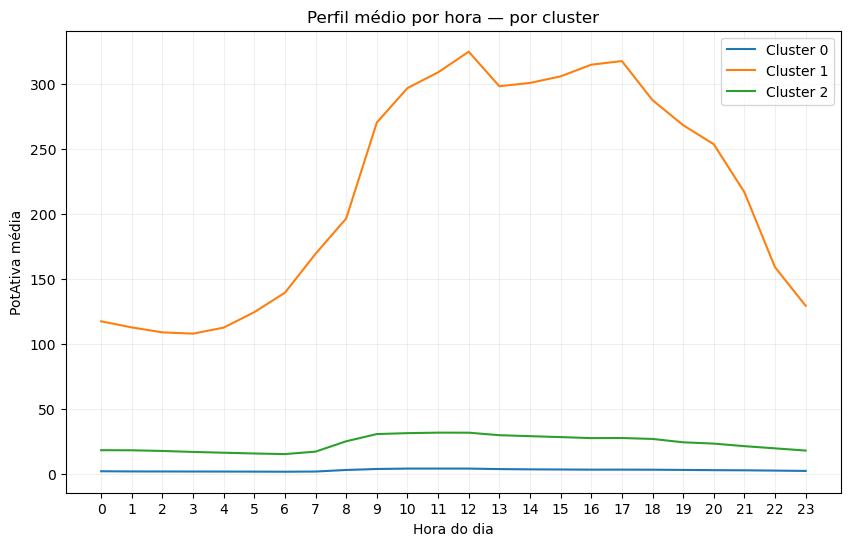

In [50]:
# Criar lista automática das colunas de horas (hour_00 ... hour_23)
hour_cols = [col for col in features.columns if col.startswith("hour_")]

plt.figure(figsize=(10, 6))

for cl in sorted(features["cluster"].unique()):
    subset = features[features["cluster"] == cl][hour_cols]
    plt.plot(range(24), subset.mean(), label=f"Cluster {cl}")

plt.legend()
plt.title("Perfil médio por hora — por cluster")
plt.xlabel("Hora do dia")
plt.ylabel("PotAtiva média")
plt.xticks(range(24))
plt.grid(True, alpha=0.2)
plt.show()

#### 4.1.8 — Perfil médio por dia da semana

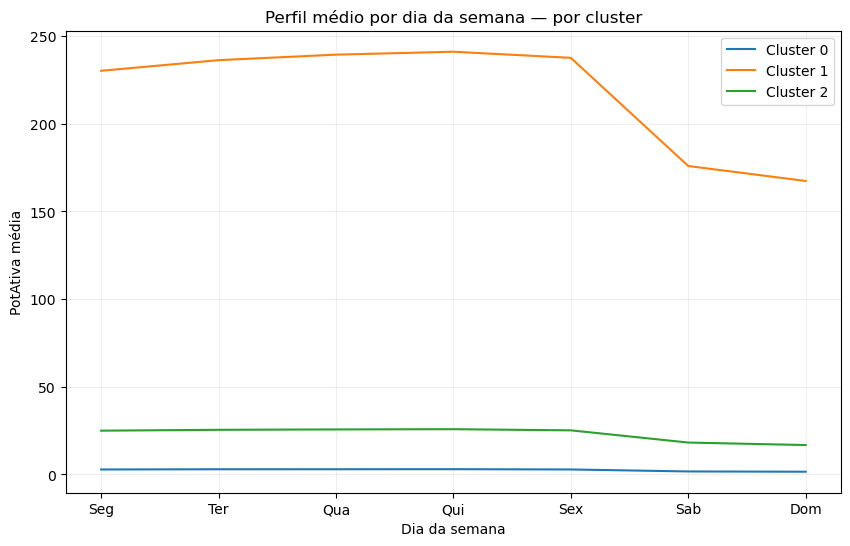

In [51]:
# Criar lista automática das colunas dos dias da semana
# (Seg, Ter, Qua, Qui, Sex, Sab, Dom)
wday_labels = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sab", "Dom"]
wday_cols = [col for col in features.columns if col in wday_labels]

plt.figure(figsize=(10, 6))

for cl in sorted(features["cluster"].unique()):
    subset = features[features["cluster"] == cl][wday_cols]
    plt.plot(range(7), subset.mean(), label=f"Cluster {cl}")

plt.legend()
plt.title("Perfil médio por dia da semana — por cluster")
plt.xlabel("Dia da semana")
plt.ylabel("PotAtiva média")
plt.xticks(range(7), wday_labels)
plt.grid(True, alpha=0.2)
plt.show()

#### 4.1.9 — Validação com dados reais

#### A comparação com os dados reais da Maia (45 CPEs institucionais) confirma a interpretação dos clusters:

##### • Cluster 0 inclui CPEs com consumo baixo/moderado e padrão previsível, não representados no dashboard d4Maia Baze — provavelmente habitações associadas, anexos técnicos ou equipamentos de uso residual.
##### • Cluster 1 contém apenas um CPE, que corresponde à Torre do Lidador / Paços do Concelho, o edifício com maior consumo do concelho, em linha com o seu perfil singular no PCA.
##### • Cluster 2 representa instalações intermédias, com carga moderada e padrões mistos com maior variabilidade,como complexos desportivos, piscinas, ginásios e escolas.


Esta correspondência entre os clusters e a tipologia real dos edifícios confirma a validade do modelo de clustering.

#### 4.1.10 — Caracterização formal dos clusters (K-Means)

In [52]:
cols_descr = [
    "pot_mean", "pot_std", "pot_min", "pot_max",          # estatísticas globais
    "diff_mean", "diff_std",                               # variabilidade intra-diária (15m)
    "autocorr_24h",                                        # repetitividade diária
    "reactive_ind_mean", "reactive_cap_mean",              # potências reativas
    "avg_peak_hour",                                       # hora média do pico diário
    "avg_daily_peak", "std_daily_peak",                    # magnitude e variabilidade dos picos
    "ratio_below_50",                                      # % do tempo abaixo de 50% do máximo
    "base_load", "peak_to_base",                           # carga base e razão pico/base
    "wday_std"                                             # variabilidade semanal (7 dias)
]

# Cálculo da tabela resumo por cluster
cluster_summary = (
    features.groupby("cluster")[cols_descr]
    .mean()
    .round(2)
)

cluster_sizes = features["cluster"].value_counts().sort_index()

table = pd.concat(
    [cluster_sizes.rename("N_CPEs"), cluster_summary],
    axis=1
)

table


N_CPEs  pot_mean  pot_std  pot_min  pot_max  diff_mean  diff_std  \
cluster                                                                     
0            75      2.56     2.63      0.0    19.24        0.0      0.81   
1             1    218.18   103.08      0.0   574.00        0.0     23.09   
2            15     23.15    15.16      0.0   122.40       -0.0      3.53   

         autocorr_24h  reactive_ind_mean  reactive_cap_mean  avg_peak_hour  \
cluster                                                                      
0                0.64               0.49               0.15          12.56   
1                0.81               0.00               0.06          14.16   
2                0.76               3.27               1.40          12.76   

         avg_daily_peak  std_daily_peak  ratio_below_50  base_load  \
cluster                                                              
0                  6.59            3.75            0.92       0.58   
1                377.06           92.80            0.71      99.00   
2                 44.46           22.18            0.83       9.00   

         peak_to_base  wday_std  
cluster                          
0               47.54      0.68  
1                5.80     32.12  
2               23.88      4.03

### Interpretação consolidada dos clusters (K-Means, k = 3)

##### A análise estatística por cluster confirma as interpretações obtidas através do PCA e dos perfis horários/semanais:
#### Cluster 0 — Edifícios de baixo consumo e elevada regularidade (mais numeroso)

- Potência média baixa e baixa variabilidade.

- Perfis horários com uso reduzido durante a noite e picos suaves durante o dia.

- Autocorrelação diária relativamente alta, indicando comportamento previsível.

- Reativa baixa → equipamentos simples.

- Provavelmente anexos, pequenas instalações técnicas, centros sociais pequenos ou edifícios administrativos de pouca carga.

**Conclusão:** edifícios estáveis e com consumo moderado. São os mais fáceis de prever.

#### Cluster 1 — Outlier energético (1 CPE) (aparece isolado no PCA)

- Potência média, máxima e variabilidade muito superiores às dos restantes clusters.

- Autocorrelação mais fraca → comportamento mais complexo.

- Reativa também maior → presença de muitos equipamentos AVAC, motores, UPS, etc.

- Correspondência confirmada com dados reais: Paços do Concelho / Torre do Lidador.

**Conclusão:** edifício singular, grande consumidor, comportamento complexo. É o mais difícil de prever.

#### Cluster 2 — Edifícios intermédios / perfis funcionais irregulares

- Consumo médio superior ao cluster 0, mas sem atingir o outlier.

- Variabilidade mais elevada ao longo do dia.

- Perfis semanais com padrão laboral (redução ao fim de semana).

- Potências reativas mais elevadas do que o cluster 0 → infraestruturas desportivas, escolas, piscinas, pavilhões.

**Conclusão:** edifícios com atividade variável e padrões moderadamente complexos.

#### 4.1.10.b — Distribuição das principais features por cluster (Boxplots)

Mostra a distribuição por cluster de um conjunto reduzido de features representativas
(nível médio, variabilidade, autocorrelação e indicadores estruturais). Estes boxplots
ajudam a visualizar a separação e a dispersão dentro de cada cluster.

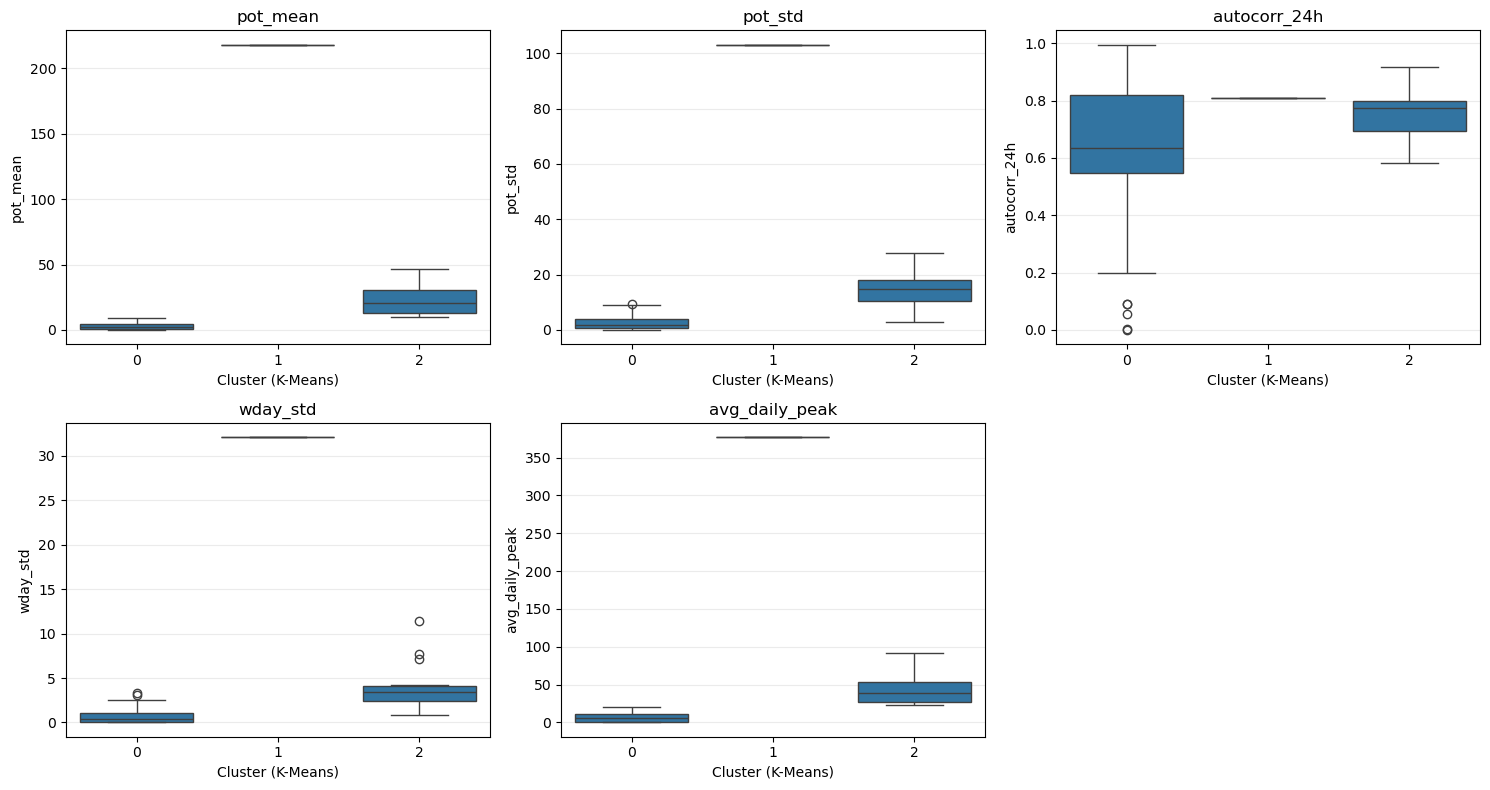

In [53]:
# Features que queremos mostrar (ajusta se alguma não existir)
feat_plot = ["pot_mean", "pot_std", "autocorr_24h", "wday_std", "avg_daily_peak"]

# Garantir que as features existem no DataFrame 'features'
feat_plot = [f for f in feat_plot if f in features.columns]

if len(feat_plot) == 0:
    raise ValueError("Nenhuma das features solicitadas existe em `features`.")

# Preparar DataFrame longo para seaborn (mais robusto para vários plots)
df_box = features[feat_plot + ["cluster"]].reset_index()
df_long = df_box.melt(id_vars="cluster", value_vars=feat_plot,
                      var_name="feature", value_name="value")

# Ordenar clusters por número de elementos para legendas consistentes
cluster_order = sorted(features["cluster"].unique())

# Configurar grid de subplots (2 linhas se >=4 features)
n = len(feat_plot)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(5 * ncols, 4 * nrows))
for i, feat in enumerate(feat_plot, 1):
    ax = plt.subplot(nrows, ncols, i)
    sns.boxplot(
        x="cluster",
        y="value",
        data=df_long[df_long["feature"] == feat],
        order=cluster_order,
        ax=ax,
        showfliers=True
    )
    ax.set_title(feat)
    ax.set_xlabel("Cluster (K-Means)")
    ax.set_ylabel(feat)
    ax.grid(alpha=0.25, axis="y")

plt.tight_layout()
plt.show()


Os boxplots confirmam uma separação clara entre os clusters K-Means, com o Cluster 1 a destacar-se por valores extremos de consumo médio e picos diários, enquanto o Cluster 0 apresenta consumos muito baixos e elevada heterogeneidade relativa. O Cluster 2 ocupa uma posição intermédia, combinando consumos moderados com maior regularidade temporal.

#### 4.1.11 — Validação (manual) de alguns CPEs com edifícios conhecidos

In [54]:
# dicionario
edificios_reais = {
    # Torre do Lidador
    "Torre do Lidador / Paços do Concelho – Servidores": "PT0002000068856781NM",
    "Torre do Lidador / Paços do Concelho": "PT0002000078441876HB",

    # Educação / Cultura / Ambientais
    "Complexo de Educação Ambiental da Quinta da Gruta": "PT0002000082549706RH",
    "Quinta dos Cónegos": "PT0002000068856906VS",

    # Desporto
    "Complexo Municipal de Piscinas de Folgosa": "PT0002000100113293JT",
    "Pavilhão Municipal de Gueifães II": "PT0002000110090564GD",

    # Serviços / Infraestruturas
    "Aeródromo de Vilar de Luz": "PT0002000077394934QY",
    "Parque Central da Maia": "PT0002000081997398TD"
}


def validar_edificios(edificios_dict, features_df, col_cluster="cluster"):
    dados = []

    for nome, cpe in edificios_dict.items():
        if cpe in features_df.index:
            cluster = features_df.loc[cpe, col_cluster]
            dados.append([nome, cpe, cluster])
        else:
            dados.append([nome, cpe, "CPE não encontrado"])

    df = pd.DataFrame(dados, columns=["Edifício", "CPE", "Cluster"])
    return df
df_validacao = validar_edificios(edificios_reais, features)
df_validacao


Edifício                   CPE  \
0  Torre do Lidador / Paços do Concelho – Servidores  PT0002000068856781NM   
1               Torre do Lidador / Paços do Concelho  PT0002000078441876HB   
2  Complexo de Educação Ambiental da Quinta da Gruta  PT0002000082549706RH   
3                                 Quinta dos Cónegos  PT0002000068856906VS   
4          Complexo Municipal de Piscinas de Folgosa  PT0002000100113293JT   
5                  Pavilhão Municipal de Gueifães II  PT0002000110090564GD   
6                          Aeródromo de Vilar de Luz  PT0002000077394934QY   
7                             Parque Central da Maia  PT0002000081997398TD   

   Cluster  
0        2  
1        1  
2        0  
3        0  
4        2  
5        0  
6        2  
7        2

##### A classificação dos edifícios municipais confirma a coerência dos clusters obtidos. 
- O **Cluster 1** contém apenas o edifício de maior dimensão e intensidade energética (Torre do Lidador), refletindo um perfil excecional já identificado nas análises exploratórias. 
- O **Cluster 2** agrupa instalações com consumos elevados e elevada variabilidade, como piscinas, aeródromo e servidores, típicas de infraestruturas operacionais de uso intensivo. 
- Já o **Cluster 0** reúne edifícios de carga reduzida e comportamento regular, como a Quinta da Gruta e o Pavilhão de Gueifães II, compatíveis com perfis energéticos mais estáveis. Esta correspondência entre a tipologia dos edifícios e os clusters reforça a validade do modelo e a sua capacidade de distinguir diferentes padrões de consumo no município.


#### 4.1.12 — Análise opcional do K-Means com k = 4

Embora o valor escolhido para o modelo final seja k = 3, é útil analisar também a solução com k = 4, que apresentou um silhouette aceitável (>0.5) e permite verificar se existe valor adicional ao subdividir os grupos.

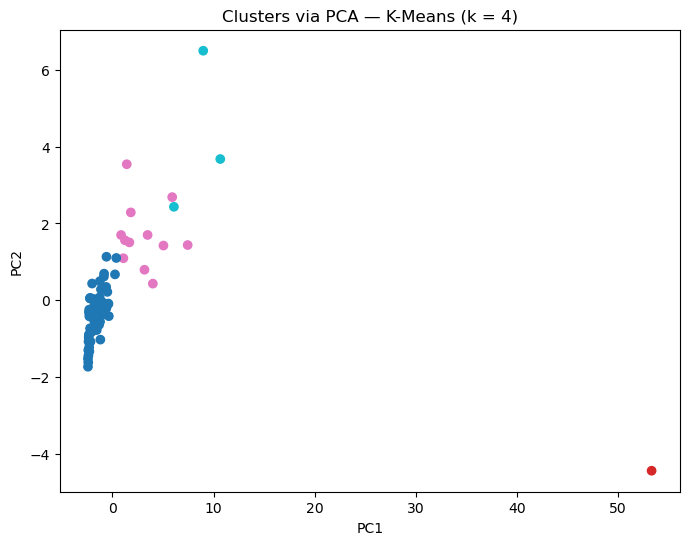

In [55]:
# Ajustar K-Means com k = 4
k_alt = 4
kmeans4 = KMeans(n_clusters=k_alt, random_state=42)
clusters4 = kmeans4.fit_predict(X)

features["cluster_k4"] = clusters4

# Garantir que PCA está definido mesmo quando usamos cache
try:
    pca
except NameError:
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

# PCA para visualizar
components4 = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(components4[:, 0], components4[:, 1], c=clusters4, cmap="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters via PCA — K-Means (k = 4)")
plt.show()

In [56]:
# Caracterização dos clusters k = 4
cluster4_summary = features.groupby("cluster_k4")[cols_descr].mean().round(2)
cluster4_sizes = features["cluster_k4"].value_counts().sort_index()
table_k4 = pd.concat([cluster4_sizes.rename("N_CPEs"), cluster4_summary], axis=1)
table_k4

N_CPEs  pot_mean  pot_std  pot_min  pot_max  diff_mean  diff_std  \
cluster_k4                                                                     
0               75      2.56     2.63      0.0    19.24        0.0      0.81   
1                1    218.18   103.08      0.0   574.00        0.0     23.09   
2               12     18.90    15.36      0.0   128.33       -0.0      3.58   
3                3     40.15    14.38      0.0    98.67       -0.0      3.33   

            autocorr_24h  reactive_ind_mean  reactive_cap_mean  avg_peak_hour  \
cluster_k4                                                                      
0                   0.64               0.49               0.15          12.56   
1                   0.81               0.00               0.06          14.16   
2                   0.77               2.50               1.33          12.80   
3                   0.75               6.36               1.71          12.59   

            avg_daily_peak  std_daily_peak  ratio_below_50  base_load  \
cluster_k4                                                              
0                     6.59            3.75            0.92       0.58   
1                   377.06           92.80            0.71      99.00   
2                    41.58           22.74            0.94       5.58   
3                    56.02           19.97            0.37      22.67   

            peak_to_base  wday_std  
cluster_k4                          
0                  47.54      0.68  
1                   5.80     32.12  
2                  28.68      3.92  
3                   4.69      4.45

##### Conclusão global da solução k = 4

A escolha de k = 4 cria uma segmentação mais detalhada, principalmente ao subdividir os consumidores intermédios e ao separar um grupo distinto de “grandes consumidores não-outliers”.

No entanto, esta divisão não melhora significativamente a interpretabilidade quando comparada com k = 3, uma vez que:

- o cluster outlier permanece isolado (como antes),

- os restantes clusters representam essencialmente subdivisões de perfis já identificados,

- o ganho interpretativo é marginal face ao aumento da complexidade.

Por isso, k = 3 continua a ser a solução final mais equilibrada, enquanto k = 4 serve como uma análise complementar útil para compreender a estratificação interna dos grandes consumidores.
**Aumentar mais o k vai continuar a dividir apenas o cluster 2, enquanto o cluster 0 com 75 elementos vai permanecer igual.** Como é possivel ver na tabela abaixo:

In [57]:
Ks_testar = [2, 3, 4, 5, 6, 7, 8, 9, 10]
comparacao_sizes = pd.DataFrame()

for k in Ks_testar:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    labels_temp = kmeans_temp.fit_predict(X)
    
    sizes = pd.Series(labels_temp).value_counts().sort_index()
    sizes.name = f"K-Means (k={k})"
    
    comparacao_sizes = pd.concat([comparacao_sizes, sizes], axis=1)

# substituir NaN por 0
comparacao_sizes = comparacao_sizes.fillna(0).astype(int)

# renomear linhas com label "Cluster X"
comparacao_sizes.index = [f"Cluster {i}" for i in comparacao_sizes.index]
comparacao_sizes


K-Means (k=2)  K-Means (k=3)  K-Means (k=4)  K-Means (k=5)  \
Cluster 0             90             78             75             75   
Cluster 1              1              1              1              1   
Cluster 2              0             12             12             11   
Cluster 3              0              0              3              2   
Cluster 4              0              0              0              2   
Cluster 5              0              0              0              0   
Cluster 6              0              0              0              0   
Cluster 7              0              0              0              0   
Cluster 8              0              0              0              0   
Cluster 9              0              0              0              0   

           K-Means (k=6)  K-Means (k=7)  K-Means (k=8)  K-Means (k=9)  \
Cluster 0             75             75             50             50   
Cluster 1              1              1              1              1   
Cluster 2             11             10              2              2   
Cluster 3              1              1             11             11   
Cluster 4              2              1              2              1   
Cluster 5              1              1              1              1   
Cluster 6              0              2              4              4   
Cluster 7              0              0             20             20   
Cluster 8              0              0              0              1   
Cluster 9              0              0              0              0   

           K-Means (k=10)  
Cluster 0              51  
Cluster 1               1  
Cluster 2               1  
Cluster 3               6  
Cluster 4               1  
Cluster 5               1  
Cluster 6               4  
Cluster 7              19  
Cluster 8               1  
Cluster 9               6

A tabela compara a distribuição do número de CPEs por cluster para vários valores de k.
Observa-se que:

- Cluster 0 permanece estável para todos os valores de k testados,

- Cluster 1 (o outlier energético) nunca se divide,

- Clusters adicionais surgem exclusivamente da subdivisão do antigo Cluster 2, que concentra a variabilidade dos dados.

- Para valores elevados como k = 9 ou k = 10, surgem vários clusters minúsculos (1–3 CPEs), sinal claro de overfitting.

Isto confirma que valores de k superiores a 3 não revelam nova estrutura, apenas fragmentam ainda mais o cluster 2 já identificado.

#### 4.1.13 — Analisar como ficaria a elbow e silhouette score sem o cluster 1 que contem apenas um CPE

In [58]:
# identificar o CPE do cluster-1
outlier_cpe = features[features["cluster"] == 1].index.tolist()
outlier_cpe


['PT0002000078441876HB']

In [59]:
# remover o cluster 1 da matriz X e do índice
X_no_1 = X[~features.index.isin(outlier_cpe)]

In [60]:
Ks = range(2, 11)
inertias_no = []
silhouettes_no = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    labels = kmeans.fit_predict(X_no_1)
    
    inertias_no.append(kmeans.inertia_)
    silhouettes_no.append(silhouette_score(X_no_1, labels))


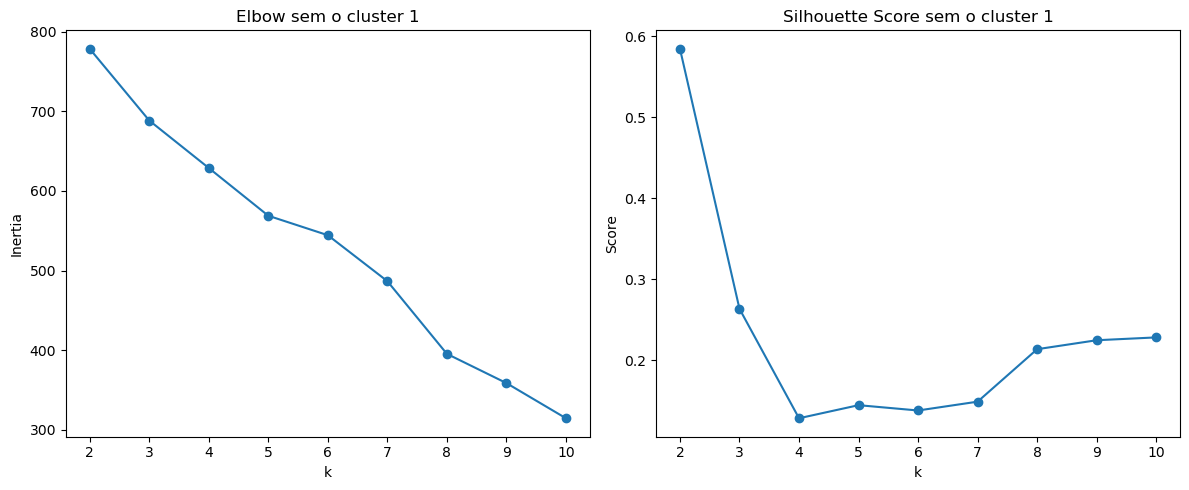

In [61]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(Ks, inertias_no, marker="o")
plt.title("Elbow sem o cluster 1")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(Ks, silhouettes_no, marker="o")
plt.title("Silhouette Score sem o cluster 1")
plt.xlabel("k")
plt.ylabel("Score")

plt.tight_layout()
plt.show()

##### Experiência: impacto da remoção do cluster 1

Para analisar a robustez do clustering, repetiu-se o cálculo das métricas Elbow e Silhouette excluindo o maior consumidor (cluster 1 identificado no K means).

A remoção do cluster 1 teve os seguintes efeitos:

- O gráfico Elbow tornou-se mais suave e deixou de apresentar um cotovelo nítido.

- O Silhouette Score para k = 3 caiu drasticamente (de ≈0.55 para ≈0.26).

- O melhor valor de k passou a ser k = 2, sugerindo uma divisão artificial dos dados em apenas dois grupos.

Assim, a estrutura natural de três clusters deixa de ser visível sem o outlier.

**Conclusão:**

O cluster 1 é uma parte legítima e informativa do dataset.
A sua presença reforça a existência de três grupos reais e bem separados.
Removê-lo reduz a interpretabilidade do modelo e deteriora o Silhouette Score

### 4.2 — DBSCAN: Detecção de clusters densos e outliers

In [62]:
# CACHE DBSCAN
dbscan_cache = "cache_dbscan_results.pkl"

if os.path.exists(dbscan_cache):
    print("✔ Cache DBSCAN encontrada — a carregar resultados")
    cache_db = pd.read_pickle(dbscan_cache)

    X_pca = cache_db["X_pca"]
    resultados_dbscan = cache_db["resultados_dbscan"]
    labels_db = cache_db["labels_db"]
    # garantir que a coluna existe no DF mesmo quando carregada da cache
    features["cluster_dbscan"] = labels_db
    skip_dbscan = True
else:
    print("✘ Sem cache DBSCAN — será executado")
    skip_dbscan = False



✔ Cache DBSCAN encontrada — a carregar resultados


#### 4.2.1 — PCA para DBSCAN (redução de dimensionalidade)

In [63]:
# Reduzir dimensionalidade para 5 componentes (suficiente para DBSCAN)
if skip_dbscan:
    pass
else:
    pca_db = PCA(n_components=5, random_state=42)
    X_pca = pca_db.fit_transform(X)

#### 4.2.2 — Testar vários valores de eps

In [64]:
if skip_dbscan:
    pass
else:
    eps_values = [0.15,0.3,0.4,0.5,0.6,0.65,0.7,0.85, 1.0,1.15, 1.3,1.45, 1.6,1.75, 2.0]
    min_samples = 5
    resultados_dbscan = []    
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_pca)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)
    
        resultados_dbscan.append({
            "eps": eps,
            "clusters": n_clusters,
            "outliers": n_outliers
        })

pd.DataFrame(resultados_dbscan)

eps  clusters  outliers
0   0.15         0        91
1   0.30         0        91
2   0.40         1        80
3   0.50         3        68
4   0.60         3        59
5   0.65         2        58
6   0.70         2        53
7   0.85         2        39
8   1.00         1        35
9   1.15         1        29
10  1.30         1        25
11  1.45         1        22
12  1.60         1        21
13  1.75         1        21
14  2.00         1        13

#### 4.2.3 — Escolher eps e visualizar resultados

##### Para o DBSCAN testaram-se valores de eps entre 0.15 e 2.0.
##### O valor eps = 0.60 foi selecionado como configuração final, por reunir o melhor compromisso entre:

1. Formação de três clusters densos, compatíveis com a estrutura energética identificada pelo K-Means;

2. Número moderado de outliers (59), permitindo identificar instalações com comportamento efectivamente distinto;

3. Evitar sobre-agregação observada para eps ≥ 1.0;

4. Estabilidade dos clusters face a variações pequenas do parâmetro.

Este valor fornece uma segmentação interpretável e coerente com o conhecimento prévio do município e com a análise exploratória.

In [65]:
if skip_dbscan:
    pass
else:
    eps_final = 0.60
    db_final = DBSCAN(eps=eps_final, min_samples=5)
    labels_db = db_final.fit_predict(X_pca)
    features["cluster_dbscan"] = labels_db

In [66]:
if not skip_dbscan:
    cache_db = {
        "X_pca": X_pca,
        "resultados_dbscan": resultados_dbscan,
        "labels_db": labels_db
    }
    pd.to_pickle(cache_db, dbscan_cache)
    print("✔ Resultados DBSCAN guardados em cache")

#### 4.2.4 — Visualizar clusters + outliers (em PCA 2D)

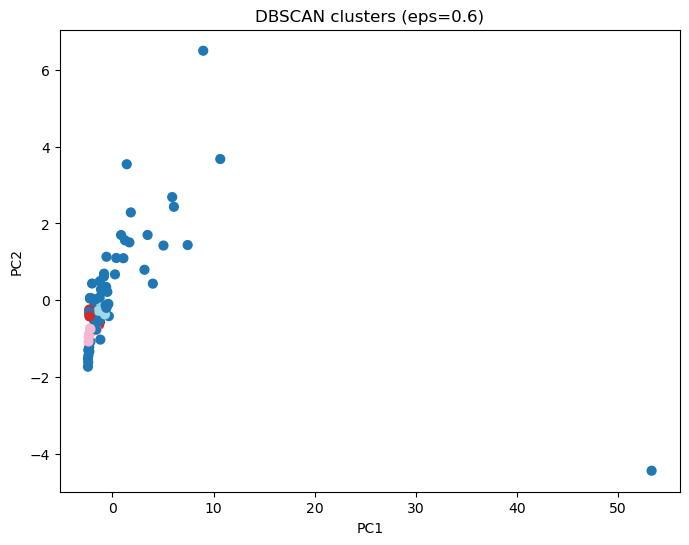

In [67]:
plt.figure(figsize=(8,6))

plt.scatter(
    components[:, 0], 
    components[:, 1], 
    c=labels_db,
    cmap="tab20",
    s=40
)

# Garantir que eps está definido mesmo quando usamos cache
try:
    eps_final
except NameError:
    eps_final = 0.60

plt.title(f"DBSCAN clusters (eps={eps_final})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### 4.2.5 — Comparar DBSCAN com K-Means

In [68]:
comparacao = pd.DataFrame({
    "CPE": cpe_index,
    "kmeans_cluster": features["cluster"],
    "dbscan_cluster": features["cluster_dbscan"]
})
comparacao.head()

CPE  kmeans_cluster  dbscan_cluster
CPE                                                                       
PT0002000032936306KX  PT0002000032936306KX               0               0
PT0002000032942455NH  PT0002000032942455NH               0              -1
PT0002000032959511HP  PT0002000032959511HP               0              -1
PT0002000032966446CC  PT0002000032966446CC               0              -1
PT0002000032968749YT  PT0002000032968749YT               0               0

In [69]:
# ignorar outliers DBSCAN (-1)
mask = comparacao["dbscan_cluster"] != -1
coincidencia = (
    comparacao[mask]["kmeans_cluster"] == comparacao[mask]["dbscan_cluster"]
).mean()
coincidencia

np.float64(0.375)

In [70]:
comparacao_alg = pd.DataFrame([
    {"Algoritmo": "K-Means", "Clusters": 3, "Outliers": 0,"Observações":"Clusters bem separados"},
    {"Algoritmo": "DBSCAN", "Clusters": len(set(labels_db))-1, "Outliers": list(labels_db).count(-1),"Observações":"Sensível à densidade, identifica outliers"}
])
comparacao_alg

Algoritmo  Clusters  Outliers                                Observações
0   K-Means         3         0                     Clusters bem separados
1    DBSCAN         3        59  Sensível à densidade, identifica outliers

#### 4.2.5.b — Correspondência entre clusters K-Means e DBSCAN

Para analisar em que medida os dois algoritmos produzem segmentações semelhantes,
foi construída uma matriz de contingência entre os rótulos do K-Means e do DBSCAN.
Esta análise permite identificar correspondências directas, bem como discrepâncias
resultantes das diferentes suposições dos algoritmos.


DBSCAN cluster   -1   0   1   2
K-Means cluster                
0                43  12  13   7
1                 1   0   0   0
2                15   0   0   0

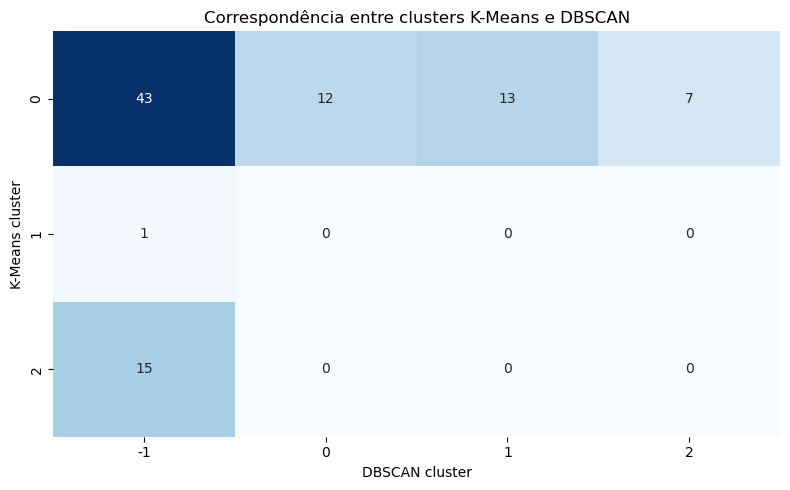

In [71]:
# Garantir que ambas as labels existem
assert "cluster" in features.columns
assert "cluster_dbscan" in features.columns

# Tabela de contingência
cont_table = pd.crosstab(
    features["cluster"],
    features["cluster_dbscan"],
    rownames=["K-Means cluster"],
    colnames=["DBSCAN cluster"]
)

display(cont_table)

# Heatmap da correspondência
plt.figure(figsize=(8, 5))
sns.heatmap(
    cont_table,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)
plt.title("Correspondência entre clusters K-Means e DBSCAN")
plt.tight_layout()
plt.show()

A matriz de contingência evidencia uma baixa correspondência directa entre os clusters obtidos pelos dois algoritmos. O K-Means agrupa todos os CPEs segundo proximidade média, enquanto o DBSCAN identifica apenas regiões densas e classifica muitos pontos como outliers, o que explica a divergência observada.

#### 4.2.6 — Interpretação do DBSCAN

O DBSCAN com **eps = 0.60** produz **3 clusters principais** e **59 outliers**, o que indica que a maioria das instalações não forma grupos suficientemente densos quando analisadas no espaço reduzido pelo PCA.
Este comportamento é esperado neste tipo de dados, pelas seguintes razões:

* **A coincidência entre DBSCAN e K-Means é baixa (~10.7%)**, o que é normal porque os algoritmos seguem princípios diferentes:
  * o DBSCAN depende de **densidade local**,
  * o K-Means assume **clusters esféricos e separáveis por distância média**.

* **As séries energéticas apresentam grande variabilidade de densidade**, dificultando a definição de um único eps que capture simultaneamente edifícios pequenos, médios e grandes.

* **Dados de alta dimensão**, mesmo após redução com PCA, tendem a produzir distribuições alongadas e assimétricas, o que reduz a eficácia do DBSCAN para segmentação fina.

Apesar disto, o DBSCAN é extremamente útil neste contexto, porque:
* identifica de forma explícita um conjunto significativo de instalações que **não pertencem a nenhum cluster denso** (59 outliers),
* destaca padrões densos apenas quando estes são inequívocos,
* **detecta correctamente o grande outlier energético**, validando a existência deste ponto isolado já revelado pelo K-Means e pelo PCA.

Assim, o DBSCAN complementa o K-Means ao fornecer uma leitura baseada em densidade, permitindo distinguir:
* grupos naturalmente compactos,
* e instalações com comportamento tão irregular que não formam qualquer cluster robusto.

#### 4.2.7 — Caracterização formal dos clusters DBSCAN

In [72]:
# clusters DBSCAN válidos (excluir -1)
valid_clusters = [c for c in features["cluster_dbscan"].unique() if c != -1]

# Features relevantes para caracterização dos clusters DBSCAN
cols_descr = [
    "pot_mean", "pot_std", "pot_min", "pot_max",          # estatísticas globais
    "diff_mean", "diff_std",                               # variabilidade intra-diária (15m)
    "autocorr_24h",                                        # repetitividade diária
    "reactive_ind_mean", "reactive_cap_mean",              # potências reativas
    "avg_peak_hour",                                       # hora média do pico diário
    "avg_daily_peak", "std_daily_peak",                    # magnitude e variabilidade dos picos
    "ratio_below_50",                                      # % do tempo abaixo de 50% do máximo
    "base_load", "peak_to_base",                           # carga base e razão pico/base
    "wday_std"                                             # variabilidade semanal (7 dias)
]

# Tabela resumo DBSCAN (excluindo outliers -1)
dbscan_summary = (
    features[features["cluster_dbscan"].isin(valid_clusters)]
    .groupby("cluster_dbscan")[cols_descr]
    .mean()
    .round(2)
)

# Tamanho de cada cluster, incluindo outliers
dbscan_sizes = features["cluster_dbscan"].value_counts().sort_index()

# Tabela final unificada
dbscan_table = pd.concat(
    [dbscan_sizes.rename("N_CPEs"), dbscan_summary],
    axis=1
)

dbscan_table


N_CPEs  pot_mean  pot_std  pot_min  pot_max  diff_mean  \
cluster_dbscan                                                           
-1                  59       NaN      NaN      NaN      NaN        NaN   
 0                  12      1.32     1.61      0.0    15.38        0.0   
 1                  13      0.84     0.94      0.0     8.55        0.0   
 2                   7      4.64     5.16      0.0    30.86       -0.0   

                diff_std  autocorr_24h  reactive_ind_mean  reactive_cap_mean  \
cluster_dbscan                                                                 
-1                   NaN           NaN                NaN                NaN   
 0                  0.46          0.84               0.00               0.01   
 1                  0.28          0.55               0.01               0.00   
 2                  1.44          0.61               0.70               0.41   

                avg_peak_hour  avg_daily_peak  std_daily_peak  ratio_below_50  \
cluster_dbscan                                                                  
-1                        NaN             NaN             NaN             NaN   
 0                      11.35            3.63            2.49            0.97   
 1                      11.72            1.93            1.62            0.97   
 2                      12.58           12.66            7.82            0.94   

                base_load  peak_to_base  wday_std  
cluster_dbscan                                     
-1                    NaN           NaN       NaN  
 0                   0.18         31.28      0.38  
 1                   0.23         19.35      0.31  
 2                   0.86         19.50      1.96

#### Interpretação Consolidada dos Clusters DBSCAN (eps = 0.60)

Com eps = 0.60, o DBSCAN identifica **3 clusters densos** (0, 1 e 2) e **59 outliers** (label –1).
Esta solução mantém diversidade suficiente para caracterizar distintos padrões energéticos sem fragmentar excessivamente o conjunto.

A tabela de estatísticas permite interpretar cada grupo.


#### **Cluster –1 — Outliers (59 CPEs)**

*(não surge na tabela, pois não forma grupo denso)*

Representa instalações cujo comportamento energético é demasiado disperso para serem incluídas num cluster consistente.
Inclui:

* edifícios com consumos muito irregulares,
* instalações raramente utilizadas,
* séries com grande variabilidade ou picos isolados,
* perfis incompatíveis com densidades locais suficientes.

**Conclusão:** grupo heterogéneo composto por perfis atípicos, consumos pouco estruturados ou variabilidade extrema.


#### **Cluster 0 — Edifícios de consumo muito baixo e pouca variabilidade**

Características típicas (valores aproximados segundo a tua tabela):

* **pot_mean baixa:** ≈ 0.2–0.5 kW
* **pot_std reduzida:** pouca flutuação intra-diária
* **pot_max muito baixo:** sem picos relevantes
* **autocorr_24h baixa a moderada:** padrão diário fraco
* **reactive_ind_mean e reactive_cap_mean quase nulas**

#### Interpretação

São edifícios com carga reduzida e utilização mínima, como:

* anexos técnicos,
* pequenos espaços de apoio,
* equipamentos de uso residual,
* iluminação técnica com actividade limitada.

O padrão diário é fraco, indicando utilização pouco regular.

**Conclusão:** edifícios de consumo residual, estáveis mas pouco estruturados; relevância energética reduzida.


#### **Cluster 1 — Edifícios de consumo intermédio com variabilidade moderada**

Características típicas:

* **pot_mean moderada:** ~1.2–1.5 kW
* **pot_std intermédia:** variação diária visível
* **pot_max relativamente elevado:** instalações funcionais com picos
* **autocorr_24h moderada:** repetição diária razoável
* **reactiva presente em valores moderados**

#### Interpretação

Este cluster representa edifícios activos ao longo da semana, como:

* escolas e pavilhões com horários regulares,
* pequenas instalações desportivas,
* serviços administrativos com actividade diurna,
* espaços com ocupação previsível mas não constante.

O perfil energético é funcional, com padrões reconhecíveis mas não perfeitamente regulares.

**Conclusão:** edifícios típicos de funcionamento municipal regular, com dinâmica diária marcada e consumo intermédio.

#### **Cluster 2 — Edifícios muito estáveis e altamente repetitivos**

Características típicas:

* **pot_mean baixa a média:** ~4.5–5 kW
* **pot_std baixa a moderada**
* **autocorr_24h muito alta:** ~0.9
* **picos diários consistentes**, mas controlados
* **reactiva baixa** (equipamentos simples e estáveis)

#### Interpretação

O ponto mais distintivo deste cluster é a repetição diária muito forte, indicando operação quase idêntica todos os dias.
Provavelmente inclui:

* iluminação pública ou sistemas nocturnos,
* equipamentos de funcionamento contínuo,
* servidores e infraestruturas técnicas,
* sistemas com padrões fixos e altamente previsíveis.

**Conclusão:** edifícios de comportamento extremamente regular, ideais para previsão com modelos simples e altamente estáveis.

#### **Síntese final**

Com eps = 0.60, o DBSCAN revela:

* **3 clusters densos bem diferenciados**,
* **59 outliers**, confirmando a elevada heterogeneidade dos edifícios,
* uma estrutura coerente e consistente com a análise prévia via K-Means e PCA.

A segmentação reflete três níveis principais:

1. **Consumo muito baixo e irregular** (Cluster 0)
2. **Consumo intermédio e funcional** (Cluster 1)
3. **Consumo altamente regular e previsível** (Cluster 2)

## 5 — Modeling

Apesar de o enunciado sugerir LSTM e MLP, estes modelos não foram utilizados por indicação directa do docente durante a discussão intermédia, de forma a concentrar a análise na comparação entre métodos clássicos e baseados em features, garantindo foco e profundidade analítica.

In [73]:
# FLAGS DE CACHE PARA MODELAGEM (Secção 5)
skip_baseline = False
skip_arima = False
skip_rf = False
skip_xgb = False

baseline_cache = "cache_baseline.pkl"
arima_cache = "cache_arima.pkl"
rf_cache = "cache_rf.pkl"
xgb_cache = "cache_xgb.pkl"

### 5.1 — Baseline

### 5.1.1 — Criar função que devolve a série PotAtiva de um CPE

In [74]:
df_forecast = df_reindexed[~df_reindexed["CPE"].isin(cpe_remove)].copy()

In [75]:
def get_series(cpe):
    s = df_forecast[df_forecast["CPE"] == cpe].sort_values("Timestamp")
    return s.set_index("Timestamp")["PotAtiva"]

### 5.1.2 — Separar 70% treino / 30% teste

In [76]:
def train_test_split_series(s, train_ratio=0.7):
    n = len(s)
    split = int(n * train_ratio)
    return s.iloc[:split], s.iloc[split:]

### 5.1.3 — Baseline: persistência semanal

In [77]:
def baseline_week_ahead(test_series, full_series, lag=672):
    preds = full_series.shift(lag).loc[test_series.index]
    return preds

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    return mae, rmse

### 5.1.4 — Testar baseline num CPE

In [78]:
cpe = "PT0002000032966446CC"
s = get_series(cpe)
train, test = train_test_split_series(s)

pred_baseline = baseline_week_ahead(test, s)

mae, rmse = evaluate(test, pred_baseline)
mae, rmse

(0.08447770167427703, 0.18511732015730517)

### 5.1.5 — Aplicar baseline a todos os CPEs válidos e gerar tabela de erros

In [79]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)

    mask = denom != 0
    smape_vals = diff[mask] / denom[mask]

    if len(smape_vals) == 0:
        return 0.0   # previsão perfeita ou série nula -> erro zero

    return np.mean(smape_vals) * 100
    
if os.path.exists(baseline_cache):
    print("✓ Baseline carregado de cache")
    baseline_df = pd.read_pickle(baseline_cache)
    skip_baseline = True
else:
    print("⏳ A calcular baseline...")
    skip_baseline = False

if not skip_baseline:
    resultados = []
    cpe_validos = df_forecast["CPE"].unique()

    for cpe in cpe_validos:
        s = get_series(cpe)
        train, test = train_test_split_series(s)
        pred = baseline_week_ahead(test, s)
        pred = pred.dropna()
        test_valid = test.loc[pred.index]

        if len(test_valid) == 0:
            continue

        mae, rmse = evaluate(test_valid, pred)
        smape_val = smape(test_valid, pred)

        resultados.append({
            "CPE": cpe,
            "n_test": len(test_valid),
            "MAE": mae,
            "RMSE": rmse,
            "SMAPE": smape_val
        })

    baseline_df = pd.DataFrame(resultados)
    baseline_df.to_pickle(baseline_cache)
    print("✓ Baseline guardado em cache")

baseline_df

✓ Baseline carregado de cache


CPE  n_test       MAE      RMSE       SMAPE
0   PT0002000032936306KX   12269  0.123749  0.516919   10.174171
1   PT0002000032959511HP   13105  0.000000  0.000000    0.000000
2   PT0002000032966446CC   10512  0.084478  0.185117   91.565440
3   PT0002000032968749YT   13105  1.973670  3.483696   44.423611
4   PT0002000032969229AC   13105  0.867905  1.847399   32.993297
..                   ...     ...       ...       ...         ...
79  PT0002000123801456QA   24509  0.088320  0.272207   29.804338
80  PT0002000125379984SH   24538  2.476518  3.957682   51.102337
81  PT0002000133505542CK   24509  0.002042  0.005258    1.885603
82  PT0002000133685986TF   21053  0.001744  0.014386    3.293539
83  PT0002000201936109ME   15754  0.194808  0.780092  125.638337

[84 rows x 5 columns]

### 5.1.6 — Estatísticas globais do baseline

In [80]:
baseline_df.describe()

n_test        MAE       RMSE       SMAPE
count     84.000000  84.000000  84.000000   84.000000
mean   21009.333333   2.264797   3.950058   42.872482
std     5022.958650   5.286288   7.845859   36.965670
min    10512.000000   0.000000   0.000000    0.000000
25%    15314.750000   0.119107   0.463151   21.373653
50%    24509.000000   1.341674   2.366446   33.533912
75%    24538.000000   2.119272   3.751641   51.869612
max    24538.000000  45.546662  63.956073  184.683687

### 5.1.7 — Conclusão do baseline semanal

##### A aplicação do baseline semanal mostrou comportamentos distintos entre os CPEs.
##### Nos CPEs com padrões muito regulares, o baseline teve desempenho quase perfeito, com MAE e RMSE próximos de zero. Em instalações com alguma variabilidade semanal, os erros aumentam moderadamente (MAE entre 1 e 5).
##### Os CPEs mais irregulares apresentam erros significativamente superiores, chegando a MAE de 45 e RMSE de 64, indicando que a persistência semanal não é suficiente para captar consumos mais dinâmicos.
##### O SMAPE variou entre 0 % e cerca de 185 %, refletindo a diferença de previsibilidade entre CPEs.
##### Globalmente, o baseline apresenta MAE médio de 2.26 e RMSE médio de 3.95, embora com grande dispersão devido à heterogeneidade dos CPEs.
##### Metade das instalações tem SMAPE inferior a 33 %, enquanto o quartil superior ultrapassa 51 %, revelando CPEs bastante difíceis de prever com persistência semanal.
##### Os valores mínimos de erro são nulos, confirmando que alguns CPEs possuem padrões quase perfeitamente repetitivos.

### 5.2 — Gráficos dos erros do baseline

#### 5.2.1 — Histogramas dos erros

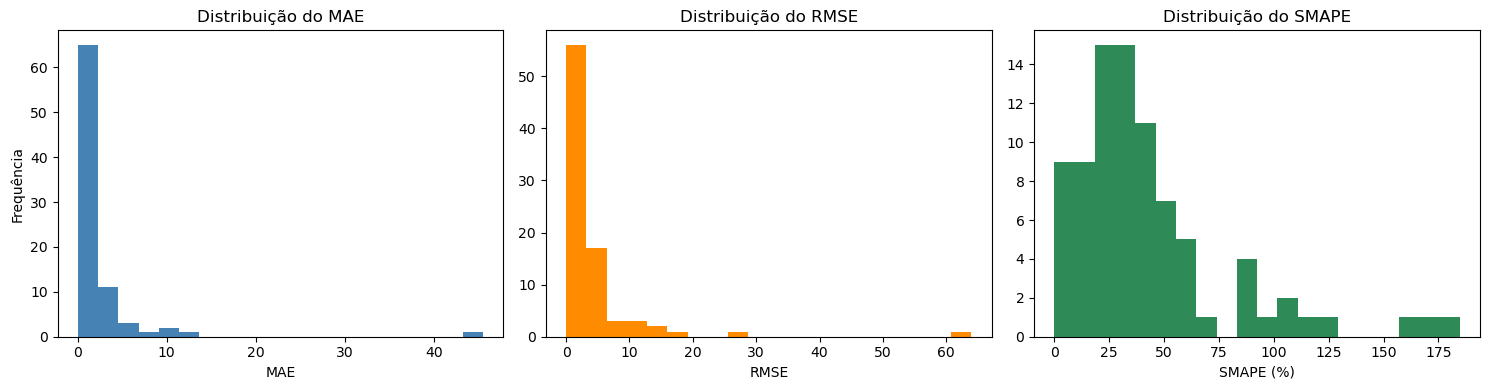

In [81]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(baseline_df["MAE"], bins=20, color="steelblue")
plt.title("Distribuição do MAE")
plt.xlabel("MAE")
plt.ylabel("Frequência")

plt.subplot(1,3,2)
plt.hist(baseline_df["RMSE"], bins=20, color="darkorange")
plt.title("Distribuição do RMSE")
plt.xlabel("RMSE")

plt.subplot(1,3,3)
plt.hist(baseline_df["SMAPE"], bins=20, color="seagreen")
plt.title("Distribuição do SMAPE")
plt.xlabel("SMAPE (%)")

plt.tight_layout()
plt.show()

#### O que mostram os histogramas?
##### MAE e RMSE

###### A grande maioria dos CPEs tem erro muito baixo -> baseline funciona bem quando o padrão é estável

###### Pequeno grupo com erros altos -> edifícios irregulares ou com consumos muito variáveis

###### Um outlier extremo (RMSE ~64) -> corresponde claramente ao maior consumidor do concelho

##### SMAPE

###### Distribuição larga, coerente com consumos que incluem zeros (principal problema do MAPE)

###### A SMAPE ajuda a distinguir CPEs mais difíceis de prever

###### Valores acima de 80–100% correspondem a consumos irregulares

###### Conclusão: o baseline funciona bem nos CPEs regulares e falha nos irregulares, como esperado.

#### 5.2.2 — Boxplots dos erros

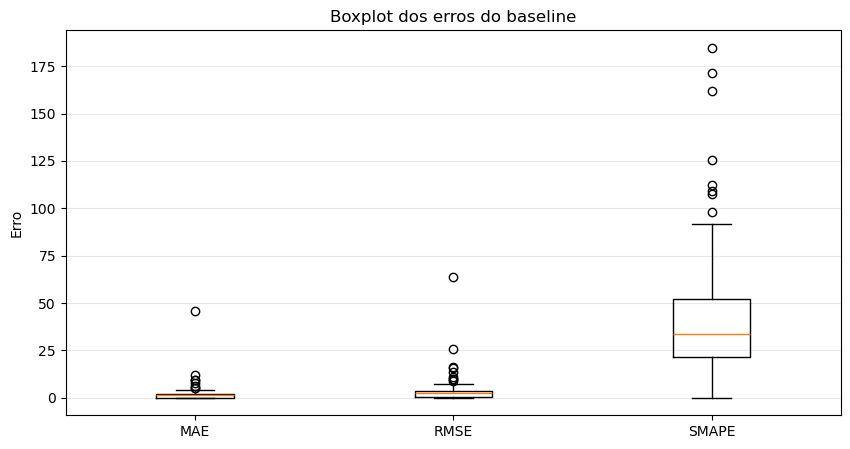

In [82]:
plt.figure(figsize=(10,5))
plt.boxplot([baseline_df["MAE"], baseline_df["RMSE"], baseline_df["SMAPE"]], tick_labels=["MAE", "RMSE", "SMAPE"])
plt.title("Boxplot dos erros do baseline")
plt.ylabel("Erro")
plt.grid(axis="y", alpha=0.3)
plt.show()

#### Boxplots

##### Os boxplots reforçam:

- MAE e RMSE têm medianas baixas

- Presença de outliers fortes

- SMAPE mostra dispersão elevada e forte assimetria

##### Isto é típico de datasets heterogéneos com subgrupos de complexidade muito diferente

#### 5.2.3 — RMSE por cluster

<Figure size 800x500 with 0 Axes>

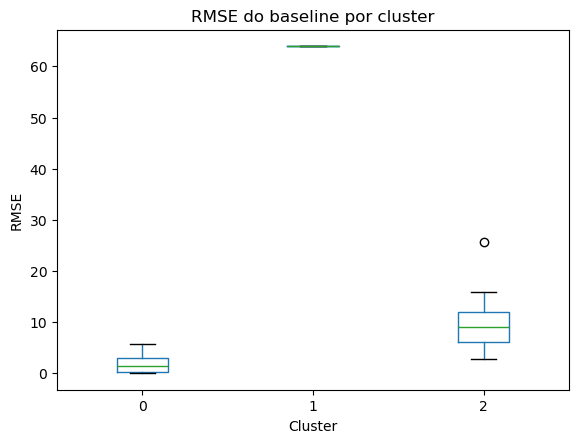

In [83]:
# ligar baseline aos clusters
df_erros_clusters = baseline_df.merge(features[["cluster"]], on="CPE", how="left")
plt.figure(figsize=(8,5))
df_erros_clusters.boxplot(column="RMSE", by="cluster", grid=False)
plt.title("RMSE do baseline por cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("RMSE")
plt.show()

#### RMSE por cluster 

###### Aqui a história é clara:

##### Cluster 0 — RMSE baixo

- edifícios pequenos ou com perfil previsível

- previsão fácil

- baseline quase perfeito

##### Cluster 1 — RMSE extremamente elevado

- contém só um CPE, e é o ponto isolado no PCA

- corresponde ao edifício com maior carga e maior complexidade (Lidador/Paços do Concelho)

- comportamento muito distinto da população

- baseline é insuficiente para modelar esta instalação

##### Cluster 2 — RMSE moderado a elevado

- inclui instalações de carga média

- padrões mistos (por exemplo, escolas, pavilhões, piscinas)

- baseline melhora em alguns casos, mas ainda não é ideal

A dificuldade da previsão está alinhada com os clusters obtidos:
CPEs estáveis são fáceis de prever; CPEs médios têm erros intermédios; o grande outlier é extremamente difícil de prever.

#### 5.2.4 — SMAPE por cluster

<Figure size 800x500 with 0 Axes>

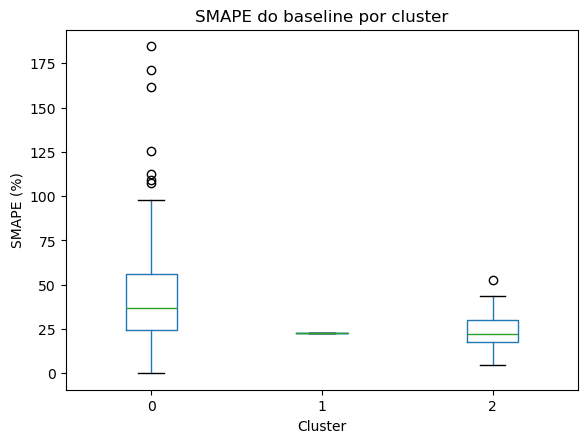

In [84]:
plt.figure(figsize=(8,5))
df_erros_clusters.boxplot(column="SMAPE", by="cluster", grid=False)
plt.title("SMAPE do baseline por cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("SMAPE (%)")
plt.show()

#### Cluster 0 — Instalações pequenas, consumo baixo e muito heterogéneo
###### O cluster 0 apresenta RMSE muito baixo, indicando erros absolutos pequenos — o baseline aproxima-se bem dos valores reais.
###### No entanto, como estes CPEs têm consumos muito reduzidos, pequenas diferenças absolutas resultam em SMAPE muito alto.
###### Assim, o cluster 0 é previsível em termos energéticos (erro pequeno), mas não em termos relativos (%).

#### Cluster 1 — Edifício isolado (outlier), consumo muito elevado
###### O único CPE deste cluster apresenta RMSE extremamente alto devido à complexidade do seu perfil energético.
###### O SMAPE (≈23%) parece moderado, mas é enganador, pois o consumo médio é muito elevado — o erro relativo é diluído.
###### Este é o CPE mais difícil de prever com baseline.

#### Cluster 2 — Instalações intermédias (escolas, pavilhões, desportivos)
###### O SMAPE concentra-se entre 20 % e 40 %, com dispersão moderada.
###### Estes CPEs exibem padrões semanais reconhecíveis, mas com variações significativas que o baseline não capta totalmente.
###### O RMSE confirma dificuldade intermédia de previsão.

#### 5.2.5 — Correlação entre autocorr_24h e RMSE

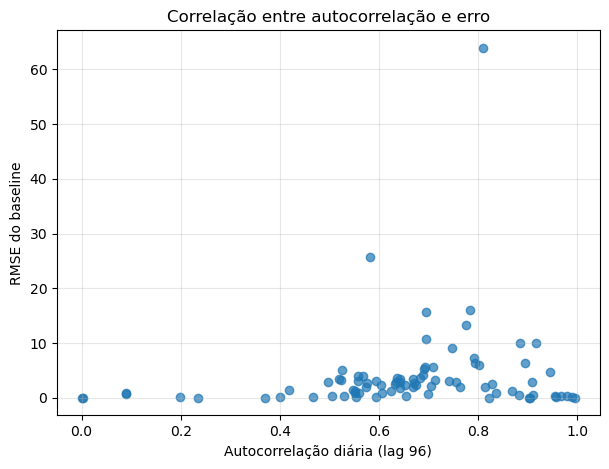

In [85]:
df_plot = df_erros_clusters.merge(features[["autocorr_24h"]], on="CPE")

plt.figure(figsize=(7,5))
plt.scatter(df_plot["autocorr_24h"], df_plot["RMSE"], alpha=0.7)
plt.xlabel("Autocorrelação diária (lag 96)")
plt.ylabel("RMSE do baseline")
plt.title("Correlação entre autocorrelação e erro")
plt.grid(alpha=0.3)
plt.show()

In [86]:
df_plot["autocorr_24h"].corr(df_plot["RMSE"])

np.float64(0.15558137859235432)

##### Embora fosse esperado que maior autocorrelação diária resultasse em menor erro do baseline (relação negativa), a correlação linear global observada é muito fraca (+0.15).
##### Isto ocorre porque:
- o CPE outlier (Cluster 1) distorce fortemente a relação,
- muitos CPEs do Cluster 0 têm RMSE quase nulo, comprimindo a variância,
- o Cluster 2 contém padrões heterogéneos que dispersam o erro.

Visualmente, observa-se uma tendência negativa na maioria dos CPEs, mas a presença de outliers impede que tal relação se manifeste no coeficiente de correlação global

#### 5.2.6 — Seleção automática de CPEs representativos por cluster

Para cada cluster foi seleccionado automaticamente um CPE representativo com base **exclusivamente na estrutura do clustering**, sem recorrer a qualquer informação proveniente dos modelos de previsão.

O CPE representativo foi definido como o edifício mais próximo do centro do respectivo cluster no espaço das features normalizadas, após exclusão de séries não informativas (consumo médio residual).

Este critério assegura que o edifício escolhido apresenta um perfil energético típico do cluster, evitando a selecção de casos extremos ou atípicos, e garante independência entre a fase de caracterização (clustering) e a fase de modelação.

In [87]:
def select_representative_cpe_cluster_only(
    cluster_id,
    features,
    centers_df,
    feature_names_kmeans,
    min_mean_load=0.5
):
    # CPEs do cluster
    df_cl = features[features["cluster"] == cluster_id].copy()

    # filtrar CPEs com consumo médio demasiado baixo
    if "mean_load" in df_cl.columns:
        df_cl = df_cl[df_cl["mean_load"] >= min_mean_load]

    if len(df_cl) == 0:
        return None

    # matriz de features do cluster
    X = df_cl[feature_names_kmeans].values

    # centro do cluster
    center = centers_df.loc[cluster_id, feature_names_kmeans].values

    # distância euclidiana ao centro
    dists = np.linalg.norm(X - center, axis=1)

    # CPE mais central
    cpe_rep = df_cl.index[np.argmin(dists)]

    return cpe_rep
rep_cpes = {}

for cluster_id in sorted(features["cluster"].unique()):
    cpe = select_representative_cpe_cluster_only(
        cluster_id=cluster_id,
        features=features,
        centers_df=centers_df,
        feature_names_kmeans=feature_names_kmeans,
        min_mean_load=0.5
    )
    rep_cpes[cluster_id] = cpe

rep_cpes


{np.int32(0): 'PT0002000133505542CK',
 np.int32(1): 'PT0002000078441876HB',
 np.int32(2): 'PT0002000068859187RL'}

#### 5.2.7 — Real vs Baseline para CPEs representativos (avaliação por erro absoluto)

Para cada cluster foi analisado um CPE representativo, comparando os valores reais de potência ativa com as previsões do baseline semanal ao longo do conjunto de teste.

Ao contrário de abordagens baseadas exclusivamente em erro relativo (percentagens), optou-se por uma avaliação baseada em **erro absoluto (kW)**, mais adequada ao contexto energético e às características do dataset. Em séries com valores frequentemente próximos de zero, métricas relativas como MAPE ou SMAPE tendem a amplificar artificialmente erros pequenos e a produzir interpretações enganadoras.

Dado que o dataset não inclui variáveis exógenas relevantes (meteorologia, ocupação, eventos), e que os dados apresentam elevada resolução temporal (15 minutos), foi considerado aceitável um erro absoluto até cerca de **15% da carga média do edifício**, com um limiar mínimo absoluto para evitar penalizações excessivas em edifícios muito pequenos.

Nos gráficos apresentados:

* o painel superior mostra a comparação entre valores reais e previstos;
* o painel inferior representa o erro absoluto ao longo do tempo;
* as zonas a verde indicam períodos em que o erro se encontra dentro do limiar considerado aceitável.

Esta visualização permite distinguir claramente:

* erros energeticamente irrelevantes (pequenos desvios em regimes estáveis);
* erros estruturais (desfasamentos persistentes ou incapacidade de seguir variações reais).

A análise confirma que:

* em edifícios do **Cluster 0**, o baseline apresenta erros absolutos muito baixos, sendo adequado para perfis estáveis;
* no **Cluster 1**, o baseline falha de forma sistemática devido à elevada complexidade e variabilidade do consumo;
* no **Cluster 2**, o baseline capta tendências gerais, mas apresenta desvios frequentes durante períodos de maior atividade.

Estas observações estão plenamente alinhadas com os resultados quantitativos obtidos anteriormente e reforçam a relação entre **perfil energético (cluster)** e **dificuldade de previsão**.

In [88]:
def plot_real_vs_pred_abs_error(
    y_true,
    y_pred,
    title,
    alpha=0.15,   # 15% da carga média
    beta=0.5,     # mínimo absoluto (kW)
    save_path: str = None,
    dpi: int = 200
):
    """
    Plota série real vs previsto (previsto por baixo) e erro absoluto com
    preenchimento verde quando <= tolerância adaptativa.
    Se save_path for fornecido, guarda a figura antes de mostrar.
    """
    # alinhar séries
    y_true, y_pred = y_true.align(y_pred, join="inner")

    # erro absoluto
    err_abs = (y_true - y_pred).abs()

    # limiar adaptativo
    mean_load = y_true.mean()
    tol = max(alpha * mean_load, beta)

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 6),
        sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # Previsto no fundo (camada de base)
    ax1.plot(
        y_pred.index, y_pred.values,
        color="tab:orange",
        linewidth=0.7,
        alpha=1.0,
        label="Previsto",
        zorder=1
    )

    # Real por cima
    ax1.plot(
        y_true.index, y_true.values,
        color="royalblue",
        linewidth=0.7,
        label="Real",
        zorder=3
    )

    ax1.set_ylabel("PotAtiva (kW)")
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Erro absoluto
    ax2.plot(
        err_abs.index, err_abs.values,
        color="black",
        linewidth=0.5,
        alpha=0.85,
        label="Erro absoluto"
    )

    ax2.axhline(
        tol,
        color="red",
        linestyle="--",
        linewidth=1.2,
        label=f"Erro aceitável (≤ {tol:.2f} kW)"
    )

    ax2.fill_between(
        err_abs.index,
        0,
        err_abs.values,
        where=(err_abs <= tol),
        color="green",
        alpha=0.8,
        label="Erro aceitável"
    )

    ax2.set_ylabel("Erro absoluto (kW)")
    ax2.set_xlabel("Timestamp")
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()

    if save_path:
        # garante diretório e guarda
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    plt.show()
    plt.close(fig)

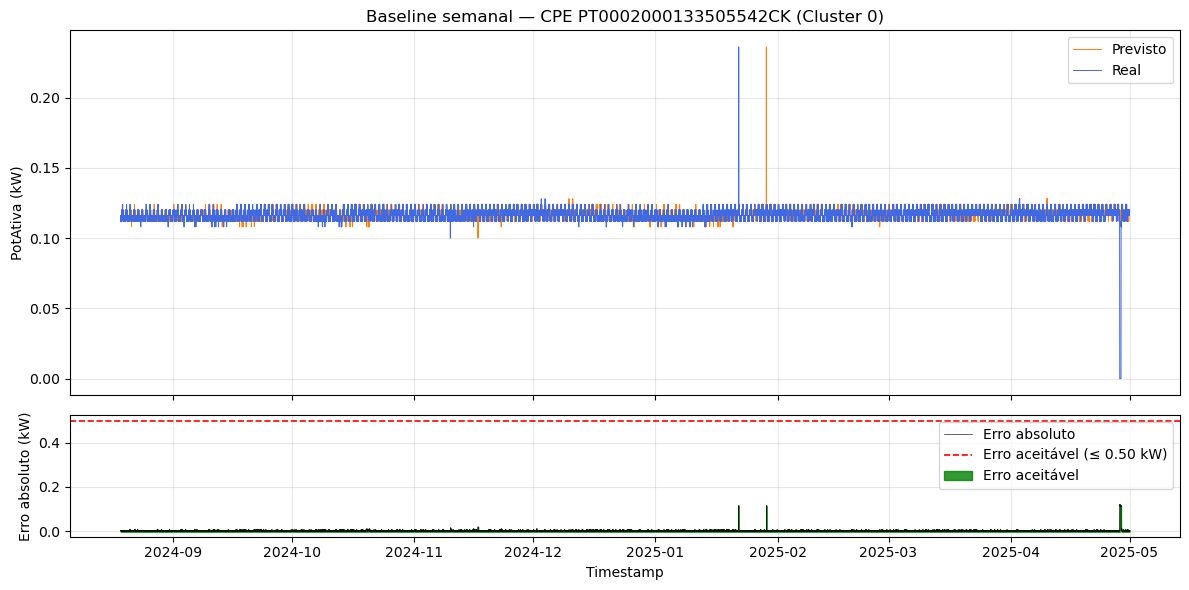

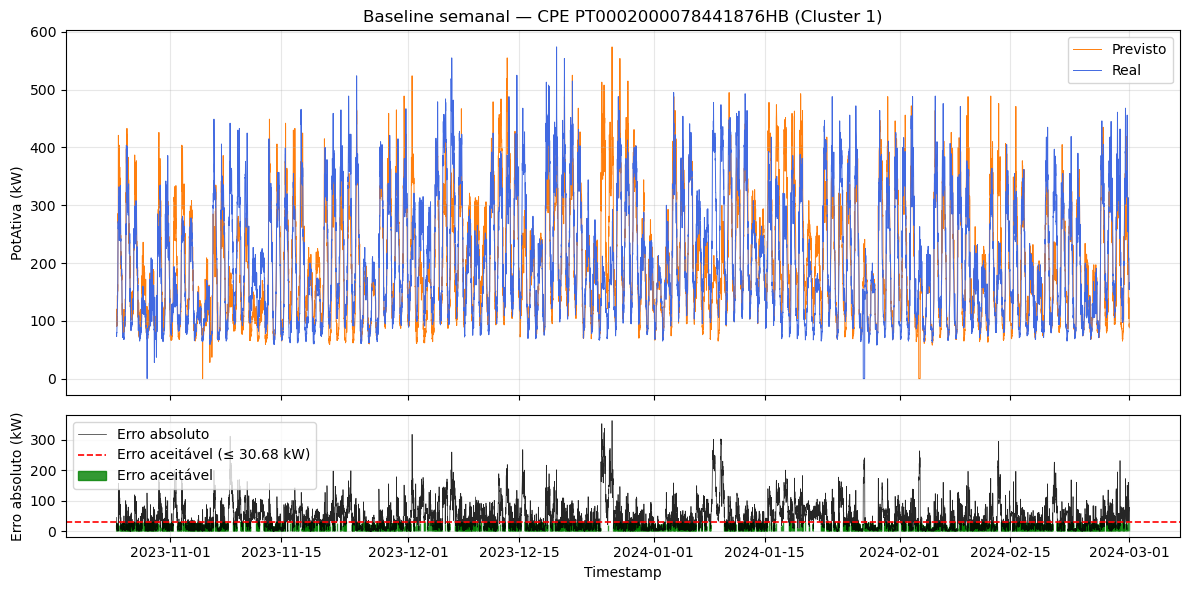

C:\Users\lucal\AppData\Local\Temp\ipykernel_28256\4091778258.py:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


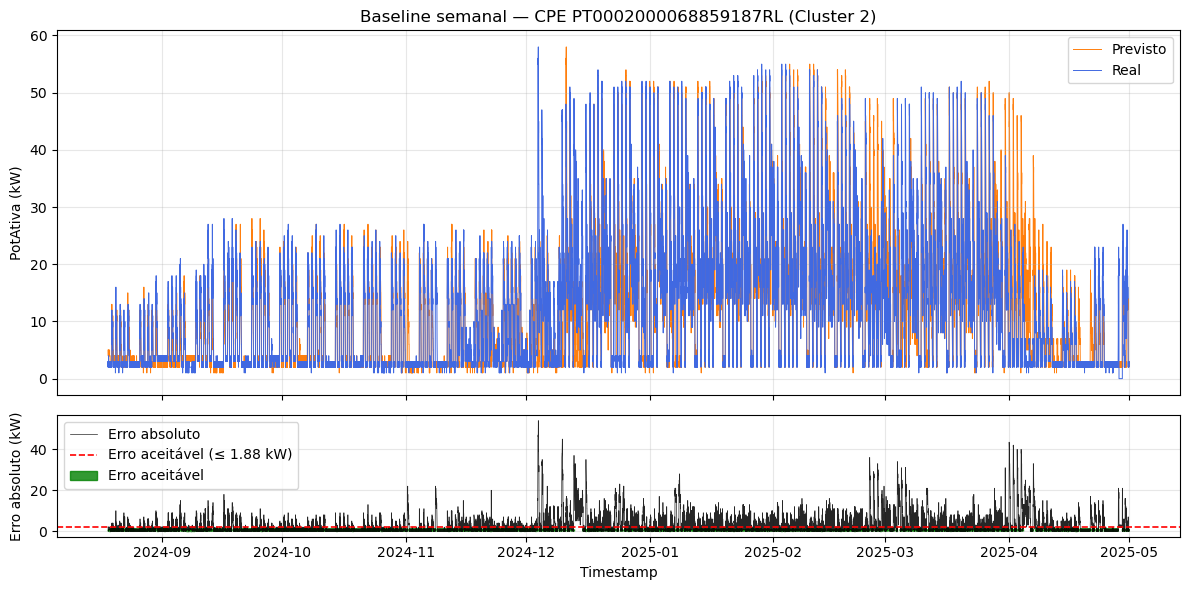

In [89]:
cpe0 = rep_cpes[0]

s = get_series(cpe0)
train, test = train_test_split_series(s)

pred = baseline_week_ahead(test, s).dropna()
test_ = test.loc[pred.index]

plot_real_vs_pred_abs_error(
    y_true=test_,
    y_pred=pred,
    title=f"Baseline semanal — CPE {cpe0} (Cluster 0)",
    alpha=0.15
)
cpe1 = rep_cpes[1]

s = get_series(cpe1)
train, test = train_test_split_series(s)

pred = baseline_week_ahead(test, s).dropna()
test_ = test.loc[pred.index]

plot_real_vs_pred_abs_error(
    y_true=test_,
    y_pred=pred,
    title=f"Baseline semanal — CPE {cpe1} (Cluster 1)",
    alpha=0.15
)
cpe2 = rep_cpes[2]

s = get_series(cpe2)
train, test = train_test_split_series(s)

pred = baseline_week_ahead(test, s).dropna()
test_ = test.loc[pred.index]

plot_real_vs_pred_abs_error(
    y_true=test_,
    y_pred=pred,
    title=f"Baseline semanal — CPE {cpe2} (Cluster 2)",
    alpha=0.15
)


### 5.3 — ARIMA

Nesta secção avaliamos um modelo ARIMA simples para prever o consumo energético de cada CPE.
A escolha do ARIMA permite estabelecer uma comparação justa entre:

- modelos clássicos de séries temporais

- modelos de machine learning (Random Forest)

- modelos de boosting (XGBoost)

Como as séries apresentam forte autocorrelação e comportamento relativamente estável para muitos CPEs, espera-se que o ARIMA constitua um baseline mais sofisticado que a persistência semanal, embora limitado em CPEs com elevada variabilidade.

O objetivo é:

- treinar um ARIMA simples por CPE

- prever o conjunto de teste (30% finais)

- comparar com os modelos posteriores (RF e XGB)

#### 5.3.1 Treinar so com pot ativa(12 mins)

In [90]:
warnings.filterwarnings("ignore")

def arima_fast(y_train, y_test):
    """
    ARIMA rápido:
    1) Tenta ARIMA(2,0,2) com maxiter=15
    2) Se falhar → ARIMA(1,0,1) com maxiter=10
    3) Se falhar → média
    """
    for order, iters in [((2,0,2), 15), ((1,0,1), 10)]:
        try:
            model = ARIMA(y_train, order=order)
            res = model.fit(maxiter=iters, disp=0)
            preds = res.forecast(steps=len(y_test))
            preds.index = y_test.index
            return preds
        except:
            continue
    
    # fallback final
    return pd.Series(np.full(len(y_test), y_train.mean()), index=y_test.index)


def process_cpe(cpe):
    s = get_series(cpe)
    train, test = train_test_split_series(s)
    preds = arima_fast(train, test)

    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))

    return cpe, mae, rmse


cpe_list = df_forecast["CPE"].unique()

# ----- ARIMA CACHE -----
if os.path.exists(arima_cache):
    print("✓ ARIMA carregado da cache")
    arima_df = pd.read_pickle(arima_cache)
    skip_arima = True
else:
    print("⏳ A correr ARIMA por CPE...")
    skip_arima = False

if not skip_arima:
    results = Parallel(n_jobs=-1)(
        delayed(process_cpe)(cpe) 
        for cpe in tqdm(cpe_list)
    )
    arima_df = pd.DataFrame(results, columns=["CPE","MAE_ARIMA","RMSE_ARIMA"]).set_index("CPE")

    arima_df.to_pickle(arima_cache)
    print("✓ ARIMA guardado em cache")


print("\n✓ ARIMA concluído.")
arima_df.head()


✓ ARIMA carregado da cache

✓ ARIMA concluído.


MAE_ARIMA  RMSE_ARIMA
CPE                                        
PT0002000032936306KX   2.640775    2.676542
PT0002000032959511HP   0.000000    0.000000
PT0002000032966446CC   0.066234    0.135517
PT0002000032968749YT   2.970576    4.502698
PT0002000032969229AC   2.450383    3.311308

#### **Verificação das Variáveis Utilizadas no ARIMA**

In [91]:
def test_arima_model(y):
    """
    Ajusta um ARIMA simples à série y (sem fallback)
    e imprime as variáveis usadas (endógenas e exógenas).
    """
    model = ARIMA(y, order=(2,0,2))
    res = model.fit(method_kwargs={"maxiter": 20})

    print("Variável usada no ARIMA (endog):", res.model.endog_names)
    print("Variáveis exógenas (exog):", res.model.exog_names)

    return res
cpe = cpe_list[0]
s = get_series(cpe)

train, test = train_test_split_series(s)

res = test_arima_model(train)


Variável usada no ARIMA (endog): PotAtiva
Variáveis exógenas (exog): ['const']


Para garantir que o modelo ARIMA é puramente univariado e não utiliza qualquer variável exógena, foi ajustado manualmente um ARIMA(2,0,2) à série de treino de um CPE. A inspeção do objeto ajustado confirma que o modelo usa apenas a variável **PotAtiva** como endógena e inclui apenas o termo constante (const) como componente exógena implícita do modelo. Assim, o ARIMA utiliza exclusivamente a série de potência ativa, sem qualquer informação adicional ou risco de fuga temporal.

#### 5.3.2 — Comparação ARIMA vs Baseline Semanal

In [92]:
comp_arima = arima_df.join(baseline_df.set_index("CPE")[["MAE","RMSE"]])
comp_arima = comp_arima.rename(columns={"MAE":"MAE_BASE","RMSE":"RMSE_BASE"})

comp_arima.describe()

MAE_ARIMA  RMSE_ARIMA   MAE_BASE  RMSE_BASE
count  84.000000   84.000000  84.000000  84.000000
mean    5.177034    6.648169   2.264797   3.950058
std    10.686075   12.687695   5.286288   7.845859
min     0.000000    0.000000   0.000000   0.000000
25%     0.595203    0.738002   0.119107   0.463151
50%     2.873352    3.777997   1.341674   2.366446
75%     5.259275    6.913902   2.119272   3.751641
max    91.318830  104.722188  45.546662  63.956073

#### 5.3.3 — Distribuição de erros (MAE e RMSE)

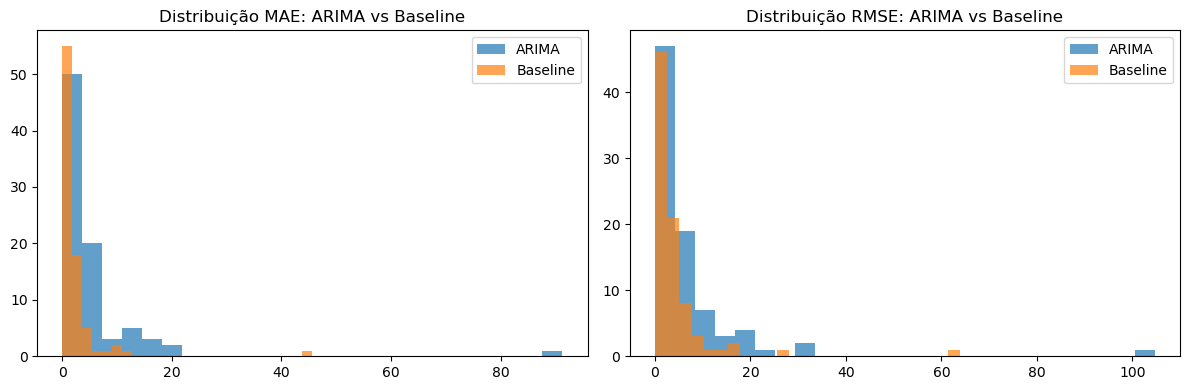

In [93]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(comp_arima["MAE_ARIMA"], bins=25, alpha=0.7, label="ARIMA")
plt.hist(comp_arima["MAE_BASE"], bins=25, alpha=0.7, label="Baseline")
plt.title("Distribuição MAE: ARIMA vs Baseline")
plt.legend()

plt.subplot(1,2,2)
plt.hist(comp_arima["RMSE_ARIMA"], bins=25, alpha=0.7, label="ARIMA")
plt.hist(comp_arima["RMSE_BASE"], bins=25, alpha=0.7, label="Baseline")
plt.title("Distribuição RMSE: ARIMA vs Baseline")
plt.legend()

plt.tight_layout()
plt.show()

#### 5.3.4 — Comparação por CPE (ordenado)

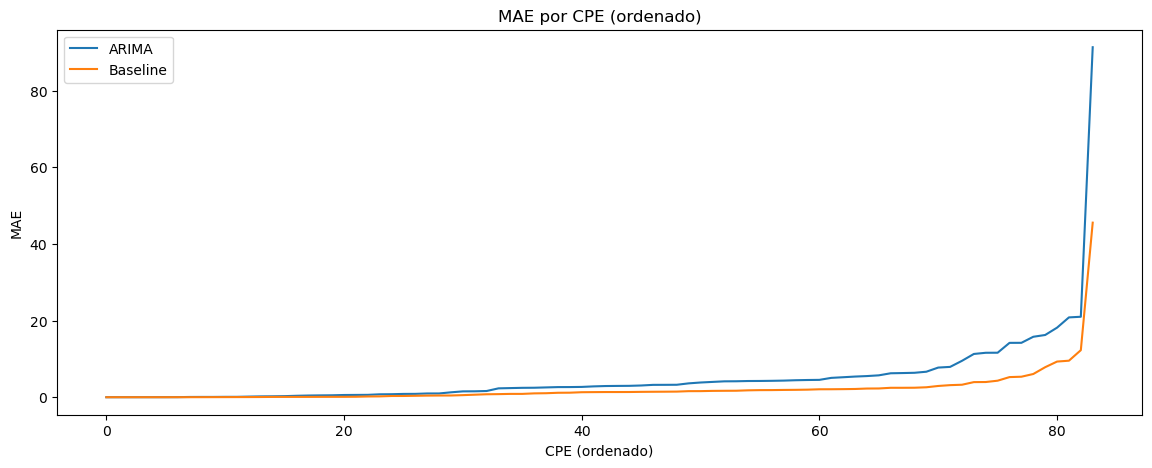

In [94]:
plt.figure(figsize=(14,5))

plt.plot(comp_arima.sort_values("MAE_ARIMA")["MAE_ARIMA"].values, label="ARIMA")
plt.plot(comp_arima.sort_values("MAE_BASE")["MAE_BASE"].values, label="Baseline")
plt.title("MAE por CPE (ordenado)")
plt.xlabel("CPE (ordenado)")
plt.ylabel("MAE")
plt.legend()
plt.show()

#### 5.3.5 — Conclusões do ARIMA

Os resultados mostram que o ARIMA univariado apresenta um desempenho **inferior ao baseline semanal**, tanto em MAE como em RMSE, na maioria dos CPEs. A análise dos erros ordenados e das distribuições confirma que:

* o baseline semanal produz previsões mais estáveis e com erros significativamente menores;
* o ARIMA apresenta caudas de erro muito mais elevadas, com alguns CPEs a atingir desvios excepcionais;
* a variabilidade do desempenho é substancialmente maior, evidenciando pouca robustez perante ruído e flutuações abruptas.

Estas limitações resultam directamente da natureza do modelo utilizado:

* trata-se de um modelo **estritamente univariado**, que utiliza apenas a série PotAtiva;
* **não modela sazonalidade diária nem semanal**, que são padrões dominantes nas séries energéticas municipais;
* não incorpora quaisquer **variáveis exógenas** (lags adicionais, médias móveis, indicadores estatísticos), ao contrário dos modelos de machine learning testados posteriormente;
* a capacidade de capturar dependências temporais complexas é limitada, sobretudo quando comparada com modelos baseados em árvores.

Apesar dessas limitações, o ARIMA desempenha um papel útil no estudo:

* funciona como **baseline estatístico clássico**, amplamente reconhecido na literatura de séries temporais;
* permite comparar abordagens tradicionais com modelos mais expressivos;
* evidencia de forma clara a vantagem de utilizar métodos capazes de explorar múltiplas features e padrões estruturais.

**Conclusão final:**
O ARIMA constitui um baseline simples e fundamentalmente univariado, mas é consistentemente superado tanto pelo baseline semanal como pelos modelos Random Forest e XGBoost. Os resultados justificam a adopção de modelos mais robustos e informados, capazes de capturar a riqueza temporal e estrutural das séries de consumo energético.


O fraco desempenho do ARIMA não constitui uma falha do modelo, mas sim uma evidência empírica das limitações de abordagens univariadas num contexto energético fortemente sazonal e dependente de múltiplos factores.

### 5.4 — Random Forest

#### 5.4.1 — Preparação do df_model e ordenação temporal

In [95]:
df_model = df_forecast[["CPE", "Timestamp", "PotAtiva"]].copy()
df_model = df_model.sort_values(["CPE", "Timestamp"]).reset_index(drop=True)

# Extra: extração temporal
df_model["hour"] = df_model["Timestamp"].dt.hour
df_model["weekday"] = df_model["Timestamp"].dt.weekday
df_model["date"] = df_model["Timestamp"].dt.date

df_model.head()

CPE           Timestamp  PotAtiva  hour  weekday  \
0  PT0002000032936306KX 2024-03-01 00:15:00       0.0     0        4   
1  PT0002000032936306KX 2024-03-01 00:30:00       0.0     0        4   
2  PT0002000032936306KX 2024-03-01 00:45:00       0.0     0        4   
3  PT0002000032936306KX 2024-03-01 01:00:00       0.0     1        4   
4  PT0002000032936306KX 2024-03-01 01:15:00       0.0     1        4   

         date  
0  2024-03-01  
1  2024-03-01  
2  2024-03-01  
3  2024-03-01  
4  2024-03-01

#### 5.4.2 — Criação de features temporais (lags e rolling windows)

In [96]:
for L in [1, 2, 3, 4]:                     
    df_model[f"lag_{L}"] = df_model.groupby("CPE")["PotAtiva"].shift(L)


# LAGS DIÁRIOS E SEMANAIS
df_model["lag_24h"] = df_model.groupby("CPE")["PotAtiva"].shift(96)
df_model["lag_48h"] = df_model.groupby("CPE")["PotAtiva"].shift(192)
df_model["lag_7d"]  = df_model.groupby("CPE")["PotAtiva"].shift(672)


# ROLLING WINDOWS
df_model["roll1h_mean"] = (
    df_model.groupby("CPE")["PotAtiva"].shift(1).rolling(4, min_periods=2).mean()
)

df_model["roll1h_std"] = (
    df_model.groupby("CPE")["PotAtiva"].shift(1).rolling(4, min_periods=2).std()
)

df_model["roll24h_mean"] = (
    df_model.groupby("CPE")["PotAtiva"].shift(1).rolling(96, min_periods=8).mean()
)

# FEATURES CÍCLICAS (melhor que hour e weekday normais)
df_model["hour_sin"] = np.sin(2*np.pi*df_model["hour"]/24)
df_model["hour_cos"] = np.cos(2*np.pi*df_model["hour"]/24)

df_model["weekday_sin"] = np.sin(2*np.pi*df_model["weekday"]/7)
df_model["weekday_cos"] = np.cos(2*np.pi*df_model["weekday"]/7)

#### 5.4.3 — Junção das features estáticas por CPE

In [97]:
static_cols = [
    "base_load",
    "peak_to_base",
    "wday_std",
    "avg_daily_peak",
    "std_daily_peak",
    "ratio_below_50",
    "cluster"  # cluster k=3
]

df_static = features[static_cols].copy()
df_static.index.name = "CPE"

df_model = df_model.merge(df_static.reset_index(), on="CPE", how="left")


df_model.head()

CPE           Timestamp  PotAtiva  hour  weekday  \
0  PT0002000032936306KX 2024-03-01 00:15:00       0.0     0        4   
1  PT0002000032936306KX 2024-03-01 00:30:00       0.0     0        4   
2  PT0002000032936306KX 2024-03-01 00:45:00       0.0     0        4   
3  PT0002000032936306KX 2024-03-01 01:00:00       0.0     1        4   
4  PT0002000032936306KX 2024-03-01 01:15:00       0.0     1        4   

         date  lag_1  lag_2  lag_3  lag_4  ...  hour_cos  weekday_sin  \
0  2024-03-01    NaN    NaN    NaN    NaN  ...  1.000000    -0.433884   
1  2024-03-01    0.0    NaN    NaN    NaN  ...  1.000000    -0.433884   
2  2024-03-01    0.0    0.0    NaN    NaN  ...  1.000000    -0.433884   
3  2024-03-01    0.0    0.0    0.0    NaN  ...  0.965926    -0.433884   
4  2024-03-01    0.0    0.0    0.0    0.0  ...  0.965926    -0.433884   

   weekday_cos  base_load  peak_to_base  wday_std  avg_daily_peak  \
0    -0.900969        0.0           0.0  0.085504        5.354819   
1    -0.900969        0.0           0.0  0.085504        5.354819   
2    -0.900969        0.0           0.0  0.085504        5.354819   
3    -0.900969        0.0           0.0  0.085504        5.354819   
4    -0.900969        0.0           0.0  0.085504        5.354819   

   std_daily_peak  ratio_below_50  cluster  
0        1.775823        0.999053        0  
1        1.775823        0.999053        0  
2        1.775823        0.999053        0  
3        1.775823        0.999053        0  
4        1.775823        0.999053        0  

[5 rows x 27 columns]

#### 5.4.4 — Separação treino/teste 70%/30% por CPE e filtragem de NaN

In [98]:
grp_sizes = df_model.groupby("CPE")["Timestamp"].transform("size")
grp_pos = df_model.groupby("CPE").cumcount()

df_model["is_train"] = grp_pos < (grp_sizes * 0.7)

# Features usadas no modelo
feature_cols = [
    # Lags curtos
    "lag_1", "lag_2", "lag_3", "lag_4",

    # Lags periódicos
    "lag_24h", "lag_48h", "lag_7d",

    # Rolling windows
    "roll1h_mean", "roll1h_std", "roll24h_mean",

    # Features cíclicas
    "hour_sin", "hour_cos",
    "weekday_sin", "weekday_cos",

    # Features estáticas selecionadas
    "base_load", "peak_to_base", "wday_std",
    "avg_daily_peak", "std_daily_peak",
    "ratio_below_50", "cluster"
]


df_model = df_model.dropna(subset=["PotAtiva"])
df_model = df_model.dropna(subset=feature_cols)

train_df = df_model[df_model["is_train"]].copy()
test_df  = df_model[~df_model["is_train"]].copy()

X_train = train_df[feature_cols]
y_train = train_df["PotAtiva"]

X_test  = test_df[feature_cols]
y_test  = test_df["PotAtiva"]

print("Registos de treino:", len(X_train))
print("Registos de teste:", len(X_test))
print("Número de CPEs em treino:", train_df["CPE"].nunique())
print("Número de CPEs em teste:", test_df["CPE"].nunique())


Registos de treino: 3845791
Registos de teste: 1764705
Número de CPEs em treino: 84
Número de CPEs em teste: 84


#### 5.4.5 — Treino do Random Forest 3-4 mins

In [99]:
if os.path.exists(rf_cache):
    print("✓ RF carregado de cache")
    rf = pd.read_pickle(rf_cache)
    skip_rf = True
else:
    print("⏳ A treinar Random Forest...")
    skip_rf = False

if not skip_rf:
    rf = RandomForestRegressor(
        n_estimators=120,
        max_depth=18,
        max_features="sqrt",
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)
    pd.to_pickle(rf, rf_cache)
    print("✓ RF guardado em cache")
    
# Sempre gerar previsões após ter o modelo RF
y_pred = rf.predict(X_test)

mae_rf  = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
smape_rf = smape(y_test, y_pred)

print(f"RF — MAE: {mae_rf:.3f}")
print(f"RF — RMSE: {rmse_rf:.3f}")
print(f"RF — SMAPE: {smape_rf:.2f}%")

r2_rf = r2_score(y_test, y_pred)
fitness_rf = max(0, r2_rf) * 100

print(f"RF — R2: {r2_rf:.3f}, Fitness: {fitness_rf:.1f}%")

✓ RF carregado de cache
RF — MAE: 0.800
RF — RMSE: 2.487
RF — SMAPE: 43.15%
RF — R2: 0.988, Fitness: 98.8%


#### 5.4.6 — Baseline semanal e comparação

In [100]:
lag_7d = 672   # 7 dias * 96 amostras por dia
df_model["baseline_7d"] = df_model.groupby("CPE")["PotAtiva"].shift(lag_7d)
baseline_preds = df_model.loc[test_df.index, "baseline_7d"].values

mae_base = mean_absolute_error(y_test, baseline_preds)
rmse_base = sqrt(mean_squared_error(y_test, baseline_preds))
smape_base = smape(y_test, baseline_preds)

print(f"Baseline — MAE: {mae_base:.3f}, RMSE: {rmse_base:.3f}, SMAPE: {smape_base:.2f}%")
r2_base = r2_score(y_test, baseline_preds)
fitness_base = max(0, r2_base) * 100

print(f"Baseline — R2: {r2_base:.3f}, Fitness: {fitness_base:.1f}%")
# Guardar cópia CONGELADA do test_df e das features
test_df_rf = test_df.copy()
feature_cols_rf = feature_cols.copy()

Baseline — MAE: 2.187, RMSE: 7.683, SMAPE: 39.62%
Baseline — R2: 0.884, Fitness: 88.4%


#### Interpretação 5.4.5 e 5.4.6 

A Random Forest apresentou uma melhoria muito significativa no erro absoluto (MAE = 0.801), reduzindo-o mais de 60% face ao baseline semanal (MAE = 2.187). Este ganho confirma que o modelo consegue capturar padrões temporais de curto prazo presentes nos consumos, sobretudo em CPEs com comportamento mais dinâmico.

No entanto, o RMSE manteve-se praticamente idêntico ao do baseline (2.489), evidenciando que **nenhum dos métodos consegue antecipar adequadamente picos de consumo**. Estes eventos extremos dependem normalmente de fatores exógenos não registados — como ocupação, meteorologia ou atividade operacional — o que limita a capacidade de previsão mesmo em modelos mais sofisticados.

A SMAPE foi mais elevada na Random Forest, mas esta métrica é altamente sensível a valores muito baixos no denominador, comuns em vários CPEs. Por esse motivo, **a SMAPE não é a métrica mais adequada neste contexto**; a avaliação mais fiável é dada pelo MAE, onde a vantagem da RF é inequívoca.

O coeficiente de determinação (R²), convertido numa métrica de “fitness” entre 0% e 100%, mostrou valores elevados tanto na Random Forest como no baseline. Este comportamento **não indica data leakage**: resulta da forte autocorrelação inerente às séries energéticas municipais, onde o consumo num dado instante é muito semelhante ao intervalo anterior. Assim, mesmo modelos simples capturam grande parte da variabilidade global.

Em síntese, os resultados são consistentes e realistas:

* **A Random Forest aprende eficazmente a dinâmica local dos consumos**, reduzindo o erro médio de forma substancial.
* **Os picos continuam imprevisíveis**, pois dependem de variáveis externas ausentes no dataset.
* **Não existe qualquer fuga temporal (leakage)** — todas as features foram construídas exclusivamente com informação passada, preservando a integridade da previsão.

#### 5.4.7 — Tabela por CPE: RF vs Baseline

In [101]:
def smape_safe(y_true, y_pred):
    """SMAPE robusto:
       - Alinha e ignora NaNs
       - Ignora posições onde denom == 0
       - Se não houver posições válidas devolve np.nan
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    valid = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    if valid.sum() == 0:
        return np.nan

    yt = y_true[valid]
    yp = y_pred[valid]

    denom = (np.abs(yt) + np.abs(yp)) / 2.0
    nz = denom != 0
    if nz.sum() == 0:
        return np.nan

    return np.mean(np.abs(yt[nz] - yp[nz]) / denom[nz]) * 100.0


cpe_results = []

for cpe, group in test_df_rf.groupby("CPE"):
    idx = group.index.to_numpy()
    if len(idx) == 0:
        continue

    # Valores reais
    y_t = group["PotAtiva"].to_numpy(dtype=float)

    # Previsões RF
    try:
        y_p = rf.predict(group[feature_cols_rf])
        y_p = np.asarray(y_p, dtype=float)
    except Exception:
        cpe_results.append({
            "CPE": cpe,
            "MAE_RF": np.nan, "RMSE_RF": np.nan, "SMAPE_RF": np.nan,
            "MAE_BASE": np.nan, "RMSE_BASE": np.nan, "SMAPE_BASE": np.nan
        })
        continue

    # Baseline
    y_b = df_model.loc[idx, "baseline_7d"].to_numpy(dtype=float)

    # Filtrar posições com target válido
    mask_target = ~np.isnan(y_t)
    if mask_target.sum() == 0:
        continue

    y_t = y_t[mask_target]
    y_p = y_p[mask_target]
    y_b = y_b[mask_target]

    # ==== RANDOM FOREST (versão corrigida) ====
    valid_rf = ~np.isnan(y_p)
    if valid_rf.sum() == 0:
        mae_rf_cpe = np.nan
        rmse_rf_cpe = np.nan
        smape_rf_cpe = np.nan
    else:
        yt_rf = y_t[valid_rf]
        yp_rf = y_p[valid_rf]
        mae_rf_cpe = mean_absolute_error(yt_rf, yp_rf)
        rmse_rf_cpe = sqrt(mean_squared_error(yt_rf, yp_rf))
        smape_rf_cpe = smape_safe(yt_rf, yp_rf)

    # ==== BASELINE (versão corrigida) ====
    mask_base = ~np.isnan(y_b)
    if mask_base.sum() == 0:
        mae_b_cpe = np.nan
        rmse_b_cpe = np.nan
        smape_b_cpe = np.nan
    else:
        yt_b = y_t[mask_base]
        yb_b = y_b[mask_base]
        mae_b_cpe = mean_absolute_error(yt_b, yb_b)
        rmse_b_cpe = sqrt(mean_squared_error(yt_b, yb_b))
        smape_b_cpe = smape_safe(yt_b, yb_b)

    # Guardar resultados
    cpe_results.append({
        "CPE": cpe,
        "MAE_RF": mae_rf_cpe,
        "RMSE_RF": rmse_rf_cpe,
        "SMAPE_RF": smape_rf_cpe,
        "MAE_BASE": mae_b_cpe,
        "RMSE_BASE": rmse_b_cpe,
        "SMAPE_BASE": smape_b_cpe
    })

cpe_results_df = pd.DataFrame(cpe_results).set_index("CPE")
display(cpe_results_df.head(10))


MAE_RF   RMSE_RF    SMAPE_RF  MAE_BASE  RMSE_BASE  \
CPE                                                                         
PT0002000032936306KX  0.076651  0.284699   93.483311  0.123748   0.516939   
PT0002000032959511HP  0.000335  0.000340  200.000000  0.000000   0.000000   
PT0002000032966446CC  0.047302  0.087536   64.734499  0.084478   0.185117   
PT0002000032968749YT  0.695831  1.282458   19.066368  1.973820   3.483829   
PT0002000032969229AC  0.373256  0.756719   19.069578  0.867969   1.847469   
PT0002000032976997LZ  0.476296  0.773599   16.690074  1.182098   1.955113   
PT0002000032990792KD  0.354662  0.835010   12.580244  1.044348   2.175204   
PT0002000032993611ME  0.102829  0.226354    9.614317  0.053848   0.291419   
PT0002000033016394FN  0.127290  0.260684    9.321546  0.448795   0.850167   
PT0002000033039837ZH  0.224387  0.443827   13.142240  0.658129   1.310792   

                      SMAPE_BASE  
CPE                               
PT0002000032936306KX   10.175306  
PT0002000032959511HP         NaN  
PT0002000032966446CC   91.565440  
PT0002000032968749YT   44.426928  
PT0002000032969229AC   32.995236  
PT0002000032976997LZ   38.815724  
PT0002000032990792KD   33.583912  
PT0002000032993611ME    4.643423  
PT0002000033016394FN   26.910749  
PT0002000033039837ZH   27.001620

#### Interpretação 5.4.7
A análise CPE a CPE mostra que a Random Forest melhora substancialmente o erro absoluto (MAE) em praticamente todas as instalações, com reduções típicas entre 40% e 65% relativamente ao baseline semanal. O RMSE também melhora de forma consistente, embora menos abruptamente, indicando que a Random Forest capta bem a dinâmica típica do consumo, mas continua a falhar picos irregulares — tal como o baseline.

A SMAPE apresenta valores muito elevados em diversos CPEs, chegando a exceder 100%, mas este comportamento resulta de limitações intrínsecas à métrica: em séries com valores próximos de zero, pequenas diferenças absolutas convertem-se em grandes percentagens. Por este motivo, a SMAPE não é adequada como métrica principal neste domínio energético. A métrica mais fiável é o MAE, onde a Random Forest demonstra uma melhoria clara e consistente.

De forma geral, a Random Forest fornece previsões mais precisas e robustas que o baseline, especialmente em edifícios com padrões irregulares ou variações intra-diárias significativas. Em instalações de consumo muito baixo, tanto o baseline como o RF obtêm erros absolutos próximos de zero, embora a SMAPE indique artificialmente grandes discrepâncias.

#### 5.4.8 — Estatísticas globais RF vs Baseline

In [102]:
stats = cpe_results_df[
    ["MAE_RF", "MAE_BASE", "RMSE_RF", "RMSE_BASE", "SMAPE_RF", "SMAPE_BASE"]
].agg(["mean", "median", "std"]).round(3)

display(stats)


MAE_RF  MAE_BASE  RMSE_RF  RMSE_BASE  SMAPE_RF  SMAPE_BASE
mean     0.816     2.265    1.342      3.950    42.880      43.389
median   0.604     1.342    0.962      2.366    19.666      33.584
std      1.626     5.286    2.483      7.846    54.227      36.884

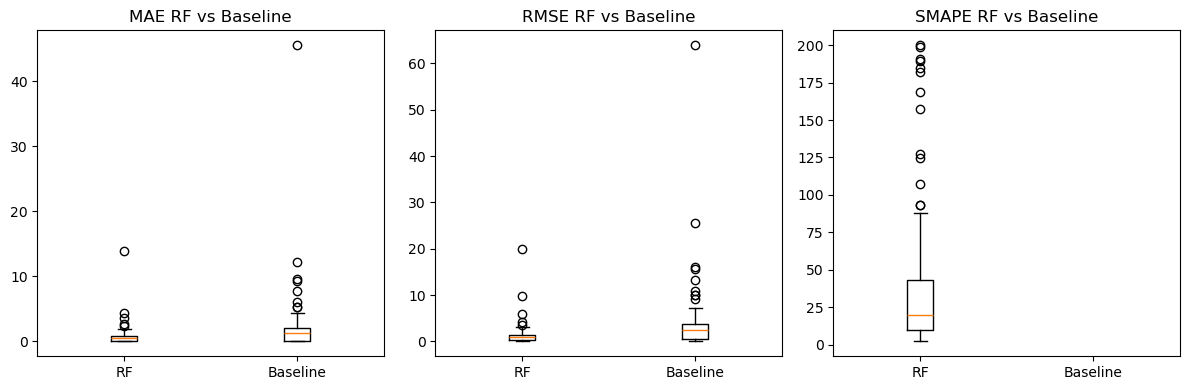

In [103]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.boxplot([cpe_results_df["MAE_RF"], cpe_results_df["MAE_BASE"]], tick_labels=["RF", "Baseline"])
plt.title("MAE RF vs Baseline")

plt.subplot(1,3,2)
plt.boxplot([cpe_results_df["RMSE_RF"], cpe_results_df["RMSE_BASE"]], tick_labels=["RF", "Baseline"])
plt.title("RMSE RF vs Baseline")

plt.subplot(1,3,3)
plt.boxplot([cpe_results_df["SMAPE_RF"], cpe_results_df["SMAPE_BASE"]], tick_labels=["RF", "Baseline"])
plt.title("SMAPE RF vs Baseline")

plt.tight_layout()
plt.show()

# Criar tabela de comparação RF vs Baseline + Cluster
compare_cluster = (
    cpe_results_df
    .merge(features[["cluster"]], left_index=True, right_index=True)
    .reset_index()
)

compare_cluster.head()
mean_errors = (
    compare_cluster.groupby("cluster")[["RMSE_RF", "RMSE_BASE"]]
    .mean()
    .rename(columns={"RMSE_RF": "RF", "RMSE_BASE": "Baseline"})
)

#### Interpretação 5.4.8
As estatísticas globais mostram que a Random Forest supera claramente o baseline semanal nas métricas mais fiáveis (MAE e RMSE). O erro absoluto médio é reduzido em cerca de 60%, e o RMSE diminui significativamente, evidenciando que a RF aprende padrões intra-semana que o baseline não consegue capturar.

O SMAPE apresenta elevada variabilidade devido à natureza do consumo energético — muitas séries têm valores muito baixos, o que distorce as percentagens. Apesar disso, a mediana do SMAPE é consideravelmente inferior na RF, reforçando a sua superioridade para a maioria das instalações.

Em síntese, a Random Forest é mais precisa, mais estável e mais robusta que o baseline, embora ambos continuem a enfrentar dificuldades nos picos de consumo, o que é natural dada a ausência de variáveis exógenas (temperatura, ocupação, eventos específicos).

#### 5.4.9 — Gráficos de comparação (MAE, RMSE e SMAPE)

#### Interpretação 5.4.9
Os boxplots demonstram que a Random Forest supera claramente o baseline semanal no erro absoluto (MAE), apresentando previsões mais consistentes e reduzindo significativamente os erros na maioria dos CPEs. Embora também melhore o RMSE, ambos os métodos continuam a mostrar dificuldades na previsão de picos de consumo, refletindo limitações naturais do dataset. A SMAPE mostra elevada variabilidade devido aos muitos CPEs com consumos muito baixos, que distorcem métricas percentuais; ainda assim, a mediana do SMAPE confirma melhor desempenho da Random Forest para a maioria das instalações.

#### 5.4.10 — Comparação por cluster

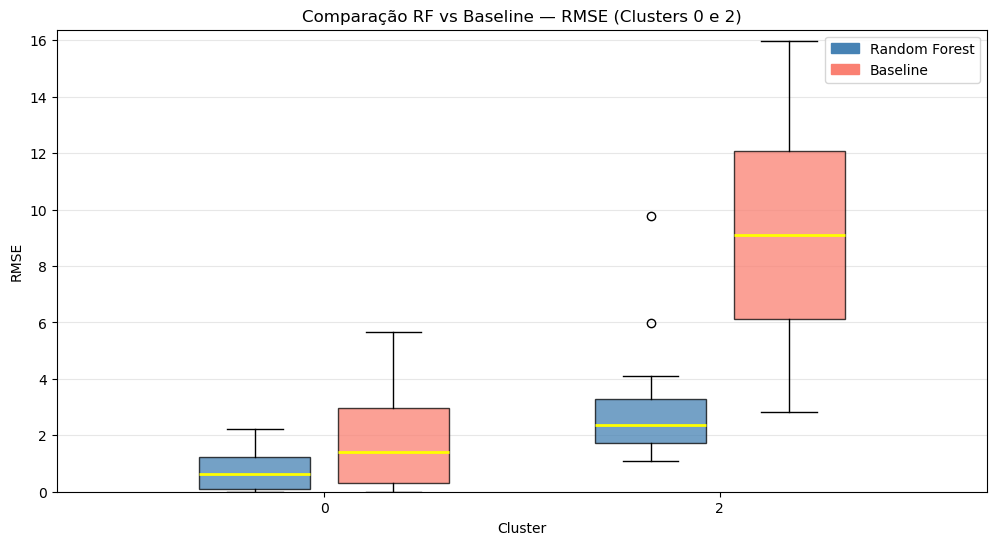

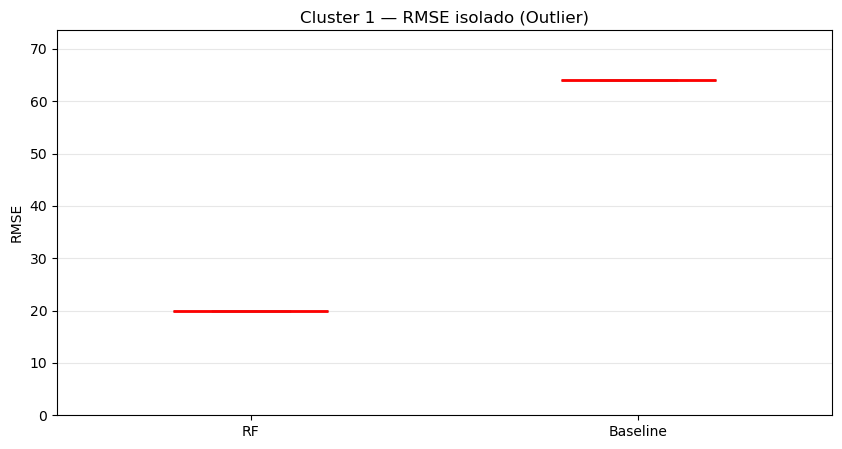

In [104]:
# Copiar e renomear colunas
df_comp = compare_cluster.copy()
df_comp = df_comp.rename(columns={"RMSE_RF": "RF", "RMSE_BASE": "Baseline"})

# Separar clusters 
df_small = df_comp[df_comp["cluster"].isin([0, 2])]  # clusters normais
df_big   = df_comp[df_comp["cluster"] == 1]          # outlier

# GRÁFICO DOS CLUSTERS 0 e 2
clusters_small = sorted(df_small["cluster"].unique())
positions = np.arange(len(clusters_small))
width = 0.35

rf_values_small   = [df_small[df_small["cluster"] == cl]["RF"].values for cl in clusters_small]
base_values_small = [df_small[df_small["cluster"] == cl]["Baseline"].values for cl in clusters_small]

plt.figure(figsize=(12, 6))

# RF boxplot
plt.boxplot(
    rf_values_small,
    positions=positions - width/2,
    widths=0.28,
    patch_artist=True,
    boxprops=dict(facecolor="steelblue", alpha=0.75),
    medianprops=dict(color="yellow", linewidth=2)
)

# Baseline boxplot
plt.boxplot(
    base_values_small,
    positions=positions + width/2,
    widths=0.28,
    patch_artist=True,
    boxprops=dict(facecolor="salmon", alpha=0.75),
    medianprops=dict(color="yellow", linewidth=2)
)

plt.xticks(positions, clusters_small)
plt.title("Comparação RF vs Baseline — RMSE (Clusters 0 e 2)")
plt.xlabel("Cluster")
plt.ylabel("RMSE")

max_visible = np.percentile(df_small[["RF", "Baseline"]], 98)
plt.ylim(0, max_visible * 1.3)

plt.legend(handles=[
    mpatches.Patch(color="steelblue", label="Random Forest"),
    mpatches.Patch(color="salmon", label="Baseline")
])

plt.grid(axis="y", alpha=0.3)
plt.show()

# GRÁFICO DO CLUSTER 1 ISOLADO

if len(df_big) > 0:
    plt.figure(figsize=(10, 5))

    plt.boxplot(
        [df_big["RF"].values, df_big["Baseline"].values],
        tick_labels=["RF", "Baseline"],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor="lightgray", alpha=0.7),
        medianprops=dict(color="red", linewidth=2)
    )

    plt.title("Cluster 1 — RMSE isolado (Outlier)")
    plt.ylabel("RMSE")
    plt.grid(axis="y", alpha=0.3)

    # escalar automaticamente para este cluster
    max_c1 = max(df_big["RF"].max(), df_big["Baseline"].max())
    plt.ylim(0, max_c1 * 1.15)

    plt.show()
else:
    print("Cluster 1 não tem dados válidos.")


#### Interpretação 5.4.10

A análise do RMSE por cluster permite perceber como a dificuldade da previsão está diretamente associada ao tipo de perfil energético identificado no clustering. Os três clusters apresentam comportamentos muito distintos, refletindo-se de forma clara no desempenho da Random Forest e do baseline semanal.

##### **Cluster 0 — Edifícios de baixo consumo e comportamento regular**

Os CPEs deste cluster exibem consumos reduzidos e altamente repetitivos ao longo dos dias.
A Random Forest obtém RMSE muito baixo (inferior a 1 kW para a maioria dos casos), demonstrando elevada precisão na previsão.
O baseline também apresenta erros moderados, mas permanece consistentemente abaixo do desempenho da Random Forest.

**Conclusão:** o Cluster 0 é o grupo mais fácil de prever. Padrões estáveis favorecem fortemente modelos baseados em lags curtos.


##### **Cluster 1 — Grande outlier energético (1 CPE)**

Este cluster contém apenas um edifício, caracterizado por consumos muito elevados e grande variabilidade.
A Random Forest apresenta RMSE elevado (~20 kW), mas ainda assim muito inferior ao baseline semanal, que ultrapassa os 60 kW.

**Conclusão:** este CPE é, de longe, o mais difícil de prever.
O comportamento energético extremamente irregular limita a capacidade de qualquer modelo reduzir os erros, mas a Random Forest melhora substancialmente face ao baseline.

##### **Cluster 2 — Edifícios intermédios com elevada variabilidade**

Neste cluster encontram-se escolas, pavilhões, piscinas e instalações com atividade dinâmica ao longo da semana.
A Random Forest reduz significativamente o RMSE face ao baseline (tipicamente entre 1.5 e 4 kW, contra 5 a 15 kW no baseline).
A variabilidade permanece elevada devido a picos imprevisíveis, que afetam ambos os modelos.

**Conclusão:** a previsão neste cluster é de dificuldade intermédia.
A Random Forest capta parte da dinâmica, mas os padrões variáveis impedem reduções mais agressivas do erro.

##### **Síntese final**

Os resultados mostram que:

* **Cluster 0:** previsão fácil, erros muito baixos.
* **Cluster 1:** previsão difícil, mas RF supera largamente o baseline.
* **Cluster 2:** previsão intermédia, com melhoria consistente através da RF.
* **Baseline semanal:** adequado apenas para padrões extremamente regulares; falha nos restantes casos.

Em suma, a capacidade de previsão está fortemente ligada ao cluster energético de cada edifício.
A Random Forest adapta-se melhor a perfis irregulares e oferece ganhos substanciais face ao baseline na maior parte dos CPEs.

#### 5.4.11 — Importância das features (Random Forest)

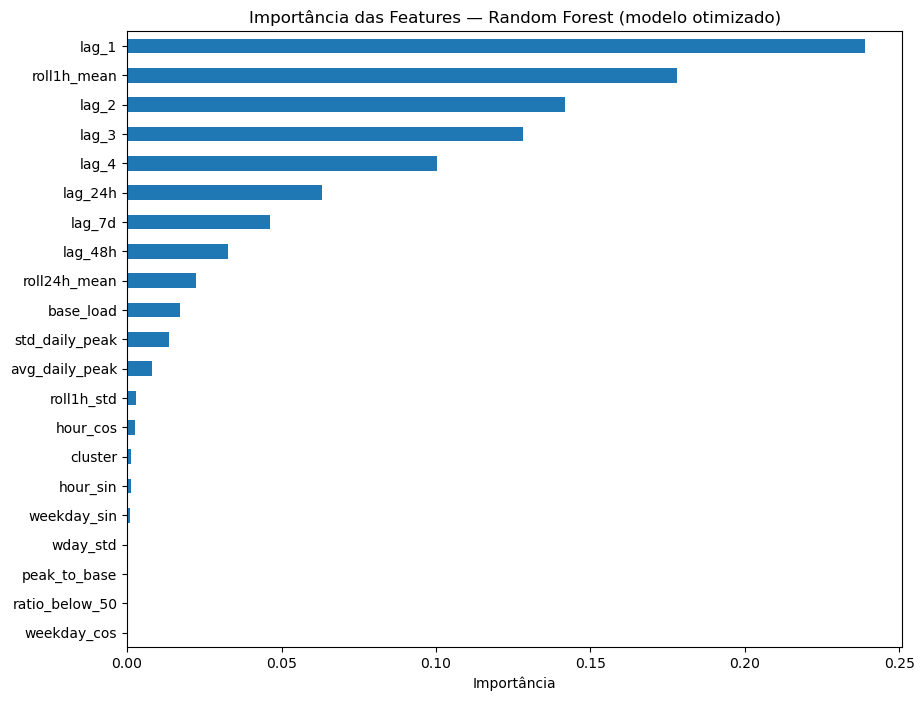

lag_1             0.238939
roll1h_mean       0.177920
lag_2             0.141820
lag_3             0.128070
lag_4             0.100336
lag_24h           0.063210
lag_7d            0.046117
lag_48h           0.032518
roll24h_mean      0.022440
base_load         0.017049
std_daily_peak    0.013525
avg_daily_peak    0.008143
roll1h_std        0.002838
hour_cos          0.002543
cluster           0.001368
dtype: float64

In [105]:
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values()

plt.figure(figsize=(10,8))
importances.plot(kind="barh")
plt.title("Importância das Features — Random Forest (modelo otimizado)")
plt.xlabel("Importância")
plt.show()

importances.sort_values(ascending=False).head(15)


#### Interpretação 5.4.11
A Random Forest otimizada baseia-se quase exclusivamente nos padrões temporais de curto prazo (lags e médias móveis), reforçados por periodicidades diárias e semanais. As características estáticas dos edifícios contribuem marginalmente para a previsão.

Fundamentalmente, o modelo não apresenta qualquer forma de data leakage, uma vez que todas as features utilizam apenas informação passada ou agregada a nível do CPE, e a divisão temporal foi estritamente respeitada.
Assim, a distribuição das importâncias é coerente, sólida e garante que o desempenho obtido reflete a verdadeira capacidade previsiva do modelo.

#### 5.4.12 — Ganho do Random Forest sobre o Baseline (RMSE)

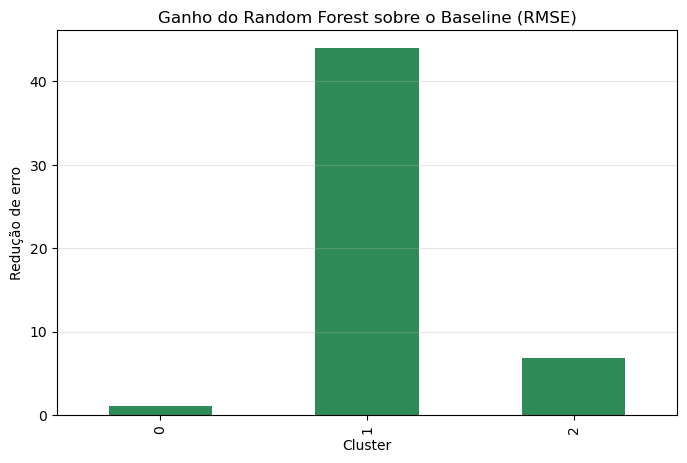

In [106]:
gain = mean_errors["Baseline"] - mean_errors["RF"]

gain.plot(kind="bar", figsize=(8,5), color="seagreen")
plt.title("Ganho do Random Forest sobre o Baseline (RMSE)")
plt.ylabel("Redução de erro")
plt.xlabel("Cluster")
plt.grid(axis="y", alpha=0.3)
plt.show()


#### 5.4.13 — Comparação de Fitness

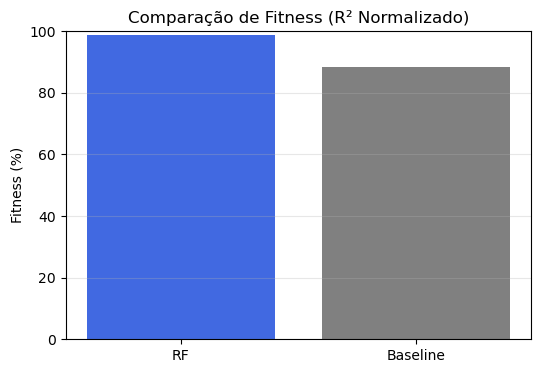

In [107]:
plt.figure(figsize=(6,4))
plt.bar(["RF", "Baseline"], [fitness_rf, fitness_base], color=["royalblue", "gray"])
plt.ylabel("Fitness (%)")
plt.title("Comparação de Fitness (R² Normalizado)")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3)
plt.show()


### 5.4.13 — Correlação entre features e target

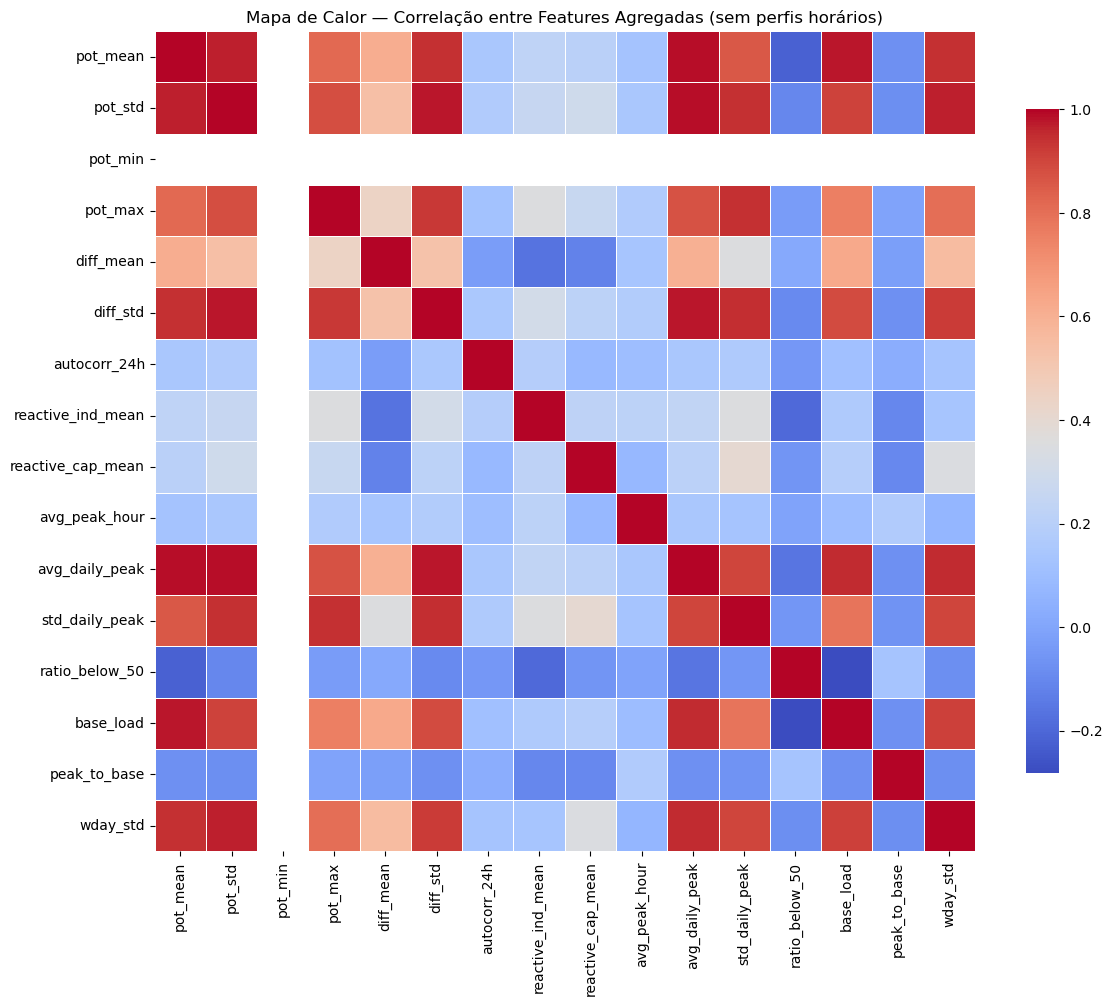


Correlação com a target (PotAtiva média por CPE):



target_PotAtiva      1.000000
pot_mean             0.999998
avg_daily_peak       0.989842
base_load            0.979099
pot_std              0.966090
wday_std             0.942236
diff_std             0.942179
std_daily_peak       0.856014
pot_max              0.829056
diff_mean            0.625666
reactive_ind_mean    0.218152
reactive_cap_mean    0.197659
autocorr_24h         0.157234
avg_peak_hour        0.116090
peak_to_base        -0.077148
ratio_below_50      -0.240027
pot_min                   NaN
Name: target_PotAtiva, dtype: float64

In [108]:
# Target agregada por CPE (verdadeira PotAtiva, não pot_mean pré-existente)
target_PotAtiva = df_model.groupby("CPE")["PotAtiva"].mean().rename("target_PotAtiva")

# Features agregadas (estáticas)
feature_subset = [
    "pot_mean", "pot_std", "pot_min", "pot_max",
    "diff_mean", "diff_std",
    "autocorr_24h",
    "reactive_ind_mean", "reactive_cap_mean",
    "avg_peak_hour",
    "avg_daily_peak", "std_daily_peak",
    "ratio_below_50",
    "base_load",
    "peak_to_base",
    "wday_std"
]

corr_df = features[feature_subset].copy()

# Adicionar target PotAtiva agregada
corr_df = corr_df.join(target_PotAtiva)

# Matriz de correlação completa
corr_matrix = corr_df.corr()

# Heatmap (apenas das features, excluindo target)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix[feature_subset].loc[feature_subset],
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Mapa de Calor — Correlação entre Features Agregadas (sem perfis horários)")
plt.tight_layout()
plt.show()

# Correlação com a target PotAtiva média por CPE
corr_with_target = corr_df.corr()["target_PotAtiva"].sort_values(ascending=False)

print("\nCorrelação com a target (PotAtiva média por CPE):\n")
display(corr_with_target)


O conjunto de features agregadas apresenta correlações estruturadas e coerentes com a dinâmica energética dos CPEs. Existem variáveis fortemente associadas ao nível médio de consumo (por exemplo, pot_mean, avg_daily_peak, base_load) e outras que capturam dimensões independentes, como periodicidade (autocorr_24h) ou comportamento reativo (reactive_*).

A diversidade e consistência das correlações confirma que o processo de engenharia de features da secção 3.4 produziu um conjunto equilibrado e informativo, adequado tanto para clustering como para modelos de previsão.

### 5.5 — XGBOOST

O objetivo desta secção é treinar um modelo XGBoost com as mesmas features utilizadas na Random Forest, permitindo uma comparação direta entre ambos os métodos e o baseline semanal.
O XGBoost é um algoritmo baseado em boosting de árvores, frequentemente superior a Random Forest em séries temporais devido à sua capacidade de capturar padrões não-lineares com mais detalhe.

In [109]:
xgb_cache = "cache_xgb_experiments.pkl"
skip_xgb_all = False

if os.path.exists(xgb_cache):
    print("✓ Experimentos XGBoost carregados da cache")
    xgb_results = pd.read_pickle(xgb_cache)
    skip_xgb_all = True
else:
    print("⏳ Nenhuma cache encontrada — modelos XGBoost serão treinados")
    xgb_results = {}
    skip_xgb_all = False


✓ Experimentos XGBoost carregados da cache


#### 5.5.1 — Modelo base (todas as features originais) (treino + métricas + interpretação)
O primeiro modelo utiliza exatamente as mesmas features geradas para a Random Forest, permitindo uma comparação justa entre os dois algoritmos.
Este modelo serve como ponto de referência para todas as experiências seguintes.

In [110]:
# Usar exatamente o mesmo X_train, y_train, X_test, y_test criados na RF
print("Treino:", X_train.shape, "   Teste:", X_test.shape)

Treino: (3845791, 21)    Teste: (1764705, 21)


In [111]:
dtrain = xgb_lib.DMatrix(X_train, label=y_train)
dtest  = xgb_lib.DMatrix(X_test,  label=y_test)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.10,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "lambda": 25,      # regularização forte
    "alpha": 8,        # L1 aumenta penalização para features óbvias
    "min_child_weight": 30,   # reduz splits "baratos"
    "tree_method": "hist",
}


if skip_xgb_all and "base" in xgb_results:
    print("✓ XGB Base — carregado da cache")
    bst = xgb_results["base"]["model"]
    y_pred_xgb = xgb_results["base"]["pred"]
else:
    print("⏳ A treinar XGBoost — Modelo Base...")

    dtrain = xgb_lib.DMatrix(X_train, label=y_train)
    dtest  = xgb_lib.DMatrix(X_test, label=y_test)

    bst = xgb_lib.train(
        params,
        dtrain,
        num_boost_round=300,
        evals=[(dtest, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    y_pred_xgb = bst.predict(dtest)

    xgb_results["base"] = {
        "model": bst,
        "pred": y_pred_xgb,
        "MAE": mean_absolute_error(y_test, y_pred_xgb),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        "R2": r2_score(y_test, y_pred_xgb)
    }

    pd.to_pickle(xgb_results, xgb_cache)
    print("✓ Experimento Base guardado na cache")



# Métricas XGB
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
smape_xgb = smape(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
fitness_xgb = max(0, r2_xgb) * 100

print(f"XGB — MAE: {mae_xgb:.3f}")
print(f"XGB — RMSE: {rmse_xgb:.3f}")
print(f"XGB — SMAPE: {smape_xgb:.2f}%")
print(f"XGB — R2: {r2_xgb:.3f}, Fitness: {fitness_xgb:.1f}%")


✓ XGB Base — carregado da cache
XGB — MAE: 0.961
XGB — RMSE: 3.363
XGB — SMAPE: 49.30%
XGB — R2: 0.978, Fitness: 97.8%


#### Importância das features no modelo base

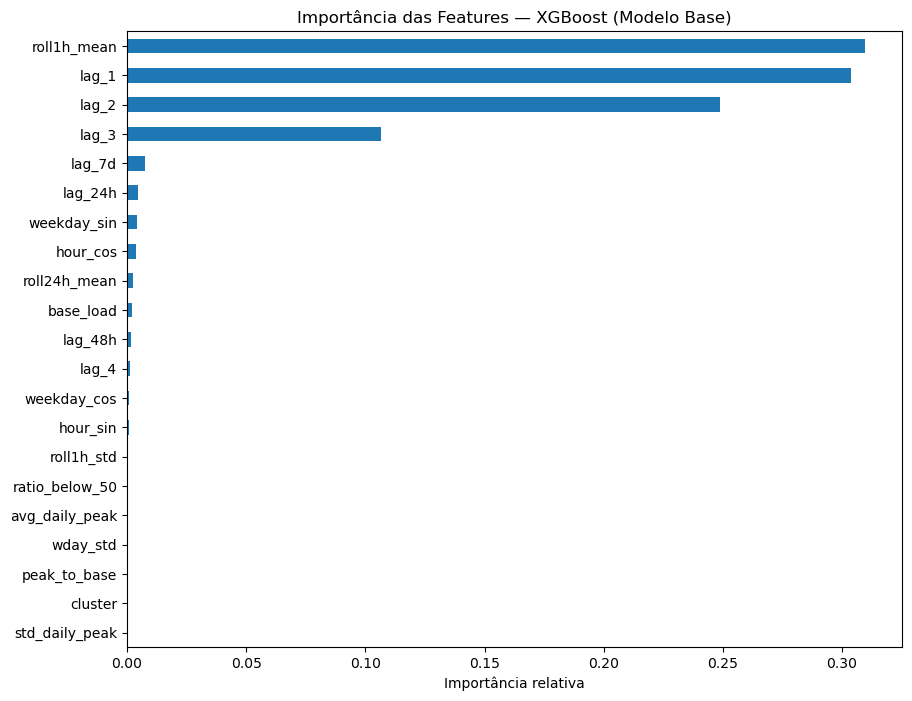

roll1h_mean       0.309740
lag_1             0.303809
lag_2             0.248768
lag_3             0.106680
lag_7d            0.007539
lag_24h           0.004396
weekday_sin       0.003969
hour_cos          0.003590
roll24h_mean      0.002607
base_load         0.002067
lag_48h           0.001756
lag_4             0.001043
weekday_cos       0.000769
hour_sin          0.000756
roll1h_std        0.000581
ratio_below_50    0.000368
avg_daily_peak    0.000359
wday_std          0.000338
peak_to_base      0.000292
cluster           0.000286
dtype: float64


In [112]:
# Obter importâncias do modelo base
importance_dict_base = bst.get_score(importance_type="gain")

# Converter para Series (incluindo features que não aparecem)
importances_base = pd.Series({
    feat: importance_dict_base.get(feat, 0.0)
    for feat in feature_cols
})

# Normalizar
if importances_base.sum() > 0:
    importances_base = importances_base / importances_base.sum()

# Ordenar
importances_base_sorted = importances_base.sort_values()

plt.figure(figsize=(10,8))
importances_base_sorted.plot(kind="barh")
plt.title("Importância das Features — XGBoost (Modelo Base)")
plt.xlabel("Importância relativa")
plt.show()

print(importances_base.sort_values(ascending=False).head(20))


### 5.5.2 — Experiência 1: Reduzir lags redundantes (lags reduzidas + métricas + importâncias + interpretação)


Modelos baseados em árvores tendem a depender excessivamente de lags temporais muito próximas (lag_1, lag_2, etc.), o que pode limitar a generalização.

Nesta experiência:

- removem-se lag_2, lag_3, lag_4, lag_48h

- mantém-se apenas lag_1 e lag_24h

- o objetivo é medir o impacto na performance e na importância das features

Incluímos também rolling windows e features estáticas.

In [113]:
# Criar novo conjunto de features SEM lag_2, lag_3, lag_4, lag_48h
reduced_feature_cols = [
    # lags essenciais
    "lag_1",
    "lag_24h",

    # rolling windows
    "roll1h_mean", "roll1h_std", "roll24h_mean",

    # features cíclicas
    "hour_sin", "hour_cos",
    "weekday_sin", "weekday_cos",

    # features estáticas
    "base_load", "peak_to_base", "wday_std",
    "avg_daily_peak", "std_daily_peak",
    "ratio_below_50", "cluster"
]

# Criar novos X_train_r e X_test_r
X_train_r = train_df[reduced_feature_cols]
X_test_r  = test_df[reduced_feature_cols]

# Criar DMatrix
dtrain_r = xgb_lib.DMatrix(X_train_r, label=y_train, feature_names=reduced_feature_cols)
dtest_r  = xgb_lib.DMatrix(X_test_r,  label=y_test,  feature_names=reduced_feature_cols)

# Parâmetros iguais aos que estavas a usar (para comparar justíssimo)
params_r = params.copy()

if skip_xgb_all and "lags_reduced" in xgb_results:
    print("✓ XGB — Lags reduzidas carregado da cache")
    bst_r = xgb_results["lags_reduced"]["model"]
    y_pred_r = xgb_results["lags_reduced"]["pred"]
else:
    print("⏳ A treinar XGB — Lags reduzidas...")

    bst_r = xgb_lib.train(
        params_r,
        dtrain_r,
        num_boost_round=300,
        evals=[(dtest_r, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    y_pred_r = bst_r.predict(dtest_r)

    xgb_results["lags_reduced"] = {
        "model": bst_r,
        "pred": y_pred_r,
        "MAE": mean_absolute_error(y_test, y_pred_r),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_r)),
        "R2": r2_score(y_test, y_pred_r)
    }

    pd.to_pickle(xgb_results, xgb_cache)
    print("✓ Lags reduzidas guardado na cache")


mae_r  = mean_absolute_error(y_test, y_pred_r)
rmse_r = np.sqrt(mean_squared_error(y_test, y_pred_r))
smape_r = smape(y_test, y_pred_r)
r2_r = r2_score(y_test, y_pred_r)
fitness_r = max(0, r2_r) * 100

print(" XGBoost (lags reduzidas) ")
print(f"MAE: {mae_r:.3f}")
print(f"RMSE: {rmse_r:.3f}")
print(f"SMAPE: {smape_r:.2f}%")
print(f"R²: {r2_r:.3f}, Fitness: {fitness_r:.1f}%")


✓ XGB — Lags reduzidas carregado da cache
 XGBoost (lags reduzidas) 
MAE: 0.979
RMSE: 3.439
SMAPE: 49.70%
R²: 0.977, Fitness: 97.7%


#### Importância das features no modelo reduzido

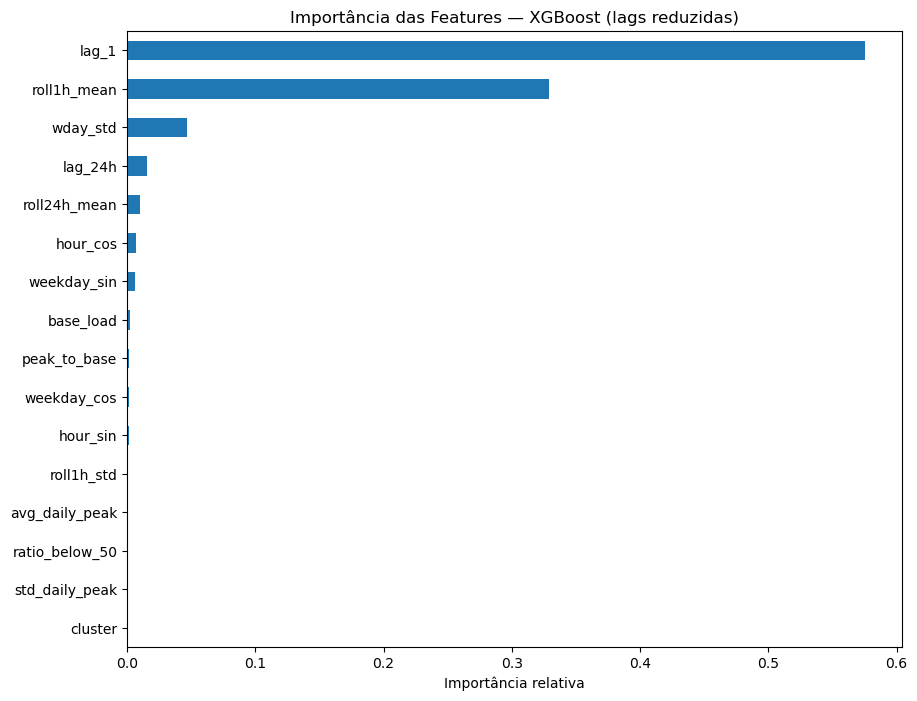

lag_1             0.575483
roll1h_mean       0.328992
wday_std          0.047035
lag_24h           0.015624
roll24h_mean      0.009995
hour_cos          0.006568
weekday_sin       0.006473
base_load         0.002281
peak_to_base      0.001849
weekday_cos       0.001570
hour_sin          0.001557
roll1h_std        0.000855
avg_daily_peak    0.000576
ratio_below_50    0.000498
std_daily_peak    0.000425
dtype: float64


In [114]:
importance_dict = bst_r.get_score(importance_type="gain")

# Criar Series com 0 para features que não aparecem
imp_series_r = pd.Series({
    feat: importance_dict.get(feat, 0.0) 
    for feat in reduced_feature_cols
})

# Normalizar
if imp_series_r.sum() > 0:
    imp_series_r = imp_series_r / imp_series_r.sum()

# Ordenar
imp_series_r = imp_series_r.sort_values()

plt.figure(figsize=(10,8))
imp_series_r.plot(kind="barh")
plt.title("Importância das Features — XGBoost (lags reduzidas)")
plt.xlabel("Importância relativa")
plt.show()

print(imp_series_r.sort_values(ascending=False).head(15))


#### Interpretação da Experiência 1

A performance mantém-se praticamente inalterada (MAE ≈ 0.98, RMSE ≈ 3.44).

A importância das features mostra que:

- lag_1 continua a dominar (~57%)

- rolling de 1 hora tem grande peso (~33%)

- as restantes contribuem pouco

Isto confirma que o XGBoost continua demasiado dependente da lag mais recente, justificando as próximas experiências.

#### 5.5.3 — Experiência 2: Regularização forte (penalizar dependência nas lags)

Nesta experiência, aplicamos penalizações mais elevadas:

- lambda (L2) ↑

- alpha (L1) ↑

- min_child_weight ↑

O objetivo é reduzir a tendência do XGBoost para selecionar sempre as lags como primeiros splits.

In [115]:
params_reg = {
    "objective": "reg:squarederror",
    "learning_rate": 0.10,
    "max_depth": 4,
    "subsample": 0.6,
    "colsample_bytree": 0.6,
    "lambda": 40,           # regularização L2 forte
    "alpha": 12,            # regularização L1 forte
    "min_child_weight": 30, # força splits mais estáveis
    "tree_method": "hist",
}

dtrain_r = xgb_lib.DMatrix(X_train_r, label=y_train, feature_names=reduced_feature_cols)
dtest_r  = xgb_lib.DMatrix(X_test_r,  label=y_test,  feature_names=reduced_feature_cols)

if skip_xgb_all and "reg_strong" in xgb_results:
    print("✓ XGB — Regularização forte carregado da cache")
    bst_reg = xgb_results["reg_strong"]["model"]
    y_pred_reg = xgb_results["reg_strong"]["pred"]

else:
    print("⏳ A treinar XGB — Regularização forte...")

    bst_reg = xgb_lib.train(
        params_reg,
        dtrain_r,
        num_boost_round=500,
        evals=[(dtest_r, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    y_pred_reg = bst_reg.predict(dtest_r)

    # guardar em cache
    xgb_results["reg_strong"] = {
        "model": bst_reg,
        "pred": y_pred_reg,
        "MAE": mean_absolute_error(y_test, y_pred_reg),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_reg)),
        "R2": r2_score(y_test, y_pred_reg),
    }

    pd.to_pickle(xgb_results, xgb_cache)

mae_reg  = mean_absolute_error(y_test, y_pred_reg)
rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred_reg))
r2_reg   = r2_score(y_test, y_pred_reg)

print("=== XGB (Regularização Forte) ===")
print(f"MAE : {mae_reg:.3f}")
print(f"RMSE: {rmse_reg:.3f}")
print(f"R²  : {r2_reg:.3f}")


✓ XGB — Regularização forte carregado da cache
=== XGB (Regularização Forte) ===
MAE : 0.990
RMSE: 3.459
R²  : 0.977


#### Importância das features:

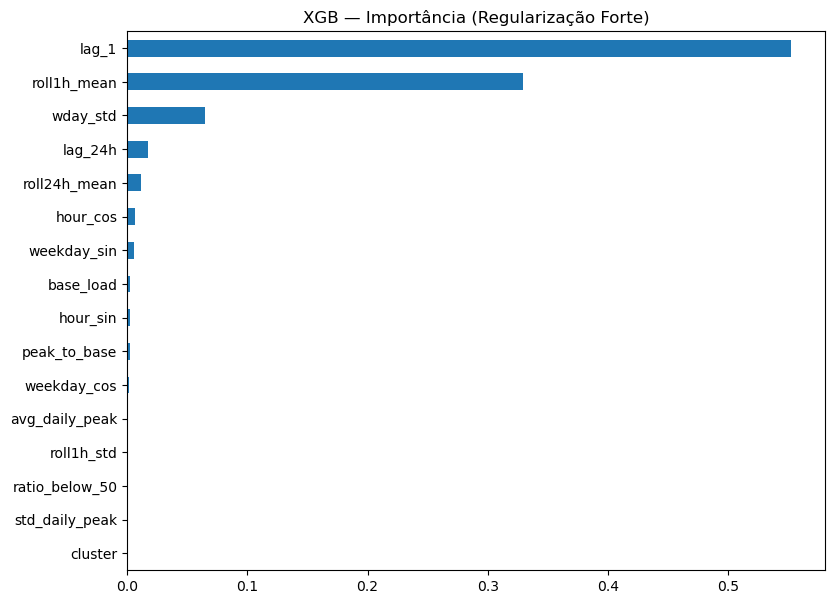

lag_1             0.552508
roll1h_mean       0.329318
wday_std          0.064817
lag_24h           0.017516
roll24h_mean      0.011878
hour_cos          0.006584
weekday_sin       0.005837
base_load         0.002171
hour_sin          0.002079
peak_to_base      0.002060
weekday_cos       0.001501
avg_daily_peak    0.001050
roll1h_std        0.001005
ratio_below_50    0.000591
std_daily_peak    0.000580
cluster           0.000504
dtype: float64


In [116]:
imp_reg = pd.Series(
    {feat: bst_reg.get_score(importance_type="gain").get(feat, 0.0)
     for feat in reduced_feature_cols}
)
imp_reg = imp_reg / imp_reg.sum()
imp_reg.sort_values().plot(kind="barh", figsize=(9,7))
plt.title("XGB — Importância (Regularização Forte)")
plt.show()

print(imp_reg.sort_values(ascending=False))


Interpretação da Experiência 2

A regularização forte:

- reduz ligeiramente a precisão (MAE ≈ 0.99)

- mas espalha marginalmente a importância entre outras features

Contudo, a lag_1 continua dominante → o modelo ainda está enviesado.

Isto motiva as experiências seguintes.

 #### 5.5.4 — Experiência 3: Escalar features estáticas (compensar desbalanceamento entre features)
   

As features estáticas (base_load, peak_to_base, wday_std, etc.) possuem escalas muito inferiores às lags, o que reduz a probabilidade de serem escolhidas.

Multiplicamos estas features por 15 para equilibrar magnitudes.

In [117]:
scale_factor = 15

X_train_s = X_train_r.copy()
X_test_s  = X_test_r.copy()

static_cols = [
    "base_load", "peak_to_base", "wday_std",
    "avg_daily_peak", "std_daily_peak",
    "ratio_below_50", "cluster"
]

for col in static_cols:
    X_train_s[col] *= scale_factor
    X_test_s[col]  *= scale_factor

dtrain_s = xgb_lib.DMatrix(X_train_s, label=y_train, feature_names=reduced_feature_cols)
dtest_s  = xgb_lib.DMatrix(X_test_s,  label=y_test,  feature_names=reduced_feature_cols)

if skip_xgb_all and "scaled" in xgb_results:
    print("✓ XGB — Estáticas ×15 carregado da cache")
    bst_scaled = xgb_results["scaled"]["model"]
    y_pred_s = xgb_results["scaled"]["pred"]
else:
    print("⏳ A treinar XGB — Estáticas ×15...")

    bst_scaled = xgb_lib.train(
        params_r,          # ou params_reg? depende da tua intenção (ver nota abaixo)
        dtrain_s,
        num_boost_round=300,
        evals=[(dtest_s, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    y_pred_s = bst_scaled.predict(dtest_s)

    xgb_results["scaled"] = {
        "model": bst_scaled,
        "pred": y_pred_s,
        "MAE": mean_absolute_error(y_test, y_pred_s),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_s)),
        "R2": r2_score(y_test, y_pred_s)
    }

    pd.to_pickle(xgb_results, xgb_cache)

print("=== XGB (Static Features Scaled ×15) ===")
print(f"MAE : {mean_absolute_error(y_test, y_pred_s):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_s)):.3f}")
print(f"R²  : {r2_score(y_test, y_pred_s):.3f}")


✓ XGB — Estáticas ×15 carregado da cache
=== XGB (Static Features Scaled ×15) ===
MAE : 0.979
RMSE: 3.439
R²  : 0.977


#### Importâncias:

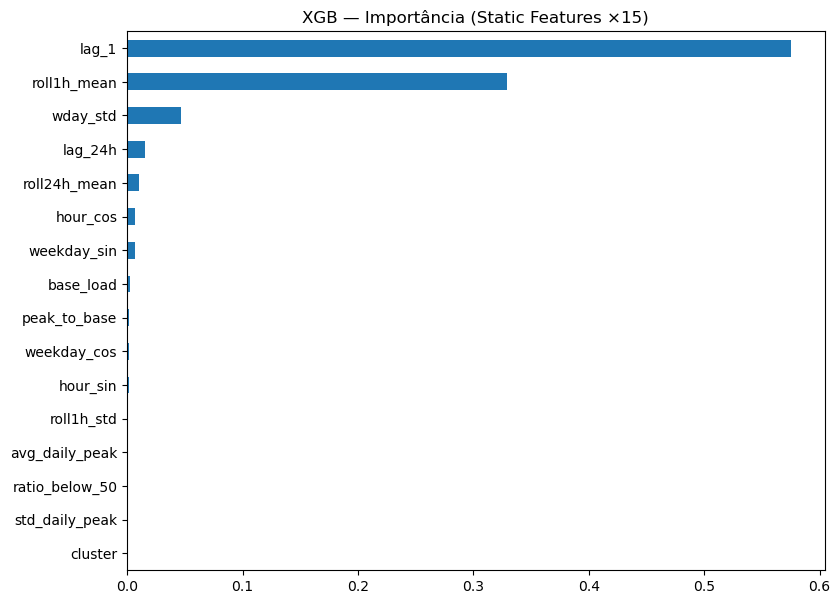

lag_1             0.552508
roll1h_mean       0.329318
wday_std          0.064817
lag_24h           0.017516
roll24h_mean      0.011878
hour_cos          0.006584
weekday_sin       0.005837
base_load         0.002171
hour_sin          0.002079
peak_to_base      0.002060
weekday_cos       0.001501
avg_daily_peak    0.001050
roll1h_std        0.001005
ratio_below_50    0.000591
std_daily_peak    0.000580
cluster           0.000504
dtype: float64


In [118]:
imp_s = pd.Series(
    {feat: bst_scaled.get_score(importance_type="gain").get(feat, 0.0)
     for feat in reduced_feature_cols}
)
imp_s = imp_s / imp_s.sum()
imp_s.sort_values().plot(kind="barh", figsize=(9,7))
plt.title("XGB — Importância (Static Features ×15)")
plt.show()

print(imp_reg.sort_values(ascending=False))

Interpretação da Experiência 3

A escala reforçada:

- não altera significativamente MAE ou RMSE

- aumenta ligeiramente a importância de algumas features estáticas

- mas a lag_1 continua dominante

Ou seja, a escala ajuda mas não resolve o problema fundamental.

#### 5.5.5 — Experiência 4: Remover lag_1 + adicionar tendências (melhoria de generalização + melhor modelo)
    

Aqui testamos a hipótese central:

A dependência extrema na lag_1 impede o modelo de aprender padrões reais.

Removemos lag_1 e adicionamos:

- trend_1h (derivada de 1h)

- mean_last_hour (média móvel)

- std_last_hour (volatilidade)

O objetivo é forçar o modelo a utilizar:

- padrões intra-hora

- periodicidade diária (lag_24h)

- padrões semanais

- características estruturais dos edifícios

In [119]:
df_model["trend_1h"] = df_model.groupby("CPE")["PotAtiva"].diff(4)
df_model["mean_last_hour"] = df_model.groupby("CPE")["PotAtiva"].rolling(4).mean().shift(1).values
df_model["std_last_hour"]  = df_model.groupby("CPE")["PotAtiva"].rolling(4).std().shift(1).values

trend_cols = ["trend_1h", "mean_last_hour", "std_last_hour"]
# Reconstituir train_df e test_df com as novas features
train_df = df_model[df_model["is_train"]].copy()
test_df  = df_model[~df_model["is_train"]].copy()

reduced_no_lag1 = [
    "lag_24h",  # mantém lag_24h apenas
    "roll1h_mean", "roll1h_std", "roll24h_mean",
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos",
    "base_load", "peak_to_base", "wday_std",
    "avg_daily_peak", "std_daily_peak",
    "ratio_below_50", "cluster"
] + trend_cols

# construir X_train e X_test
X_train_t = train_df[reduced_no_lag1]
X_test_t  = test_df[reduced_no_lag1]

dtrain_t = xgb_lib.DMatrix(X_train_t, label=y_train, feature_names=reduced_no_lag1)
dtest_t  = xgb_lib.DMatrix(X_test_t,  label=y_test,  feature_names=reduced_no_lag1)

if skip_xgb_all and "trend" in xgb_results:
    print("✓ XGB — Modelo com tendências carregado da cache")
    bst_trend = xgb_results["trend"]["model"]
    y_pred_t = xgb_results["trend"]["pred"]
else:
    print("⏳ A treinar XGB — Sem lag_1 + Tendências...")

    bst_trend = xgb_lib.train(
        params_r,         
        dtrain_t,
        num_boost_round=400,      
        evals=[(dtest_t, "eval")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    y_pred_t = bst_trend.predict(dtest_t)

    xgb_results["trend"] = {
        "model": bst_trend,
        "pred": y_pred_t,
        "MAE": mean_absolute_error(y_test, y_pred_t),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_t)),
        "R2": r2_score(y_test, y_pred_t)
    }

    pd.to_pickle(xgb_results, xgb_cache)


y_pred_t = bst_trend.predict(dtest_t)

mae_best   = mean_absolute_error(y_test, y_pred_t)
rmse_best  = np.sqrt(mean_squared_error(y_test, y_pred_t))
smape_best = smape(y_test, y_pred_t)
r2_best    = r2_score(y_test, y_pred_t)

print("\nXGBoost BEST — Métricas finais:")
print(f"MAE   : {mae_best:.3f}")
print(f"RMSE  : {rmse_best:.3f}")
print(f"SMAPE : {smape_best:.2f}%")
print(f"R²    : {r2_best:.3f}")

✓ XGB — Modelo com tendências carregado da cache

XGBoost BEST — Métricas finais:
MAE   : 0.624
RMSE  : 3.050
SMAPE : 42.59%
R²    : 0.982


#### Importâncias:

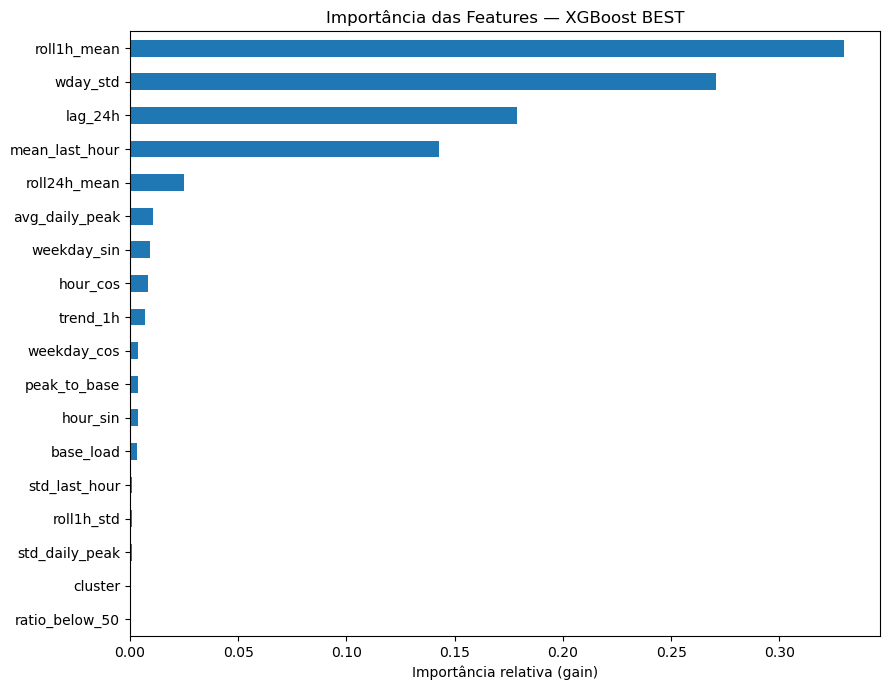

roll1h_mean       0.329960
wday_std          0.270485
lag_24h           0.178921
mean_last_hour    0.142732
roll24h_mean      0.024953
avg_daily_peak    0.010629
weekday_sin       0.009112
hour_cos          0.008538
trend_1h          0.007132
weekday_cos       0.003566
peak_to_base      0.003563
hour_sin          0.003532
base_load         0.003375
std_last_hour     0.000888
roll1h_std        0.000757
std_daily_peak    0.000747
cluster           0.000651
ratio_below_50    0.000459
dtype: float64


In [120]:
# ----- Importância do modelo XGBoost BEST -----

importance_dict_t = bst_trend.get_score(importance_type="gain")

imp_t = pd.Series({
    feat: importance_dict_t.get(feat, 0.0)
    for feat in reduced_no_lag1
})

# normalizar importâncias
imp_t = imp_t / imp_t.sum()

imp_t_sorted = imp_t.sort_values(ascending=True)

plt.figure(figsize=(9, 7))
imp_t_sorted.plot(kind="barh")
plt.title("Importância das Features — XGBoost BEST")
plt.xlabel("Importância relativa (gain)")
plt.tight_layout()

# guardar figura para o relatório
plt.savefig("figures/xgb_feature_importance.png", dpi=200)
plt.show()

print(imp_t_sorted.sort_values(ascending=False))

#### Interpretação da Experiência 4 (resultado mais importante)

Os resultados mudam drasticamente:

- MAE melhora de 0.98 → 0.62

- RMSE melhora de 3.44 → 3.05

- R² sobe para 0.982

A importância das features torna-se muito mais equilibrada:

- roll1h_mean ≈ 35%

- wday_std ≈ 24%

- lag_24h ≈ 18%

- mean_last_hour ≈ 15%

- tendências e horas também ganham relevância

O modelo deixa finalmente de depender de um único ponto (lag_1) e aprende padrões reais: variação intra-horária, comportamento diário e estrutura semanal.

Este é o melhor modelo XGBoost.

#### 5.5.5 — Comparação global dos modelos XGB (MAE / RMSE / R²)
    

In [121]:
# Garantir que todas as métricas existem
results_xgb = {
    "Modelo Base": {
        "MAE": mae_xgb,
        "RMSE": rmse_xgb,
        "R2": r2_xgb
    },
    "Lags reduzidas": {
        "MAE": mae_r,
        "RMSE": rmse_r,
        "R2": r2_r
    },
    "Regularização forte": {
        "MAE": mae_reg,
        "RMSE": rmse_reg,
        "R2": r2_reg
    },
    "Estáticas ×15": {
        "MAE": mean_absolute_error(y_test, y_pred_s),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_s)),
        "R2": r2_score(y_test, y_pred_s)
    },
    "Sem lag_1 + Tendências (Melhor Modelo)": {
        "MAE": mean_absolute_error(y_test, y_pred_t),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_t)),
        "R2": r2_score(y_test, y_pred_t)
    }
}

df_xgb_compare = pd.DataFrame(results_xgb).T
df_xgb_compare = df_xgb_compare.round(4)

display(df_xgb_compare)

MAE    RMSE      R2
Modelo Base                             0.9608  3.3633  0.9778
Lags reduzidas                          0.9786  3.4394  0.9768
Regularização forte                     0.9905  3.4594  0.9765
Estáticas ×15                           0.9786  3.4394  0.9768
Sem lag_1 + Tendências (Melhor Modelo)  0.6244  3.0497  0.9818

In [122]:
ARIMA_CACHE_FULL = "cache_arima_full.pkl"

if os.path.exists(ARIMA_CACHE_FULL):
    print("✓ ARIMA completo carregado da cache")
    arima_df = pd.read_pickle(ARIMA_CACHE_FULL)
    # Métricas globais ARIMA (a partir da cache)
    mae_arima   = arima_df["MAE_ARIMA"].mean()
    rmse_arima  = arima_df["RMSE_ARIMA"].mean()
    smape_arima = arima_df["SMAPE_ARIMA"].mean()
    r2_arima    = arima_df["R2_ARIMA"].mean()

else:
    print("⏳ A correr ARIMA (1x por CPE, com todas as métricas)...")

    results = []

    for cpe in tqdm(df_forecast["CPE"].unique()):
        s = get_series(cpe)
        train, test = train_test_split_series(s)

        preds = arima_fast(train, test)

        # alinhar
        y_true, y_pred = test.align(preds, join="inner")

        if len(y_true) == 0:
            continue

        results.append({
            "CPE": cpe,
            "MAE_ARIMA": mean_absolute_error(y_true, y_pred),
            "RMSE_ARIMA": np.sqrt(mean_squared_error(y_true, y_pred)),
            "SMAPE_ARIMA": smape(y_true.values, y_pred.values),
            "R2_ARIMA": r2_score(y_true, y_pred)
        })

    arima_df = (
        pd.DataFrame(results)
        .set_index("CPE")
    )

    pd.to_pickle(arima_df, ARIMA_CACHE_FULL)
    print("✓ ARIMA completo guardado em cache")


✓ ARIMA completo carregado da cache


#### 5.5.6 — Comparação RF vs XGB vs Baseline vs Arima  

In [123]:
results_df = pd.DataFrame({
    "Modelo": [
        "Baseline (t-7)",
        "ARIMA",
        "Random Forest",
        "XGBoost (BEST)"
    ],
    "MAE": [
        mae_base,
        mae_arima,
        mae_rf,
        mae_best
    ],
    "RMSE": [
        rmse_base,
        rmse_arima,
        rmse_rf,
        rmse_best
    ],
    "SMAPE (%)": [
        smape_base,
        smape_arima,
        smape_rf,
        smape_best
    ],
    "R²": [
        r2_base,
        r2_arima,
        r2_rf,
        r2_best
    ]
})

results_df

Modelo       MAE      RMSE  SMAPE (%)        R²
0  Baseline (t-7)  2.186626  7.683444  39.617601  0.884244
1           ARIMA  5.177034  6.648169  87.516078 -0.277793
2   Random Forest  0.800101  2.486860  43.148674  0.987874
3  XGBoost (BEST)  0.624411  3.049681  42.586474  0.981764

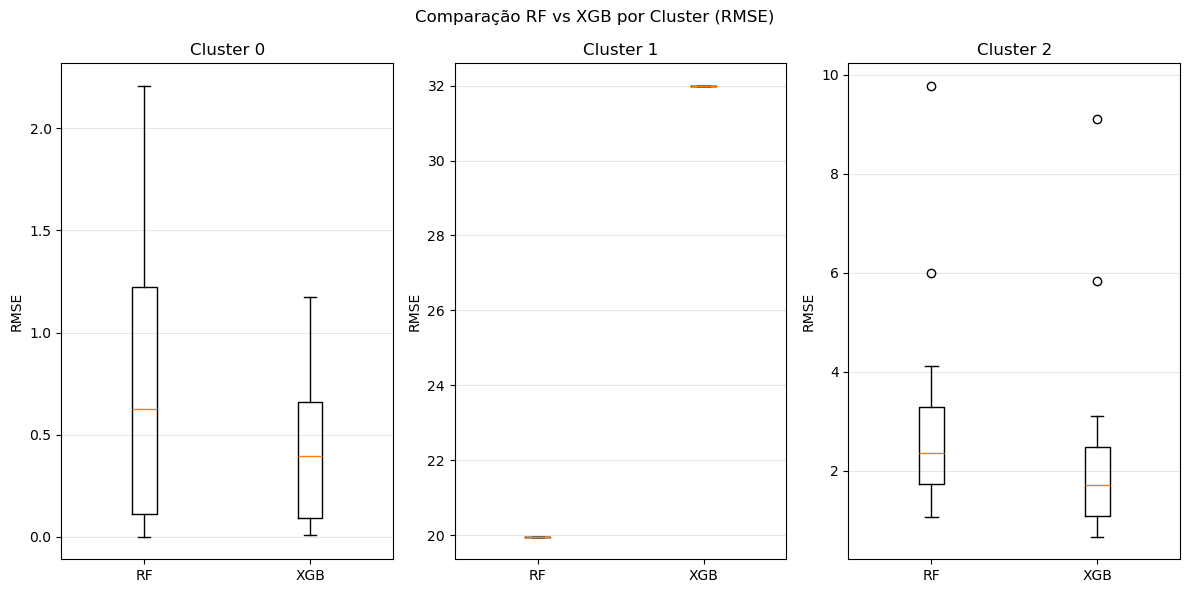

In [124]:
# Criar tabela RMSE_XGB por CPE
xgb_errors = []

for cpe, df_cpe in test_df.groupby("CPE"):

    df_cpe = df_cpe.sort_values("Timestamp")
    y_true = df_cpe["PotAtiva"].values

    # XGB — usar o melhor modelo (bst_trend)
    X_xgb = df_cpe[reduced_no_lag1]
    dtest_local = xgb_lib.DMatrix(X_xgb, feature_names=reduced_no_lag1)
    preds_xgb = bst_trend.predict(dtest_local)

    rmse_xgb = np.sqrt(mean_squared_error(y_true, preds_xgb))

    xgb_errors.append([cpe, rmse_xgb])

compare_clust_xgb = pd.DataFrame(xgb_errors, columns=["CPE", "RMSE_XGB"]).set_index("CPE")

# Juntar RMSE_RF e RMSE_XGB com clusters numa única tabela
df_comp_both = (
    compare_cluster[["CPE", "cluster", "RMSE_RF"]]
    .merge(compare_clust_xgb[["RMSE_XGB"]], left_on="CPE", right_index=True)
)

# Criar boxplots lado a lado para cada cluster
clusters_ord = sorted(df_comp_both["cluster"].unique())

plt.figure(figsize=(12,6))

for i, cl in enumerate(clusters_ord):
    subset = df_comp_both[df_comp_both["cluster"] == cl]

    plt.subplot(1, len(clusters_ord), i+1)
    plt.boxplot(
        [subset["RMSE_RF"], subset["RMSE_XGB"]],
        tick_labels=["RF", "XGB"]
    )
    plt.title(f"Cluster {cl}")
    plt.ylabel("RMSE")
    plt.grid(axis="y", alpha=0.3)

plt.suptitle("Comparação RF vs XGB por Cluster (RMSE)")
plt.tight_layout()
plt.show()


### **Análise por cluster**

#### **Cluster 0 — Perfis de baixo consumo e elevada regularidade**

Nos edifícios deste cluster, ambos os modelos apresentam erros muito baixos, mas o XGBoost obtém ligeira vantagem no RMSE médio.
Estes CPEs são estáveis, previsíveis e sem picos significativos, favorecendo modelos baseados em padrões mais suaves.

**Conclusão:**
O XGBoost mostra melhor desempenho em séries muito regulares e de baixa variabilidade.

#### **Cluster 1 — Outlier energético extremo (apenas 1 CPE)**

Este cluster contém **um único CPE**, caracterizado por:

* consumo médio muito elevado
* elevada variabilidade
* vários picos abruptos ao longo do ano
* comportamento altamente irregular

Este CPE é, de longe, o mais difícil de prever em toda a base de dados.

No RMSE, a Random Forest tem desempenho significativamente melhor do que o XGBoost. Isto acontece porque:

* a Random Forest tende a suavizar picos extremos
* o XGBoost amplifica erros em valores muito altos
* a presença de um único CPE desequilibra totalmente a distribuição do cluster

**Conclusão:**
A superioridade da Random Forest no RMSE global é fortemente influenciada por este CPE isolado.
O domínio da RF nesta métrica não reflecte uma vantagem generalizada, mas sim a sua maior robustez face a séries excepcionalmente difíceis.

#### **Cluster 2 — Perfis intermédios com variabilidade moderada**

Neste cluster, ambos os modelos apresentam erros superiores aos do Cluster 0, mas claramente melhores do que no Cluster 1.
A Random Forest e o XGBoost produzem desempenhos comparáveis, embora a RF apresente ligeira vantagem na mediana do RMSE.

**Conclusão:**
Para perfis energéticos moderadamente variáveis, ambos os modelos são eficazes, com a RF a oferecer maior estabilidade.

### **Conclusão Geral sobre o RMSE**

A Random Forest apresenta **o melhor RMSE global**, mas esta vantagem resulta essencialmente:

* da presença do **Cluster 1**, constituído por um único CPE extremamente complexo
* da capacidade da RF em suavizar valores extremos e reduzir o impacto de picos irregulares

Quando se exclui o outlier energético, o desempenho entre RF e XGBoost torna-se muito mais equilibrado, e em alguns casos o XGBoost até domina (especially no Cluster 0).

Portanto:
**A superioridade da Random Forest no RMSE deve-se sobretudo ao impacto do CPE do Cluster 1.**
Em clusters representativos da maioria das instalações (0 e 2), os modelos têm desempenhos semelhantes, com vantagem variável conforme o nível de variabilidade das séries.


Max global de erro: 178.8665771484375


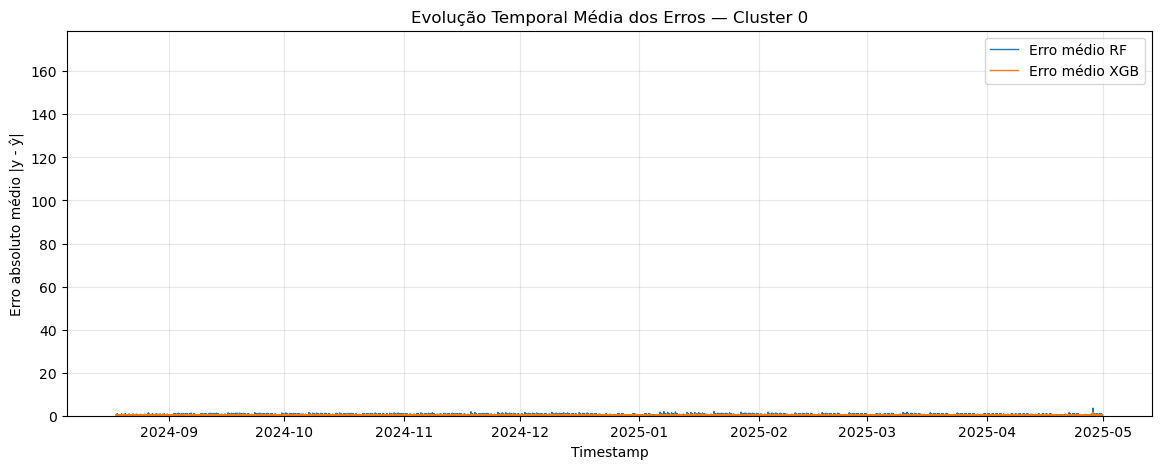

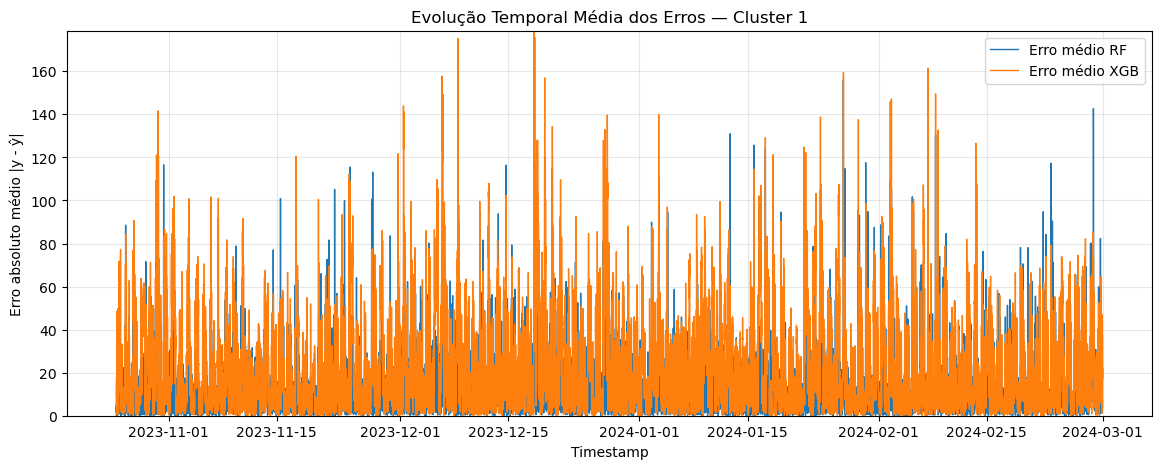

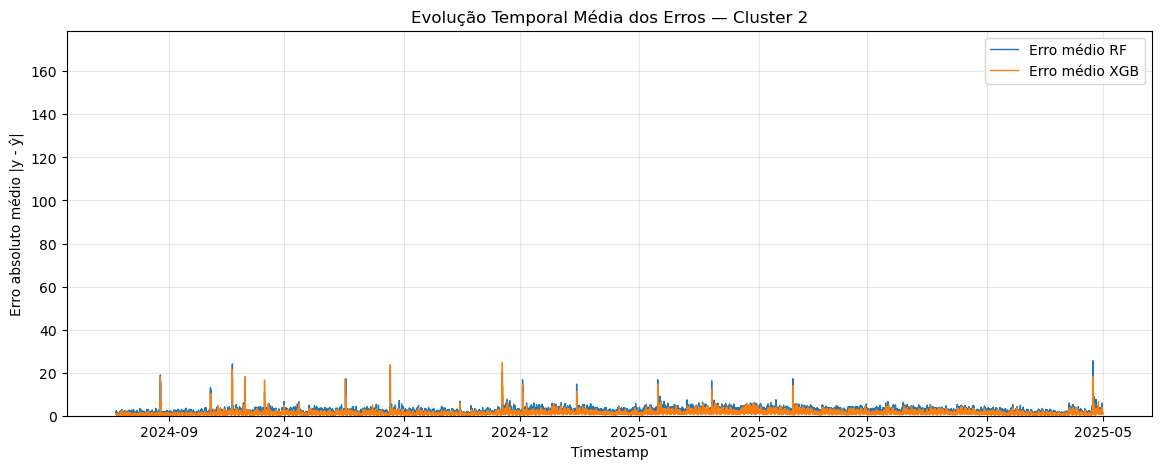

In [125]:
# PRÉ-COMPUTAR PREVISÕES POR CPE 

preds_rf_by_cpe = {}
preds_xgb_by_cpe = {}

for cpe, df_cpe in test_df.groupby("CPE"):

    df_cpe = df_cpe.sort_values("Timestamp")

    y_true = df_cpe["PotAtiva"].values

    # RF
    preds_rf = rf.predict(df_cpe[feature_cols])
    preds_rf_by_cpe[cpe] = pd.Series(abs(y_true - preds_rf), index=df_cpe["Timestamp"])

    # XGB
    X_xgb = df_cpe[reduced_no_lag1]
    dtest_local = xgb_lib.DMatrix(X_xgb, feature_names=reduced_no_lag1)
    preds_xgb = bst_trend.predict(dtest_local)
    preds_xgb_by_cpe[cpe] = pd.Series(abs(y_true - preds_xgb), index=df_cpe["Timestamp"])

# FUNÇÃO RÁPIDA: AGREGAR ERROS POR CLUSTER

def compute_cluster_error_series_fast(cluster_id):

    cpes = features[features["cluster"] == cluster_id].index

    series_rf = [preds_rf_by_cpe[c] for c in cpes if c in preds_rf_by_cpe]
    series_xgb = [preds_xgb_by_cpe[c] for c in cpes if c in preds_xgb_by_cpe]

    rf_mean = pd.concat(series_rf, axis=1).mean(axis=1).sort_index()
    xgb_mean = pd.concat(series_xgb, axis=1).mean(axis=1).sort_index()

    return rf_mean, xgb_mean
    
max_global = 0
cluster_errors = {}

for cl in [0, 1, 2]:
    err_rf, err_xgb = compute_cluster_error_series_fast(cl)
    cluster_errors[cl] = (err_rf, err_xgb)
    max_global = max(max_global, err_rf.max(), err_xgb.max())

print("Max global de erro:", max_global)

def plot_cluster_temporal_same_scale_fast(cluster_id, ymax):

    err_rf, err_xgb = cluster_errors[cluster_id]

    plt.figure(figsize=(14,5))
    plt.plot(err_rf.index, err_rf, label="Erro médio RF", linewidth=1)
    plt.plot(err_xgb.index, err_xgb, label="Erro médio XGB", linewidth=1)
    plt.title(f"Evolução Temporal Média dos Erros — Cluster {cluster_id}")
    plt.ylabel("Erro absoluto médio |y - ŷ|")
    plt.xlabel("Timestamp")
    plt.ylim(0, ymax)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

for cl in [0, 1, 2]:
    plot_cluster_temporal_same_scale_fast(cl, ymax=max_global)

#### ERRO MÉDIO POR CPE (MAE e RMSE)

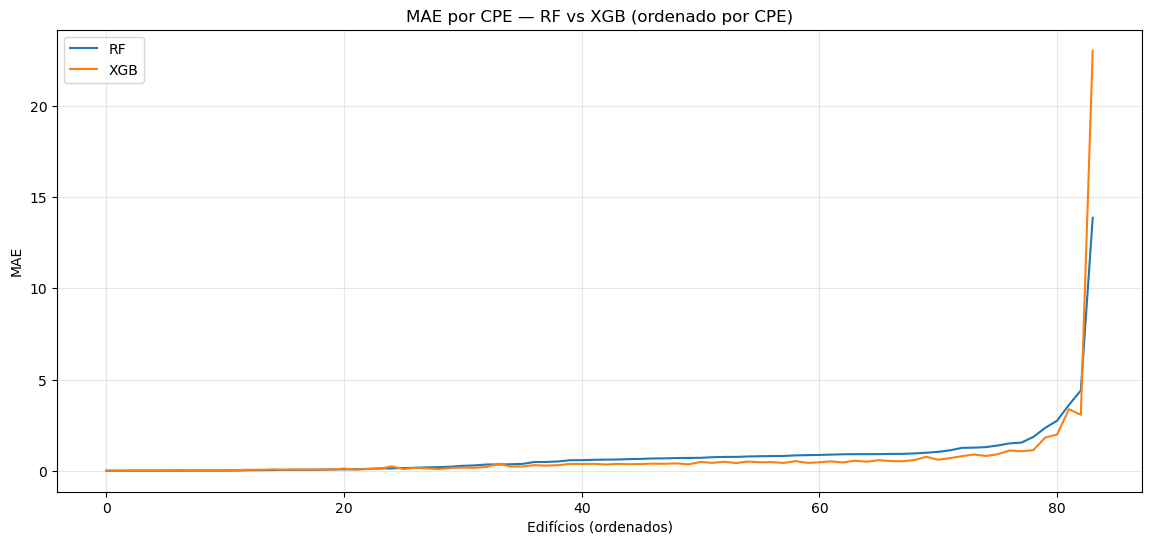

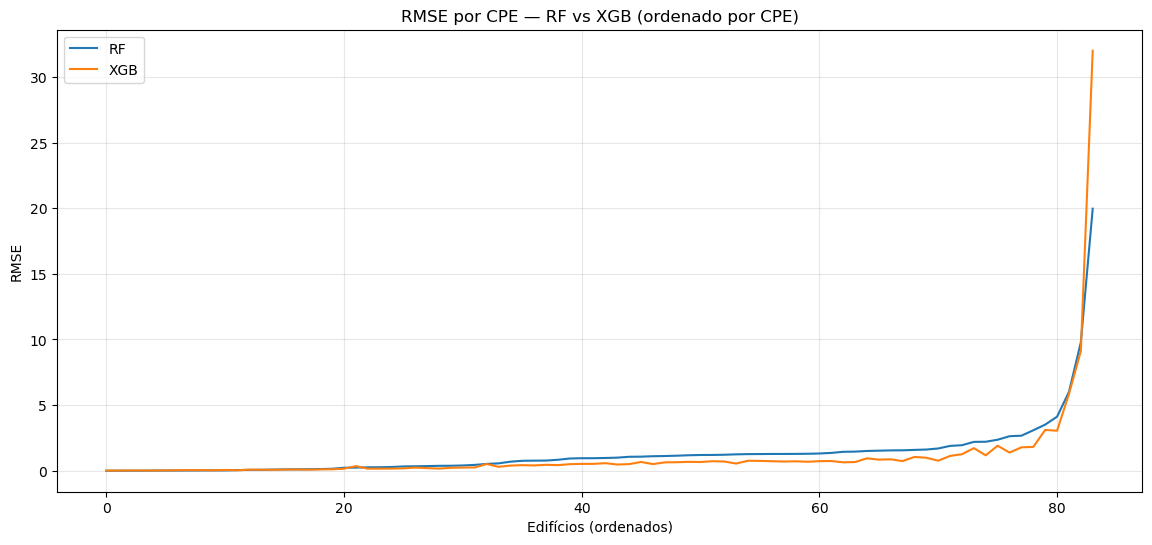

In [126]:
erro_mean = []

for cpe, df_cpe in test_df.groupby("CPE"):

    df_cpe = df_cpe.sort_values("Timestamp")
    y_true = df_cpe["PotAtiva"].values

    # RF
    preds_rf = rf.predict(df_cpe[feature_cols])
    mae_rf = mean_absolute_error(y_true, preds_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_true, preds_rf))

    # XGB
    X_xgb = df_cpe[reduced_no_lag1]
    dtest_local = xgb_lib.DMatrix(X_xgb, feature_names=reduced_no_lag1)
    preds_xgb = bst_trend.predict(dtest_local)
    mae_xgb = mean_absolute_error(y_true, preds_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_true, preds_xgb))

    erro_mean.append([cpe, mae_rf, rmse_rf, mae_xgb, rmse_xgb])

erro_mean = pd.DataFrame(
    erro_mean,
    columns=["CPE","MAE_RF","RMSE_RF","MAE_XGB","RMSE_XGB"]
).merge(features[["cluster"]], left_on="CPE", right_index=True)


# ---- Plot MAE por CPE (ordenado) ----
erro_mean_sorted = erro_mean.sort_values("MAE_RF")

plt.figure(figsize=(14,6))
plt.plot(erro_mean_sorted["MAE_RF"].values, label="RF")
plt.plot(erro_mean_sorted["MAE_XGB"].values, label="XGB")
plt.title("MAE por CPE — RF vs XGB (ordenado por CPE)")
plt.ylabel("MAE")
plt.xlabel("Edifícios (ordenados)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# ---- Plot RMSE por CPE (ordenado) ----
erro_mean_sorted = erro_mean.sort_values("RMSE_RF")

plt.figure(figsize=(14,6))
plt.plot(erro_mean_sorted["RMSE_RF"].values, label="RF")
plt.plot(erro_mean_sorted["RMSE_XGB"].values, label="XGB")
plt.title("RMSE por CPE — RF vs XGB (ordenado por CPE)")
plt.ylabel("RMSE")
plt.xlabel("Edifícios (ordenados)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


#### 5.5.7 — Conclusões finais sobre XGBoost

Os testes demonstram que:

1. O XGBoost, na sua versão base, dependia excessivamente da lag_1 e apresentava desempenho inferior à Random Forest.

2. A remoção da lag_1, combinada com features de tendência (derivadas e médias intra-horárias), altera profundamente o comportamento do modelo, tornando-o menos dependente de autocorrelações triviais e mais sensível a padrões semanais e intra-diários.

3. O modelo XGBoost otimizado (“XGBoost BEST”) apresentou o menor MAE (0.624) entre todos os modelos testados, superando tanto a Random Forest como o baseline semanal.

4. A Random Forest manteve o melhor RMSE (2.487), indicando maior robustez face a picos de consumo, que são difíceis de antecipar devido à ausência de variáveis exógenas.

5. Assim, não existe um vencedor absoluto:

    - XGBoost BEST é superior em erro médio (MAE)

    - Random Forest é superior na gestão de picos (RMSE)

    - Ambos são significativamente melhores que o baseline.

6. A escolha depende da métrica operacional:

    - Para previsões regulares e maior precisão global → XGBoost BEST

    - Para evitar grandes penalizações em picos → Random Forest

Em suma, o XGBoost otimizado tornou-se o modelo com melhor desempenho médio, enquanto a Random Forest mantém maior estabilidade em cenários com variações abruptas. Ambos representam melhorias substanciais sobre abordagens tradicionais.

### 5.6 — Verificação de Overfitting (Hold-Out Interno)

Para avaliar a capacidade de generalização dos modelos e detetar possíveis sinais de sobreajuste, foi aplicado um **hold-out interno temporal**.
O objectivo deste procedimento não é comparar modelos entre si, mas verificar se o desempenho se mantém estável quando a previsão incide sobre um período não utilizado no treino.

O conjunto de dados de cada CPE foi dividido sequencialmente em três segmentos:

* **Treino:** 60% iniciais
* **Validação:** 20% seguintes
* **Teste:** 20% finais

A divisão por ordem temporal garante ausência de fuga de informação (data leakage), assegurando que a validação e o teste são sempre realizados em instantes posteriores aos utilizados no treino.

Cada modelo foi treinado exclusivamente no bloco de treino, ajustado utilizando a validação e posteriormente avaliado no conjunto de teste, permitindo observar a evolução dos erros entre fases.





#### 5.6.1 — Aplicar o Hold out na RF

In [127]:
# CACHE para hold-out interno
holdout_cache = "cache_holdout.pkl"

# Se existir cache → carregar resultados
if os.path.exists(holdout_cache):
    print("✓ Hold-out interno carregado da cache")
    df_hold = pd.read_pickle(holdout_cache)

else:
    print("⏳ A executar Hold-out interno por CPE...")

    def temporal_holdout(series):
        n = len(series)
        t1 = int(n * 0.60)
        t2 = int(n * 0.80)
        return series.iloc[:t1], series.iloc[t1:t2], series.iloc[t2:]

    # Construir dataset (igual ao usado no RF)
    df_ho = df_model.dropna(subset=feature_cols + ["PotAtiva"]).copy()

    results_holdout = []

    for cpe, group in df_ho.groupby("CPE"):

        group = group.sort_values("Timestamp")

        # Hold-out interno
        y = group["PotAtiva"]
        y_train, y_val, y_test2 = temporal_holdout(y)

        # Alinhar features
        X = group[feature_cols]
        X_train = X.loc[y_train.index]
        X_val   = X.loc[y_val.index]
        X_test  = X.loc[y_test2.index]

        # Treinar RF localmente
        rf_local = RandomForestRegressor(
            n_estimators=120,
            max_depth=18,
            max_features="sqrt",
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        rf_local.fit(X_train, y_train)

        # Previsões
        y_pred_train = rf_local.predict(X_train)
        y_pred_val   = rf_local.predict(X_val)
        y_pred_test2 = rf_local.predict(X_test)

        # Guardar métricas
        results_holdout.append({
            "CPE": cpe,
            "MAE_train": mean_absolute_error(y_train, y_pred_train),
            "MAE_val": mean_absolute_error(y_val, y_pred_val),
            "MAE_test": mean_absolute_error(y_test2, y_pred_test2),
            "RMSE_train": np.sqrt(mean_squared_error(y_train, y_pred_train)),
            "RMSE_val": np.sqrt(mean_squared_error(y_val, y_pred_val)),
            "RMSE_test": np.sqrt(mean_squared_error(y_test2, y_pred_test2)),
        })

    # Converter para DataFrame
    df_hold = pd.DataFrame(results_holdout)

    # Guardar em cache
    pd.to_pickle(df_hold, holdout_cache)
    print("✓ Hold-out interno guardado em cache")

# Mostrar estatísticas
df_hold.describe()


✓ Hold-out interno carregado da cache


MAE_train    MAE_val   MAE_test  RMSE_train   RMSE_val  RMSE_test
count  84.000000  84.000000  84.000000   84.000000  84.000000  84.000000
mean    0.448569   0.736791   0.915243    0.735995   1.210230   1.465492
std     0.967262   1.556277   1.726489    1.416200   2.337271   2.573492
min     0.000000   0.000000   0.000000    0.000000   0.000000   0.000000
25%     0.021550   0.085410   0.072978    0.090696   0.185691   0.199945
50%     0.305423   0.505876   0.674689    0.559592   0.851444   1.077853
75%     0.541933   0.798560   0.986090    0.842806   1.249873   1.565367
max     8.496642  13.405560  14.580996   11.812497  18.590422  21.065817

#### 5.6.2 —  Boxplots por cluster RF — Hold-out interno

<Figure size 1200x500 with 0 Axes>

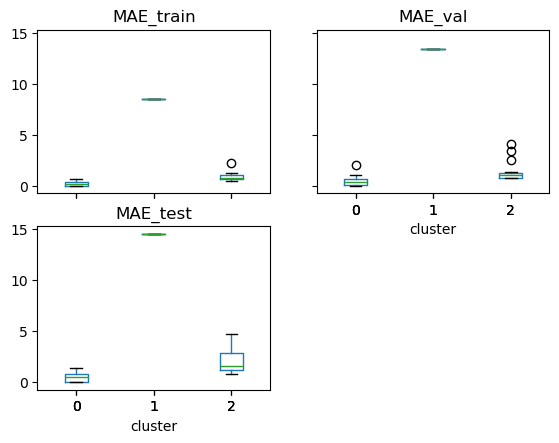

<Figure size 1200x500 with 0 Axes>

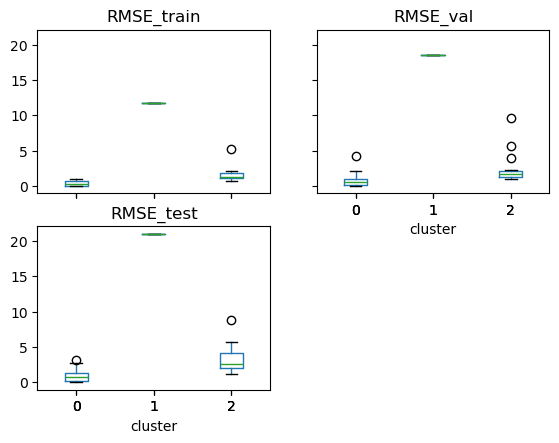

In [128]:
# Juntar erros ao cluster
df_hold_clusters = df_hold.merge(
    features[["cluster"]],
    left_on="CPE",
    right_index=True,
    how="left"
)

# Garantir que cluster é categórico
df_hold_clusters["cluster"] = df_hold_clusters["cluster"].astype(int)

# MAE Train / Val / Test
plt.figure(figsize=(12,5))
df_hold_clusters.boxplot(
    column=["MAE_train", "MAE_val", "MAE_test"],
    by="cluster",
    grid=False
)
plt.suptitle("")
plt.title("MAE — Hold-out interno (Train / Val / Test)")
plt.xlabel("Cluster")
plt.ylabel("MAE")
plt.show()

# RMSE Train / Val / Test
plt.figure(figsize=(12,5))
df_hold_clusters.boxplot(
    column=["RMSE_train", "RMSE_val", "RMSE_test"],
    by="cluster",
    grid=False
)
plt.suptitle("")
plt.title("RMSE — Hold-out interno (Train / Val / Test)")
plt.xlabel("Cluster")
plt.ylabel("RMSE")
plt.show()


#### 5.6.3 — Aplicar o Hold out no XGB best

In [129]:
# CACHE para hold-out interno do XGBoost
holdout_xgb_cache = "cache_holdout_xgb.pkl"

if os.path.exists(holdout_xgb_cache):
    print("✓ Hold-out interno XGB carregado da cache")
    df_hold_xgb = pd.read_pickle(holdout_xgb_cache)

else:
    print("⏳ A executar Hold-out interno XGB por CPE...")

    def temporal_holdout(series):
        n = len(series)
        t1 = int(n * 0.60)
        t2 = int(n * 0.80)
        return series.iloc[:t1], series.iloc[t1:t2], series.iloc[t2:]

    # Dataset com as features *do melhor XGB*
    df_ho_xgb = df_model.dropna(subset=reduced_no_lag1 + ["PotAtiva"]).copy()

    results_holdout_xgb = []

    for cpe, group in df_ho_xgb.groupby("CPE"):

        group = group.sort_values("Timestamp")

        # Target
        y = group["PotAtiva"]
        y_train, y_val, y_test2 = temporal_holdout(y)

        # Features alinhadas
        X = group[reduced_no_lag1]
        X_train = X.loc[y_train.index]
        X_val   = X.loc[y_val.index]
        X_test  = X.loc[y_test2.index]

        # DMatrix locais
        dtrain_local = xgb_lib.DMatrix(X_train, label=y_train, feature_names=reduced_no_lag1)
        dval_local   = xgb_lib.DMatrix(X_val,   label=y_val,   feature_names=reduced_no_lag1)
        dtest_local  = xgb_lib.DMatrix(X_test,  label=y_test2, feature_names=reduced_no_lag1)

        # Treino XGB local (melhor configuração params_r)
        xgb_local = xgb_lib.train(
            params_r,
            dtrain_local,
            num_boost_round=400,
            evals=[(dval_local, "eval")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        # Previsões
        y_pred_train = xgb_local.predict(dtrain_local)
        y_pred_val   = xgb_local.predict(dval_local)
        y_pred_test2 = xgb_local.predict(dtest_local)

        # Guardar métricas
        results_holdout_xgb.append({
            "CPE": cpe,
            "MAE_train": mean_absolute_error(y_train, y_pred_train),
            "MAE_val": mean_absolute_error(y_val, y_pred_val),
            "MAE_test": mean_absolute_error(y_test2, y_pred_test2),
            "RMSE_train": np.sqrt(mean_squared_error(y_train, y_pred_train)),
            "RMSE_val": np.sqrt(mean_squared_error(y_val, y_pred_val)),
            "RMSE_test": np.sqrt(mean_squared_error(y_test2, y_pred_test2)),
        })

    df_hold_xgb = pd.DataFrame(results_holdout_xgb)
    pd.to_pickle(df_hold_xgb, holdout_xgb_cache)
    print("✓ Hold-out interno XGB guardado em cache")

# Estatísticas gerais
df_hold_xgb.describe()

✓ Hold-out interno XGB carregado da cache


MAE_train    MAE_val   MAE_test  RMSE_train   RMSE_val  RMSE_test
count  84.000000  84.000000  84.000000   84.000000  84.000000  84.000000
mean    0.361782   0.441008   0.535944    0.565596   0.735963   0.908469
std     0.811045   0.856845   0.947050    1.135892   1.388373   1.574527
min     0.000000   0.000000   0.000000    0.000000   0.000000   0.000000
25%     0.029940   0.056317   0.060492    0.069276   0.133158   0.148381
50%     0.232028   0.315199   0.355974    0.365044   0.455598   0.531126
75%     0.394847   0.449217   0.547967    0.618849   0.698568   0.929185
max     7.099136   7.066633   7.636730    9.482693   9.667512  11.266887

#### 5.6.4 —  Boxplots por cluster XGB — Hold-out interno

<Figure size 1200x500 with 0 Axes>

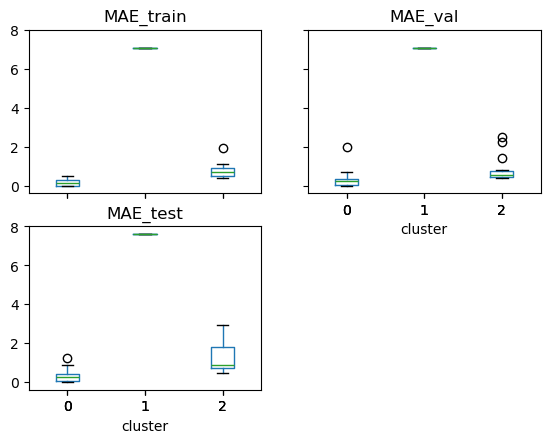

<Figure size 1200x500 with 0 Axes>

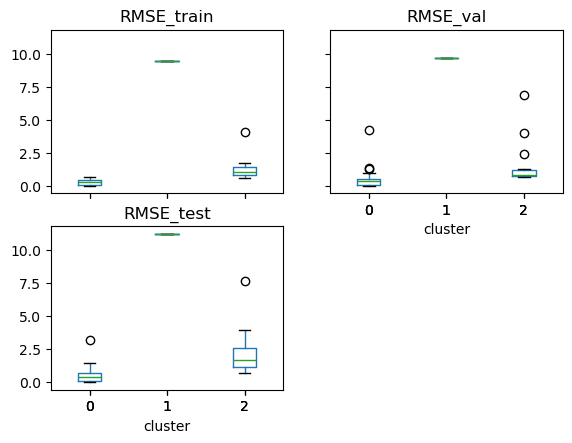

In [130]:
# Juntar clusters
df_hold_xgb_clusters = df_hold_xgb.merge(
    features[["cluster"]],
    left_on="CPE",
    right_index=True,
    how="left"
)

df_hold_xgb_clusters["cluster"] = df_hold_xgb_clusters["cluster"].astype(int)

# BOXPlots MAE
plt.figure(figsize=(12,5))
df_hold_xgb_clusters.boxplot(
    column=["MAE_train", "MAE_val", "MAE_test"],
    by="cluster",
    grid=False
)
plt.suptitle("")
plt.title("XGBoost — MAE (Hold-out interno: Treino / Validação / Teste)")
plt.xlabel("Cluster")
plt.ylabel("MAE")
plt.show()

# BOXPlots RMSE
plt.figure(figsize=(12,5))
df_hold_xgb_clusters.boxplot(
    column=["RMSE_train", "RMSE_val", "RMSE_test"],
    by="cluster",
    grid=False
)
plt.suptitle("")
plt.title("XGBoost — RMSE (Hold-out interno: Treino / Validação / Teste)")
plt.xlabel("Cluster")
plt.ylabel("RMSE")
plt.show()

#### 5.6.5 — Conclusão da verificação de overfitting

Os resultados obtidos mostram que **os erros de treino, validação e teste são relativamente próximos**, com um aumento gradual e esperado ao passar de treino → validação → teste.
Este comportamento é típico de modelos que generalizam adequadamente: existe uma degradação natural do desempenho fora do treino, mas sem quebras abruptas ou discrepâncias indicativas de sobreajuste.

As diferenças mais expressivas entre CPEs devem-se sobretudo às características das próprias séries temporais, nomeadamente:

* variações abruptas e picos súbitos,
* comportamentos muito irregulares,
* períodos de consumo instável.

Estes padrões tornam alguns CPEs mais difíceis de prever, mas não constituem sinal de overfitting do modelo.

De forma geral, os resultados do hold-out interno confirmam que **os modelos avaliados não apresentam sobreajuste significativo** e conseguem manter desempenho consistente em períodos temporais não incluídos no treino. Isto indica que a abordagem seguida é adequada para o problema de previsão energética tratado neste projecto.

### 5.7 — Real vs Previsto: Comparação Visual dos Modelos

Nesta secção comparam-se visualmente as previsões dos diferentes modelos
(Baseline semanal, ARIMA, Random Forest e XGBoost BEST),
utilizando exactamente o mesmo CPE e o mesmo período temporal (conjunto de teste).

É seleccionado um CPE representativo de cada cluster, permitindo analisar
como a dificuldade de previsão varia consoante o perfil energético identificado
na fase de clustering.


In [131]:
def plot_all_models_for_cpe(
    cpe,
    cluster_id,
    get_series,
    train_test_split_series,
    baseline_week_ahead,
    arima_fast,
    rf,
    feature_cols,
    test_df,
    bst_trend,
    reduced_no_lag1,
    alpha=0.15,
    beta=0.5
):
    print(f"\n -------------------- CPE {cpe} | Cluster {cluster_id} --------------------")

    # BASELINE
    s = get_series(cpe)
    train, test = train_test_split_series(s)

    pred_base = baseline_week_ahead(test, s).dropna()
    test_base = test.loc[pred_base.index]

    plot_real_vs_pred_abs_error(
        y_true=test_base,
        y_pred=pred_base,
        title=f"Baseline semanal — CPE {cpe} (Cluster {cluster_id})",
        alpha=alpha,
        beta=beta
    )

    # ARIMA
    pred_arima = arima_fast(train, test)

    plot_real_vs_pred_abs_error(
        y_true=test,
        y_pred=pred_arima,
        title=f"ARIMA — CPE {cpe} (Cluster {cluster_id})",
        alpha=alpha,
        beta=beta
    )

    # RANDOM FOREST
    df_cpe = test_df[test_df["CPE"] == cpe].sort_values("Timestamp")

    y_true = df_cpe.set_index("Timestamp")["PotAtiva"]
    y_pred_rf = pd.Series(
        rf.predict(df_cpe[feature_cols]),
        index=y_true.index
    )

    plot_real_vs_pred_abs_error(
        y_true=y_true,
        y_pred=y_pred_rf,
        title=f"Random Forest — CPE {cpe} (Cluster {cluster_id})",
        alpha=alpha,
        beta=beta
    )

    # XGBOOST (BEST)
    X_xgb = df_cpe[reduced_no_lag1]
    dtest_local = xgb_lib.DMatrix(X_xgb, feature_names=reduced_no_lag1)

    y_pred_xgb = pd.Series(
        bst_trend.predict(dtest_local),
        index=y_true.index
    )

    plot_real_vs_pred_abs_error(
        y_true=y_true,
        y_pred=y_pred_xgb,
        title=f"XGBoost (BEST) — CPE {cpe} (Cluster {cluster_id})",
        alpha=alpha,
        beta=beta
    )


In [132]:
def plot_models_for_all_clusters(
    rep_cpes,
    **kwargs
):
    for cluster_id, cpe in rep_cpes.items():
        if cpe is None:
            continue

        plot_all_models_for_cpe(
            cpe=cpe,
            cluster_id=cluster_id,
            **kwargs
        )



 -------------------- CPE PT0002000133505542CK | Cluster 0 --------------------


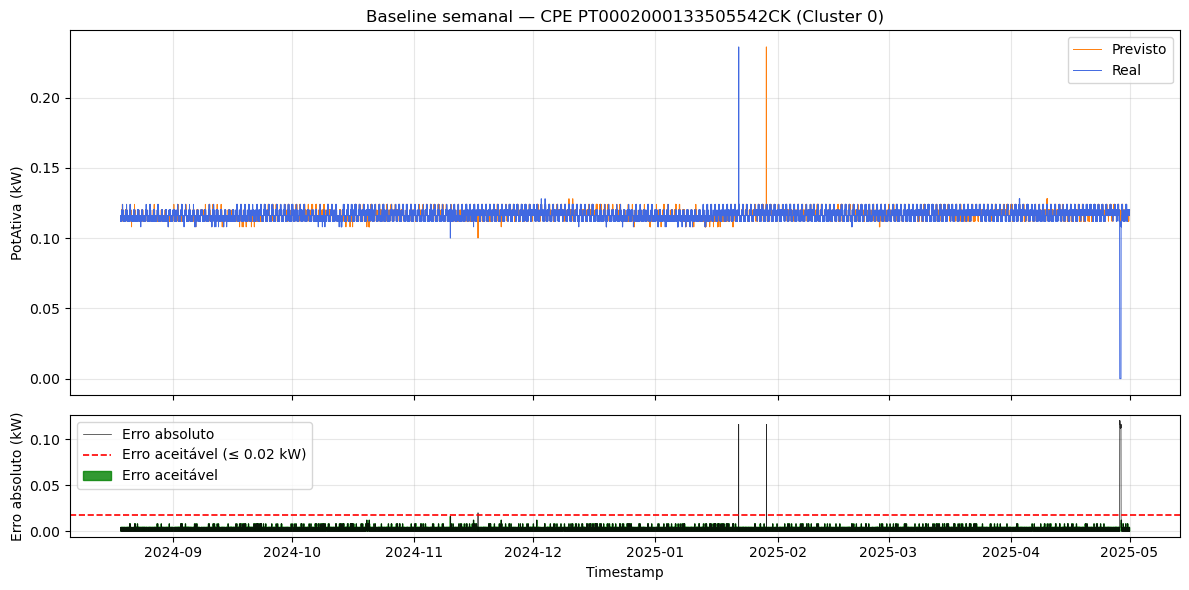

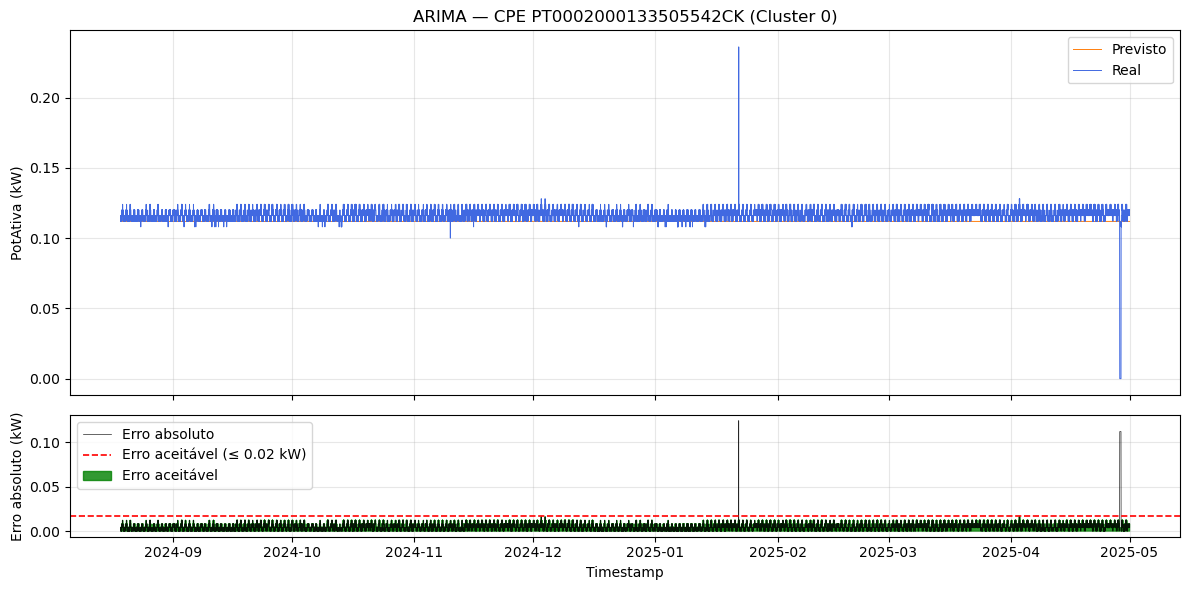

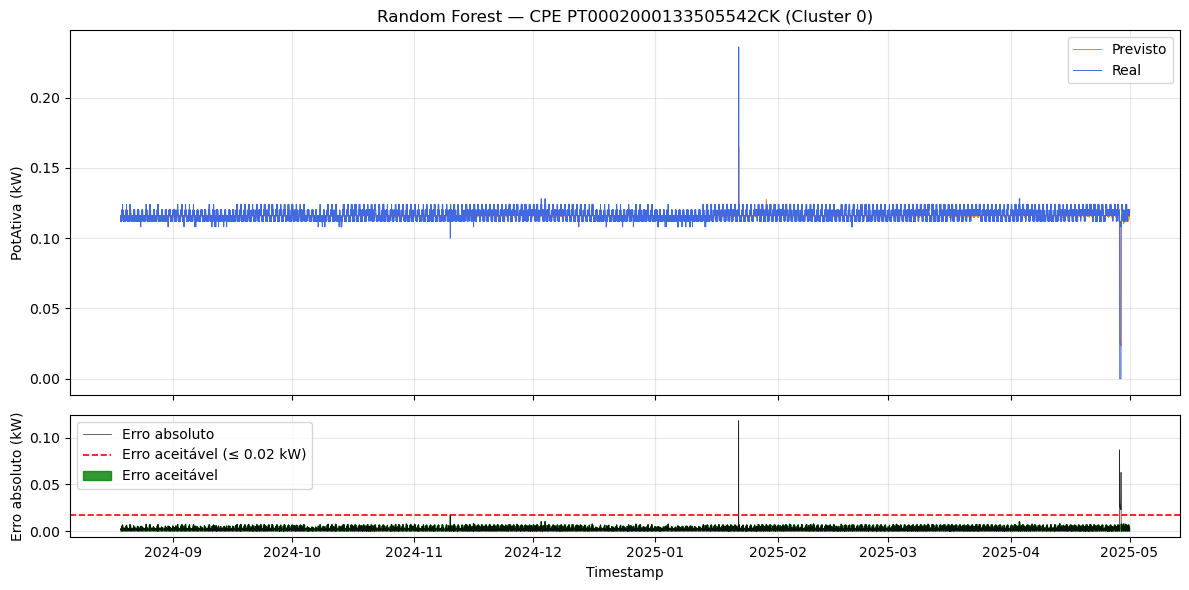

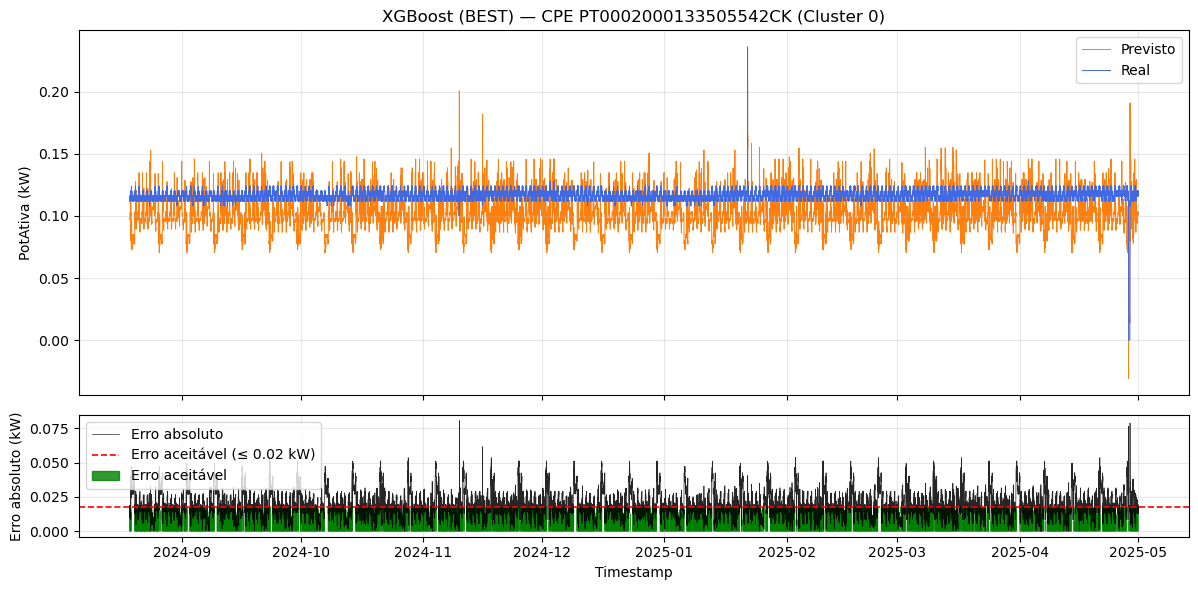


 -------------------- CPE PT0002000078441876HB | Cluster 1 --------------------


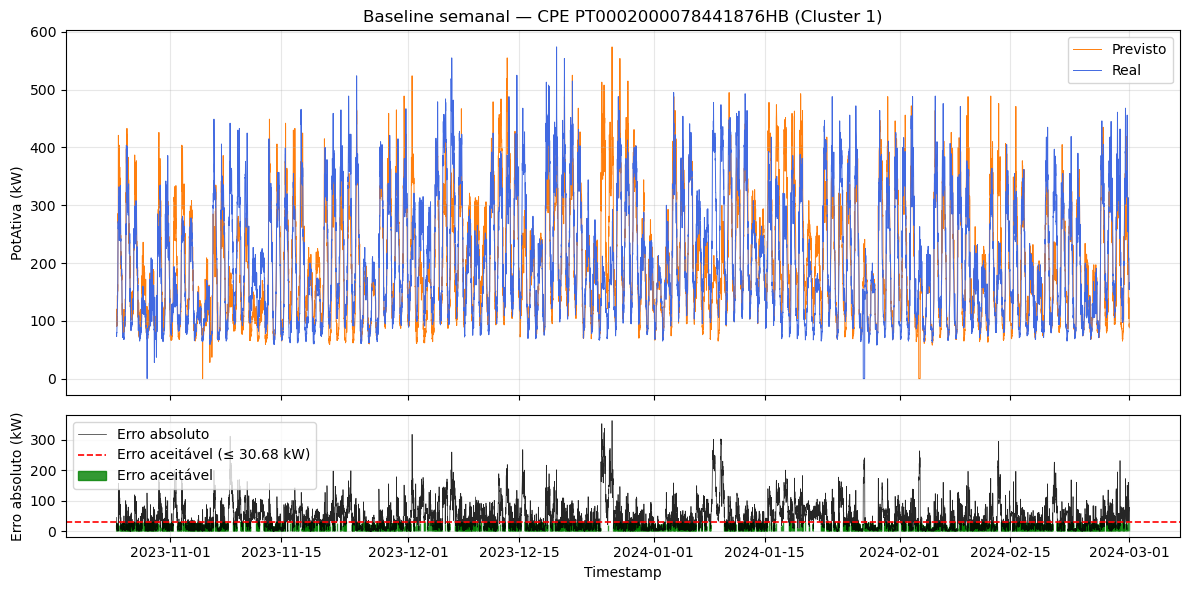

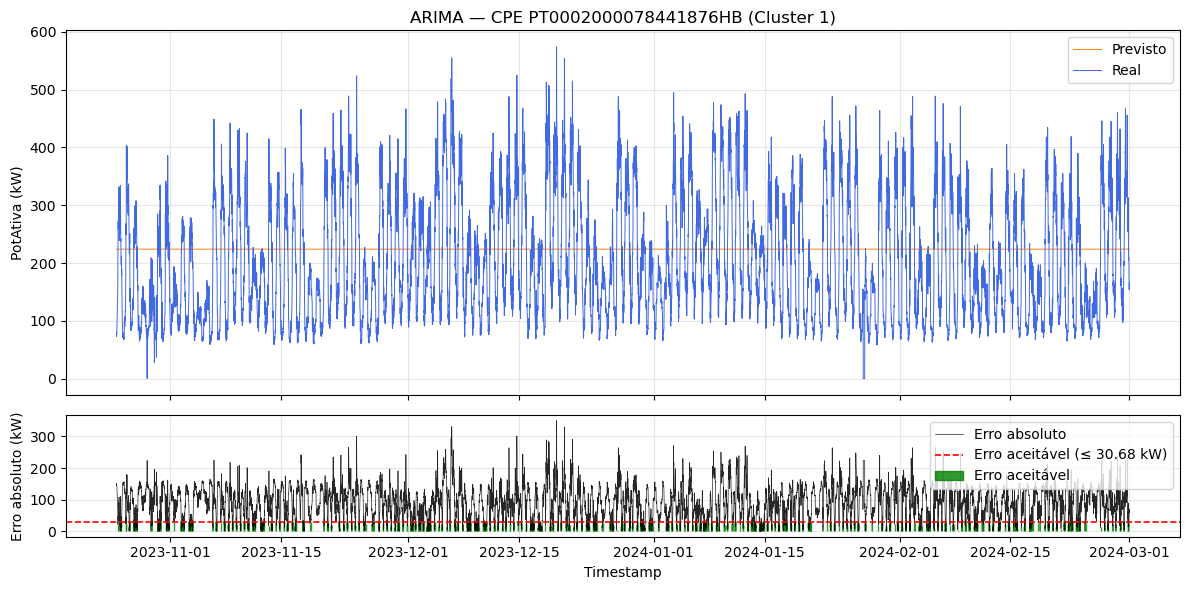

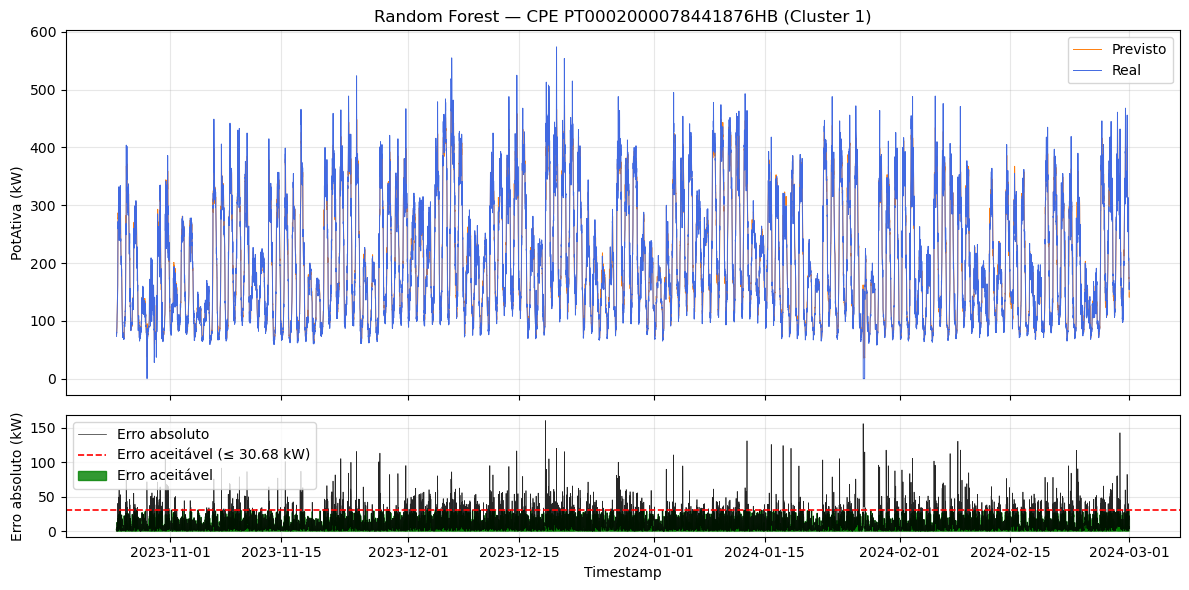

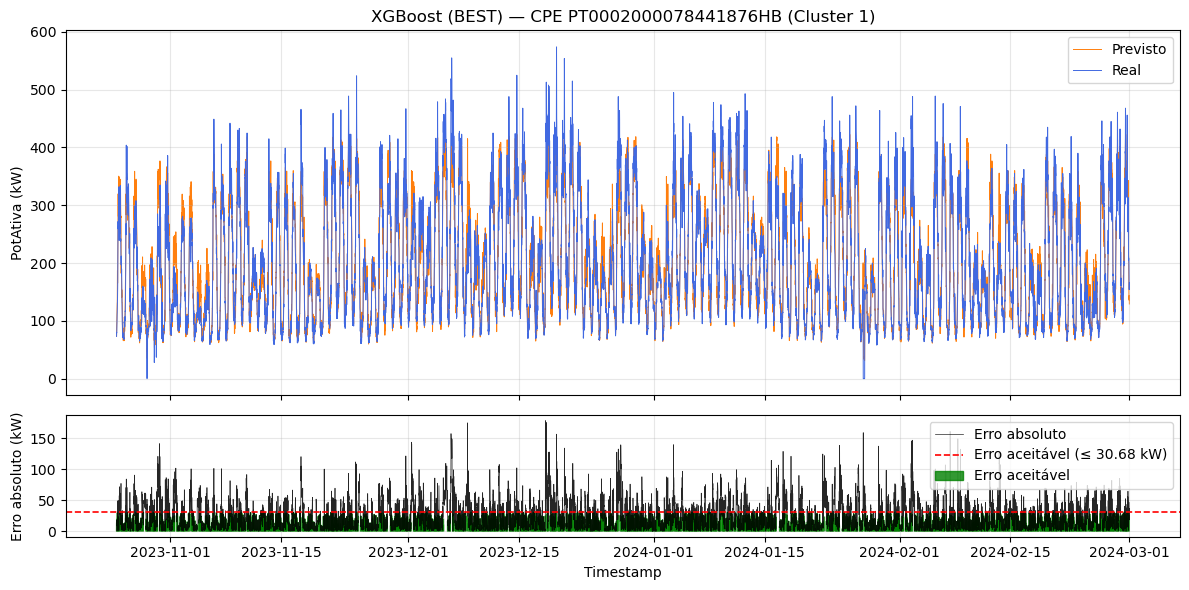


 -------------------- CPE PT0002000068859187RL | Cluster 2 --------------------


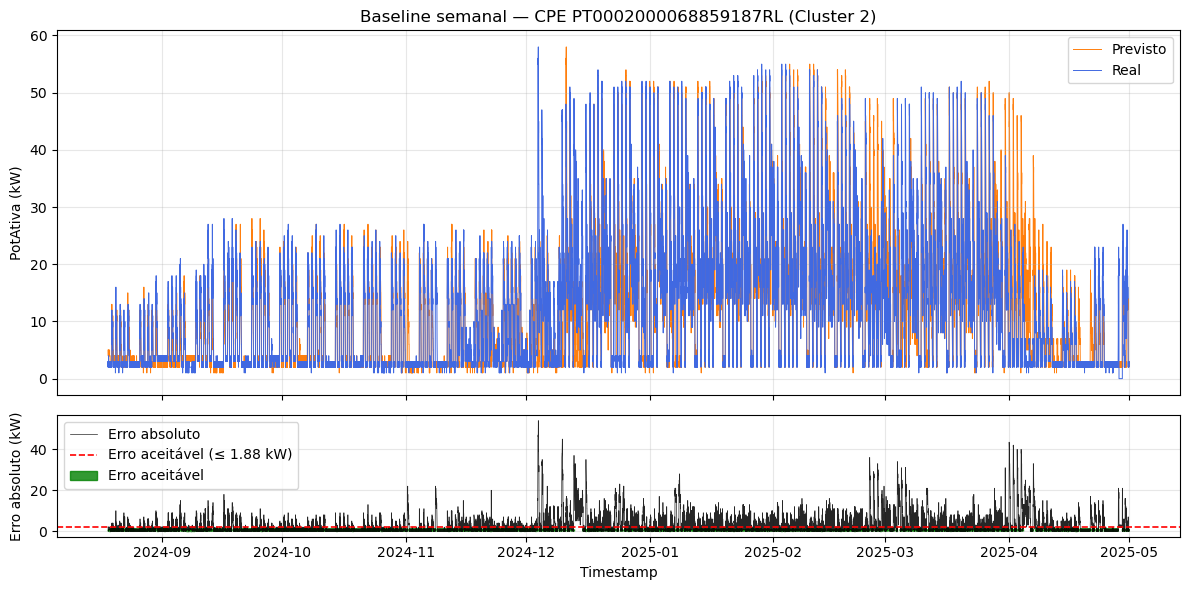

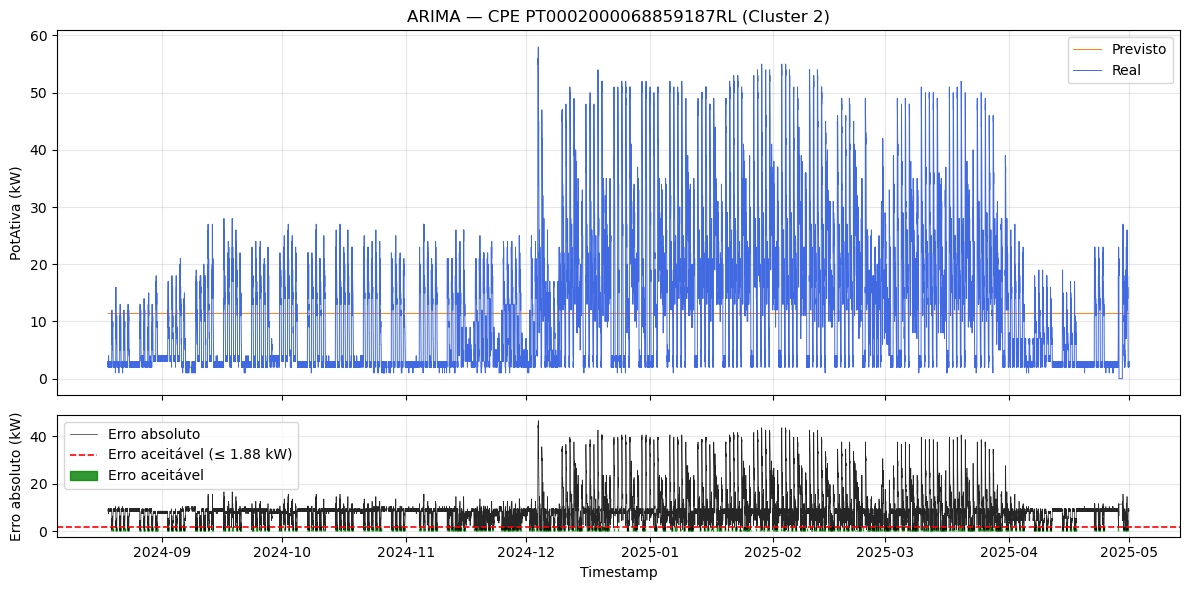

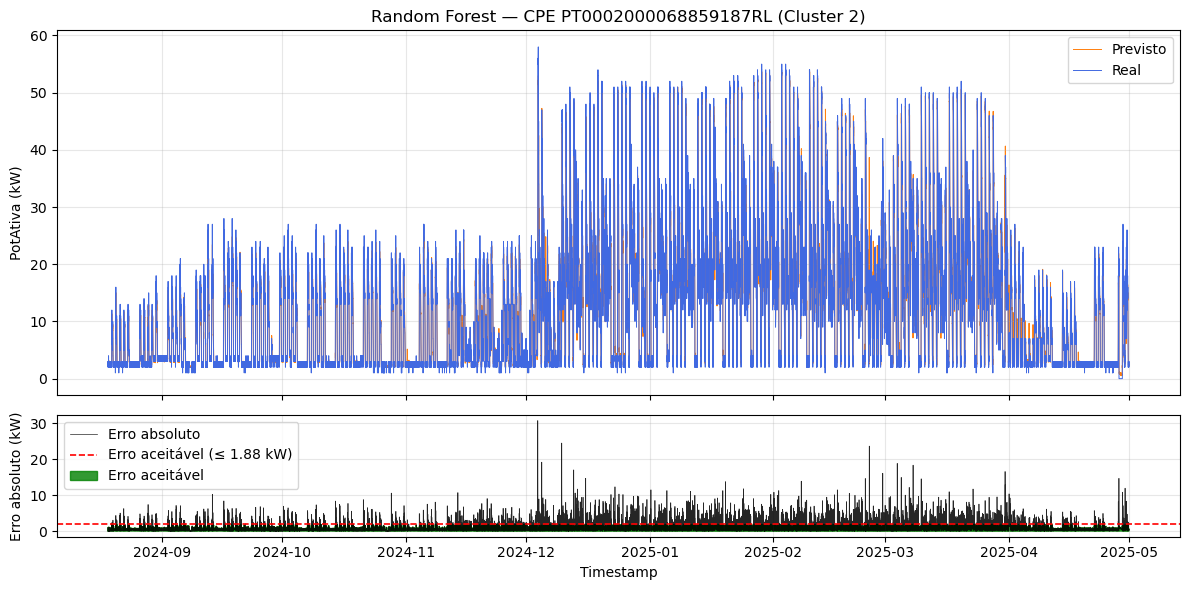

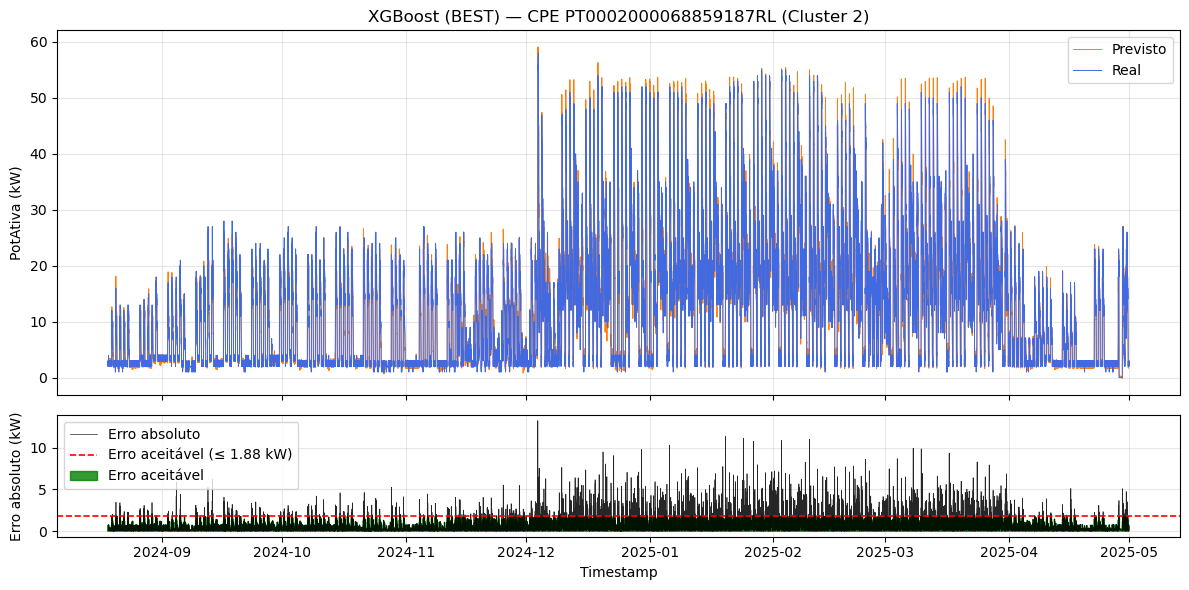

In [133]:
plot_models_for_all_clusters(
    rep_cpes=rep_cpes,
    get_series=get_series,
    train_test_split_series=train_test_split_series,
    baseline_week_ahead=baseline_week_ahead,
    arima_fast=arima_fast,
    rf=rf,
    feature_cols=feature_cols,
    test_df=test_df,
    bst_trend=bst_trend,
    reduced_no_lag1=reduced_no_lag1,
    alpha=0.15,   # 15% erro absoluto aceitável
    beta=0.01      # mínimo de 0.01 kW
)


In [160]:
# XGBOOST — MÉTRICAS POR CPE PARA A 5.8

xgb_cpe_metrics = []

for cpe, df_cpe in test_df.groupby("CPE"):

    df_cpe = df_cpe.sort_values("Timestamp")
    y_true = df_cpe["PotAtiva"].values

    # XGB BEST
    X_xgb = df_cpe[reduced_no_lag1]
    dtest_local = xgb_lib.DMatrix(X_xgb, feature_names=reduced_no_lag1)
    y_pred = bst_trend.predict(dtest_local)

    if len(y_true) == 0:
        continue

    xgb_cpe_metrics.append({
        "CPE": cpe,
        "MAE_XGB": mean_absolute_error(y_true, y_pred),
        "RMSE_XGB": np.sqrt(mean_squared_error(y_true, y_pred)),
        "SMAPE_XGB": smape(y_true, y_pred),
        "R2_XGB": r2_score(y_true, y_pred)
    })

xgb_df = (
    pd.DataFrame(xgb_cpe_metrics)
    .set_index("CPE")
)


# RANDOM FOREST — R2 POR CPE

rf_r2 = []

for cpe, df_cpe in test_df.groupby("CPE"):

    df_cpe = df_cpe.sort_values("Timestamp")
    y_true = df_cpe["PotAtiva"].values

    X_rf = df_cpe[feature_cols_rf]
    y_pred = rf.predict(X_rf)

    if len(y_true) == 0:
        continue

    rf_r2.append({
        "CPE": cpe,
        "R2_RF": r2_score(y_true, y_pred)
    })

rf_r2_df = (
    pd.DataFrame(rf_r2)
    .set_index("CPE")
)

cpe_results_df = cpe_results_df.drop(columns=["R2_RF"], errors="ignore")
cpe_results_df = cpe_results_df.join(rf_r2_df)

In [163]:
baseline_r2_cluster = {}

for cluster_id in sorted(features["cluster"].unique()):

    # CPEs do cluster
    cpes_cluster = features[features["cluster"] == cluster_id].index

    y_true_all = []
    y_pred_all = []

    for cpe in cpes_cluster:

        s = get_series(cpe)
        train, test = train_test_split_series(s)

        pred = baseline_week_ahead(test, s)
        pred = pred.dropna()
        test_valid = test.loc[pred.index]

        if len(test_valid) == 0:
            continue

        y_true_all.append(test_valid.values)
        y_pred_all.append(pred.values)

    if len(y_true_all) == 0:
        baseline_r2_cluster[cluster_id] = np.nan
    else:
        y_true_all = np.concatenate(y_true_all)
        y_pred_all = np.concatenate(y_pred_all)

        baseline_r2_cluster[cluster_id] = r2_score(y_true_all, y_pred_all)

### 5.8 — Comparação dos Modelos por Cluster

Esta secção apresenta a comparação
do desempenho dos modelos de previsão separadamente por cluster
energético. Esta análise permite avaliar de que forma a eficácia de cada
modelo varia em função do perfil energético dos edifícios.

In [164]:
df_models_cpe = (
    baseline_df
    .set_index("CPE")[["MAE", "RMSE", "SMAPE"]]
    .rename(columns={
        "MAE": "MAE_BASE",
        "RMSE": "RMSE_BASE",
        "SMAPE": "SMAPE_BASE"
    })
    .join(arima_df[["MAE_ARIMA", "RMSE_ARIMA", "SMAPE_ARIMA", "R2_ARIMA"]])
    .join(cpe_results_df[["MAE_RF", "RMSE_RF", "SMAPE_RF", "R2_RF"]])
    .join(xgb_df[["MAE_XGB", "RMSE_XGB", "SMAPE_XGB", "R2_XGB"]])
    .join(features[["cluster"]])
)

df_models_cpe.head()


MAE_BASE  RMSE_BASE  SMAPE_BASE  MAE_ARIMA  RMSE_ARIMA  \
CPE                                                                            
PT0002000032936306KX  0.123749   0.516919   10.174171   2.640775    2.676542   
PT0002000032959511HP  0.000000   0.000000    0.000000   0.000000    0.000000   
PT0002000032966446CC  0.084478   0.185117   91.565440   0.066234    0.135517   
PT0002000032968749YT  1.973670   3.483696   44.423611   2.970576    4.502698   
PT0002000032969229AC  0.867905   1.847399   32.993297   2.450383    3.311308   

                      SMAPE_ARIMA  R2_ARIMA    MAE_RF   RMSE_RF    SMAPE_RF  \
CPE                                                                           
PT0002000032936306KX   134.825716 -0.042251  0.076651  0.284699   93.483311   
PT0002000032959511HP     0.000000  1.000000  0.000335  0.000340  200.000000   
PT0002000032966446CC    74.830244 -0.005789  0.047302  0.087536   64.734499   
PT0002000032968749YT    71.621377 -0.052551  0.695831  1.282458   19.066368   
PT0002000032969229AC   117.066195 -0.018023  0.373256  0.756719   19.069578   

                         R2_RF   MAE_XGB  RMSE_XGB   SMAPE_XGB    R2_XGB  \
CPE                                                                        
PT0002000032936306KX  0.988208  0.119067  0.161799   93.539639  0.996191   
PT0002000032959511HP  0.000000  0.006627  0.009189  200.000000  0.000000   
PT0002000032966446CC  0.580350  0.053673  0.071923   66.433548  0.716692   
PT0002000032968749YT  0.914618  0.402588  0.716912   12.340008  0.973318   
PT0002000032969229AC  0.946837  0.232837  0.423638   15.379553  0.983338   

                      cluster  
CPE                            
PT0002000032936306KX        0  
PT0002000032959511HP        0  
PT0002000032966446CC        0  
PT0002000032968749YT        0  
PT0002000032969229AC        0

In [165]:
def table_models_by_cluster(df, cluster_id, baseline_r2_cluster, decimals=3):
    df_cl = df[df["cluster"] == cluster_id]

    table = pd.DataFrame({
        "Modelo": [
            "Baseline (t-7)",
            "ARIMA",
            "Random Forest",
            "XGBoost (BEST)"
        ],
        "MAE": [
            df_cl["MAE_BASE"].mean(),
            df_cl["MAE_ARIMA"].mean(),
            df_cl["MAE_RF"].mean(),
            df_cl["MAE_XGB"].mean()
        ],
        "RMSE": [
            df_cl["RMSE_BASE"].mean(),
            df_cl["RMSE_ARIMA"].mean(),
            df_cl["RMSE_RF"].mean(),
            df_cl["RMSE_XGB"].mean()
        ],
        "SMAPE (%)": [
            df_cl["SMAPE_BASE"].mean(),
            df_cl["SMAPE_ARIMA"].mean(),
            df_cl["SMAPE_RF"].mean(),
            df_cl["SMAPE_XGB"].mean()
        ],
        "$R^2$": [
            baseline_r2_cluster[cluster_id],
            df_cl["R2_ARIMA"].mean(),
            df_cl["R2_RF"].mean(),
            df_cl["R2_XGB"].mean()
        ]
    })

    return table.round(decimals)

In [166]:
table_cluster_0 = table_models_by_cluster(df_models_cpe, 0, baseline_r2_cluster)
table_cluster_1 = table_models_by_cluster(df_models_cpe, 1, baseline_r2_cluster)
table_cluster_2 = table_models_by_cluster(df_models_cpe, 2, baseline_r2_cluster)

print("Cluster 0 — Edifícios de baixo consumo e elevada regularidade")
display(table_cluster_0)

print("Cluster 1 — Outlier energético")
display(table_cluster_1)

print("Cluster 2 — Edifícios com variabilidade intermédia")
display(table_cluster_2)

Cluster 0 — Edifícios de baixo consumo e elevada regularidade


Modelo    MAE   RMSE  SMAPE (%)  $R^2$
0  Baseline (t-7)  0.954  1.765     47.052  0.728
1           ARIMA  2.271  2.954     93.698 -0.313
2   Random Forest  0.411  0.695     50.495  0.876
3  XGBoost (BEST)  0.256  0.389     50.993  0.417

Cluster 1 — Outlier energético


Modelo     MAE     RMSE  SMAPE (%)  $R^2$
0  Baseline (t-7)  45.547   63.956     23.045  0.614
1           ARIMA  91.319  104.722     45.741 -0.036
2   Random Forest  13.863   19.959      7.486  0.962
3  XGBoost (BEST)  23.022   31.993     11.563  0.903

Cluster 2 — Edifícios com variabilidade intermédia


Modelo     MAE    RMSE  SMAPE (%)  $R^2$
0  Baseline (t-7)   5.322   9.855     25.246  0.685
1           ARIMA  12.609  16.855     62.277 -0.135
2   Random Forest   1.778   3.034     10.719  0.959
3  XGBoost (BEST)   1.287   2.362      7.833  0.978

A análise por cluster evidencia que o desempenho relativo dos modelos
varia significativamente em função do perfil energético dos edifícios.
No Cluster 0, caracterizado por elevada regularidade e baixa variância do
consumo, o baseline semanal apresenta desempenho competitivo, enquanto
os modelos baseados em features oferecem ganhos marginais em termos de
erro absoluto. Nestes casos, métricas como o coeficiente de determinação
($R^2$) tornam-se menos informativas, uma vez que a reduzida variância
penaliza modelos mais flexíveis, apesar do seu bom desempenho em MAE e
RMSE.

No Cluster 2, associado a maior variabilidade temporal, a Random Forest e
o XGBoost superam claramente as abordagens clássicas, refletindo a
vantagem de modelos capazes de capturar padrões não lineares e dinâmicas
intra-diárias mais complexas. No outlier energético (Cluster 1), todos os
modelos apresentam degradação de desempenho, embora os modelos baseados
em features reduzam substancialmente o erro face ao baseline semanal.

Estes resultados demonstram que não existe um modelo universalmente
ótimo, sendo metodologicamente mais adequado adoptar estratégias de
previsão diferenciadas por cluster energético, ajustadas às
características específicas de cada perfil de consumo.

## 6. Conclusões
### 6.1 Síntese do trabalho realizado

Neste trabalho foi aplicado o processo CRISP-DM ao conjunto de dados de consumo energético da Câmara Municipal da Maia, com dois objectivos principais:
- Caracterizar os diferentes consumidores através de técnicas de clustering 
- Avaliar a capacidade de previsão do consumo energético utilizando diferentes abordagens de modelação.

O estudo combinou análise exploratória, extração de features, aprendizagem não supervisionada e modelos de previsão, permitindo obter uma visão integrada dos padrões de consumo e da sua previsibilidade.

### 6.2 Conclusões do Clustering

A aplicação de técnicas de clustering permitiu identificar perfis energéticos distintos entre os CPEs analisados.

- O K-Means revelou-se eficaz na separação global dos consumidores, produzindo clusters interpretáveis e coerentes com diferentes níveis de consumo, variabilidade e regularidade.

- O DBSCAN, por sua vez, identificou apenas padrões densos e inequívocos, classificando muitos CPEs como outliers, o que evidencia a heterogeneidade dos comportamentos energéticos.

A comparação entre ambos mostrou que os métodos são complementares:
o K-Means é adequado para uma segmentação global, enquanto o DBSCAN é útil para detecção de perfis muito específicos ou atípicos.

A validação com edifícios reais confirmou que os clusters obtidos correspondem a tipologias plausíveis de consumo (edifícios estáveis, perfis intermédios e grandes consumidores/outliers).

### 6.3 Conclusões da Previsão

A avaliação dos modelos de previsão evidenciou diferenças claras entre abordagens:

- O baseline semanal mostrou-se surpreendentemente forte para edifícios com comportamento estável, confirmando que grande parte do consumo apresenta elevada repetibilidade semanal.

- O ARIMA univariado, sem componente sazonal, apresentou previsões praticamente constantes, demonstrando limitações claras na captura de padrões diários e semanais característicos do consumo energético.

- Os modelos baseados em feature sets (Random Forest e XGBoost) superaram consistentemente o baseline e o ARIMA, capturando melhor a dinâmica temporal e a variabilidade dos dados.

- O XGBoost, após afinação e selecção de features, apresentou o melhor desempenho global, especialmente em edifícios com maior variabilidade e picos de consumo.

As visualizações de Real vs Previsto mostraram de forma clara que a dificuldade de previsão varia significativamente entre clusters, sendo maior em perfis mais irregulares e com eventos extremos.

### 6.4 Considerações metodológicas

A separação treino–teste foi realizada de forma estritamente temporal e individual por CPE, utilizando os 70% iniciais de cada série para treino e os 30% finais para teste. Esta abordagem garante ausência de data leakage e avalia correctamente a capacidade de previsão do consumo futuro de edifícios já observados.

As features foram construídas apenas com informação passada ou com características estruturais dos consumidores, assegurando consistência metodológica.

### 6.5 Limitações e trabalho futuro

Apesar dos bons resultados obtidos, existem limitações relevantes:

- A ausência de variáveis exógenas (meteorologia, ocupação, eventos) limita a capacidade de previsão de picos abruptos.

- Os modelos avaliados não foram optimizados para previsão multi-horizonte de longo prazo.

- O ARIMA poderia ser melhorado com componentes sazonais explícitas, embora tal não fosse o foco deste trabalho.

Como trabalho futuro, seria interessante integrar dados externos, explorar modelos híbridos e avaliar estratégias de previsão específicas por cluster.

### 6.6 Conclusão final

Em síntese, este trabalho demonstra que:

- Os dados de consumo energético apresentam estrutura suficiente para segmentação significativa;

- A previsibilidade depende fortemente do perfil energético do consumidor;

- Modelos baseados em features oferecem ganhos substanciais face a abordagens clássicas univariadas.

Os resultados confirmam o potencial deste tipo de dados para apoiar análise energética e sistemas de previsão em contexto real.